In [1]:
from collections import OrderedDict
import datetime as dt
import pandas as pd
import alphalens as al
import numpy as np
import alphalens as al
import cvxpy as cvx
import os
import sys
import time
import matplotlib.pyplot as plt
import matplotlib.style as style
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from statsmodels.formula.api import ols
from statistics import median
from scipy.optimize import fmin_l_bfgs_b
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from scipy.stats import gaussian_kde
style.use('ggplot')
from IPython.core.pylabtools import figsize
figsize(15, 5)

mod_path = '/Users/richard.wuebker/Projects/price_data_utils'
if mod_path not in sys.path:
    sys.path.append(mod_path)

libs_path = '/Users/richard.wuebker/Projects/backtesting/libs'
if libs_path not in sys.path:
    sys.path.append(libs_path)

    
from risk_model import RiskModelPCA
from optimal_holdings import OptimalHoldingsCVX
    
from data_loader import DataLoader
from mp_historical_prices import HistoricalPrices

In [2]:
dl = DataLoader(prices_dir='../../price_data_utils/prices', info_dir='../../price_data_utils/info', 
                analysis_date_str='2019-08-07', cached_dir='../../price_data_utils/cached')
dl.load_data()
data = dl.data

Prediction Date: 2019-08-09


In [3]:
hp = HistoricalPrices(prices_dir='../../price_data_utils/prices', 
                      cached_dir='../../price_data_utils/cached',
                      date_str='2019-08-09')
hp.get_prices()
prices = hp.prices

# look for duplicates
p = prices.reset_index()
p.loc[p.duplicated(subset=['Date', 'ticker'], keep='first')]

,index,Date,High,Low,Open,Close,Volume,Adj Close,ticker


In [4]:
prices.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
0,1990-01-02,17.947027,17.527565,17.557526,17.947027,626200.0,7.267582,KMB
1,1990-01-03,17.976990,17.827181,17.976990,17.887104,749200.0,7.243319,KMB
2,1990-01-04,17.976990,17.797220,17.857143,17.857143,439700.0,7.231189,KMB
3,1990-01-05,17.857143,17.617449,17.797220,17.737297,712500.0,7.182656,KMB
4,1990-01-08,17.917067,17.707335,17.737297,17.917067,495600.0,7.255455,KMB


In [5]:
prices.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
4933501,2019-08-05,38.950001,38.009998,38.709999,38.360001,1900600.0,38.360001,AL
4933502,2019-08-06,39.180000,38.049999,38.689999,38.860001,577500.0,38.860001,AL
4933503,2019-08-07,38.950001,37.709999,38.040001,38.700001,923700.0,38.700001,AL
4933504,2019-08-08,40.250000,38.919998,38.950001,40.169998,809000.0,40.169998,AL
4933505,2019-08-09,40.549999,38.209999,39.939999,40.110001,1047265.0,40.110001,AL


In [6]:
def transform_prices(df, end_date_str):
    prices_temp = df.pivot(index='Date', columns='ticker', values='Adj Close')
    end_date = dt.datetime.strptime(end_date_str, '%Y-%m-%d')
    start_date = end_date - pd.DateOffset(years=5)
    prices_temp.index = pd.to_datetime(prices_temp.index)
    prices = prices_temp.loc[start_date:end_date]
    return prices.dropna(axis=1)
new_p = transform_prices(prices, '2016-01-05')

In [7]:
# to make the index of data we have with sector the same as in returns and prices

sector_data = data['sector']
index_ = sector_data.index.intersection(new_p.columns)
sector_data = sector_data.loc[index_]
p = new_p.loc[:, index_].copy() # to use only the stocks that are in sector_data
sectors = sector_data.unique()

In [8]:
returns = p.pct_change().drop(p.index[0])
print(returns.shape)
print(sector_data.shape)
print(p.shape)

(1257, 741)
(741,)
(1258, 741)


In [9]:
p.head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-05,16.319235,25.350000,50.676487,91.209999,692.690002,59.998005,28.536177,40.534866,70.415245,34.523262,...,14.976269,77.790001,17.154980,33.694031,43.528183,23.909542,14.824180,6.94250,151.752335,16.587673
2011-01-06,16.460661,25.750000,50.676487,89.559998,718.400024,62.723892,28.326279,40.797176,69.994743,34.397305,...,14.842355,76.050003,16.839489,33.711502,43.555824,23.958487,14.856651,6.83000,150.116272,16.470205
2011-01-07,16.476372,25.950001,50.264294,89.133331,735.150024,62.590939,28.334854,40.758602,70.200493,34.976746,...,14.686119,75.209999,16.681742,33.589188,43.472923,24.031902,14.669928,6.69375,148.875351,16.315643
2011-01-10,16.334949,26.200001,50.342079,90.526665,749.960022,62.932850,28.647541,41.267784,70.057358,35.111115,...,14.358768,74.680000,16.497704,33.807583,44.891319,24.553984,14.678050,6.90250,151.096298,16.290915
2011-01-11,16.405655,25.690001,50.715374,93.663330,751.900024,63.474232,29.354307,41.653553,72.347855,35.279057,...,14.336452,76.300003,16.333384,33.982292,45.572895,24.456089,14.507563,6.79875,152.874680,16.303284


In [10]:
p.tail()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-29,24.640928,59.299999,66.267441,184.456665,1650.000000,141.577072,48.883698,29.317432,31.023300,45.610756,...,29.112070,136.169998,34.340061,73.815681,75.976669,35.107853,39.816341,41.125000,314.309814,29.093164
2015-12-30,24.427971,57.509998,65.351830,184.169998,1649.540039,140.273254,48.753433,29.024263,29.830099,45.245197,...,28.986509,135.639999,34.271770,73.255249,75.430962,35.071419,39.375340,40.480000,312.891907,29.008694
2015-12-31,24.099659,57.299999,64.807915,182.053329,1643.000000,139.751724,48.278931,29.077566,30.792358,44.842140,...,28.520142,134.580002,34.186417,72.770805,74.725288,34.515739,39.672337,40.305000,311.492279,28.831297
2016-01-04,23.616772,55.610001,63.629417,182.463333,1555.660034,137.626907,48.325451,29.886017,31.100277,44.710915,...,27.910280,130.350006,33.768162,71.944405,73.135201,34.415535,39.096333,39.830002,304.704834,28.451166
2016-01-05,23.509462,55.060001,63.892326,183.986664,1594.089966,137.800766,48.167278,30.179193,31.591042,44.542198,...,28.170368,129.809998,34.382748,71.241478,73.530373,33.559250,39.078335,40.075001,305.491516,28.755270


In [11]:
def create_momentum_factor(prices, sector_data):

    # demean by sector
    df = prices.pct_change(252).dropna()
    sectors = sector_data.unique()
    
    # demean by sector
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [12]:
momentum = create_momentum_factor(p, sector_data)
print(momentum.shape)
print(momentum.index[0])
print(momentum.index[-1])
momentum.head()

(1006, 741)
2012-01-05 00:00:00
2016-01-05 00:00:00


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-05,-0.471847,-1.326777,-0.228916,1.691173,-0.369068,1.588395,1.130563,0.728793,-1.200640,1.032457,...,0.261618,-0.686747,0.149496,-0.158839,-1.051144,1.621097,-1.130563,1.214655,0.126137,-0.172855
2012-01-06,-0.476518,-1.382838,-0.196213,1.686502,-0.583969,1.532334,1.130563,0.752152,-1.256701,1.027785,...,0.355053,-0.551266,0.219572,-0.182198,-1.004426,1.588395,-1.065159,1.275388,0.233587,-0.149496
2012-01-09,-0.513892,-1.448242,-0.294320,1.663143,-0.738136,1.513647,1.172609,0.752152,-1.130563,1.023113,...,0.327022,-0.537251,0.303664,-0.144824,-0.976396,1.588395,-1.027785,1.340792,0.154168,0.070076
2012-01-10,-0.551266,-1.508975,-0.163511,1.649128,-0.896976,1.555693,1.125892,0.569953,-1.191296,1.027785,...,0.415786,-0.560610,0.336366,-0.228916,-1.097861,1.522990,-1.069831,1.261372,0.116794,-0.004672
2012-01-11,-0.527908,-1.457586,-0.303664,1.649128,-0.873617,1.504303,1.083846,0.284977,-1.219327,1.018441,...,0.485862,-0.551266,0.355053,-0.228916,-1.079174,1.518319,-0.995083,1.331449,0.130809,-0.121465


In [13]:
def create_mean_reversion_factor(window_length, prices, sector_data):
    sectors = sector_data.unique()
    df = prices.pct_change(window_length).dropna()
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first', ascending=False)
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [14]:
mean_reversion = create_mean_reversion_factor(10, p, sector_data)
print(mean_reversion.shape)
print(mean_reversion.index[0])
print(mean_reversion.index[-1])
mean_reversion.head()

(1248, 741)
2011-01-20 00:00:00
2016-01-05 00:00:00


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-20,0.397099,1.434227,-0.523236,-1.331449,-1.719204,-1.709860,-0.289648,-0.775510,-1.009098,-0.957709,...,0.116794,1.223998,1.494960,0.163511,-1.424884,-1.069831,1.186624,0.766167,0.004672,1.392181
2011-01-21,0.429801,1.639784,-0.611999,-1.728547,-1.653799,-1.457586,-0.168183,-0.172855,-1.167937,-1.438899,...,0.733465,0.373740,1.382838,0.537251,-1.494960,-0.812884,1.396853,0.887632,-0.593312,1.392181
2011-01-24,0.252274,1.630441,-0.714778,-1.723876,-1.438899,-1.471601,-0.186870,-0.275633,-1.546349,-1.111876,...,0.158839,-0.906319,1.345464,-0.140152,-1.635112,-0.854930,1.079174,0.182198,-0.649373,1.256701
2011-01-25,-0.999754,1.630441,-0.668060,-1.723876,-1.345464,-1.653799,0.541923,0.308335,-1.508975,-1.504303,...,-1.172609,-0.873617,0.719449,-0.070076,-1.597738,0.429801,0.882961,1.242685,-0.770839,1.261372
2011-01-26,-0.313007,0.724121,-0.864274,-1.719204,-1.158594,-1.602410,0.999754,0.280305,-1.027785,-1.392181,...,-1.382838,0.537251,0.327022,-0.032702,-1.569708,-0.504549,-0.322351,0.644701,-0.920335,1.359479


In [15]:
def create_smoothed_factor(factor, window=5):
    df = factor.rolling(window).mean().dropna()
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [16]:
smoothed_mean_reversion = create_smoothed_factor(mean_reversion, 5)
print(smoothed_mean_reversion.shape)
print(smoothed_mean_reversion.index[0])
print(smoothed_mean_reversion.index[-1])
smoothed_mean_reversion.head()

(1244, 741)
2011-01-26 00:00:00
2016-01-05 00:00:00


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-26,-0.088763,1.508975,-0.798869,-1.686502,-1.560364,-1.639784,0.214900,-0.177526,-1.401525,-1.448242,...,-0.359725,0.051389,1.209983,0.088763,-1.630441,-0.658717,1.004426,0.915663,-0.677404,1.452914
2011-01-27,-0.140152,1.107205,-0.794197,-1.723876,-1.443571,-1.649128,0.504549,0.163511,-1.266044,-1.466929,...,-0.724121,-0.149496,1.027785,0.042046,-1.522990,-0.546595,0.369068,0.313007,-0.943693,1.420212
2011-01-28,-0.196213,0.691419,-0.616671,-1.723876,-1.345464,-1.677158,0.817556,0.294320,-1.125892,-1.462258,...,-1.223998,-0.238259,0.822228,-0.116794,-1.111876,-0.369068,-0.355053,-0.280305,-0.808213,1.275388
2011-01-31,-0.317679,0.476518,-0.378412,-1.723876,-0.840915,-1.691173,0.929678,0.275633,-0.999754,-1.448242,...,-1.490288,-0.046717,0.546595,-0.186870,-0.471847,-0.014015,-0.957709,-0.682075,-0.756823,1.046472
2011-02-01,-0.070076,-0.018687,-0.084091,-1.723876,-0.261618,-1.686502,0.943693,0.266290,-0.817556,-1.410868,...,-1.518319,0.126137,0.551266,-0.256946,0.023359,-0.439144,-1.466929,-1.266044,-0.766167,0.770839


In [17]:
smoothed_momentum = create_smoothed_factor(momentum, window=44)
print(smoothed_momentum.shape)
print(smoothed_momentum.index[0])
print(smoothed_momentum.index[-1])
smoothed_momentum.head()

(963, 741)
2012-03-08 00:00:00
2016-01-05 00:00:00


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2012-03-08,-0.144824,-1.214655,-0.401770,1.541677,-1.125892,1.294075,1.261372,1.055815,-1.247357,0.378412,...,0.686747,-0.074748,0.373740,-0.130809,-1.298746,1.639784,-1.167937,1.111876,0.177526,0.327022
2012-03-09,-0.121465,-1.223998,-0.387755,1.541677,-1.144579,1.294075,1.261372,1.060487,-1.242685,0.341038,...,0.696091,-0.065404,0.378412,-0.144824,-1.298746,1.639784,-1.177281,1.111876,0.177526,0.331694
2012-03-12,-0.107450,-1.223998,-0.387755,1.537006,-1.163266,1.289403,1.266044,1.069831,-1.238014,0.308335,...,0.700762,-0.051389,0.378412,-0.158839,-1.308090,1.639784,-1.191296,1.102533,0.172855,0.364396
2012-03-13,-0.070076,-1.219327,-0.373740,1.537006,-1.177281,1.280059,1.270716,1.074502,-1.242685,0.289648,...,0.696091,-0.037374,0.364396,-0.168183,-1.308090,1.635112,-1.200640,1.102533,0.186870,0.373740
2012-03-14,-0.046717,-1.219327,-0.369068,1.537006,-1.191296,1.280059,1.270716,1.088518,-1.238014,0.252274,...,0.705434,-0.028030,0.355053,-0.168183,-1.312762,1.639784,-1.200640,1.102533,0.205557,0.369068


In [18]:
def create_ewm_factor(factor, com=0.50):
    df = factor.ewm(com=com).mean().dropna()
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [19]:
ewm_mean_reversion = create_ewm_factor(mean_reversion)
print(ewm_mean_reversion.shape)
print(ewm_mean_reversion.index[0])
print(ewm_mean_reversion.index[-1])
ewm_mean_reversion.head()

(1248, 741)
2011-01-20 00:00:00
2016-01-05 00:00:00


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-20,0.397099,1.434227,-0.523236,-1.331449,-1.719204,-1.709860,-0.289648,-0.775510,-1.009098,-0.957709,...,0.116794,1.223998,1.494960,0.163511,-1.424884,-1.069831,1.186624,0.766167,0.004672,1.392181
2011-01-21,0.453160,1.597738,-0.635358,-1.653799,-1.686502,-1.537006,-0.219572,-0.341038,-1.167937,-1.359479,...,0.644701,0.654045,1.415540,0.476518,-1.508975,-0.929678,1.378166,0.901648,-0.471847,1.396853
2011-01-24,0.327022,1.644456,-0.710106,-1.709860,-1.555693,-1.537006,-0.196213,-0.327022,-1.471601,-1.223998,...,0.298992,-0.476518,1.420212,0.032702,-1.611754,-0.929678,1.219327,0.415786,-0.607327,1.368823
2011-01-25,-0.602656,1.644456,-0.728793,-1.714532,-1.462258,-1.639784,0.317679,0.112122,-1.532334,-1.457586,...,-0.752152,-0.798869,0.999754,-0.051389,-1.635112,0.004672,1.046472,1.018441,-0.761495,1.331449
2011-01-26,-0.453160,1.111876,-0.864274,-1.719204,-1.312762,-1.644456,0.840915,0.238259,-1.242685,-1.457586,...,-1.233342,0.126137,0.593312,-0.032702,-1.621097,-0.359725,0.112122,0.817556,-0.910991,1.378166


In [20]:
ewm_momentum = create_ewm_factor(momentum)
print(ewm_momentum.shape)
print(ewm_momentum.index[0])
print(ewm_momentum.index[-1])
ewm_momentum.head()

(1006, 741)
2012-01-05 00:00:00
2016-01-05 00:00:00


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-05,-0.471847,-1.326777,-0.228916,1.691173,-0.369068,1.588395,1.130563,0.728793,-1.200640,1.032457,...,0.261618,-0.686747,0.149496,-0.158839,-1.051144,1.621097,-1.130563,1.214655,0.126137,-0.172855
2012-01-06,-0.467175,-1.368823,-0.210229,1.686502,-0.523236,1.541677,1.135235,0.761495,-1.242685,1.032457,...,0.331694,-0.574625,0.210229,-0.168183,-1.009098,1.593067,-1.083846,1.261372,0.219572,-0.149496
2012-01-09,-0.499877,-1.420212,-0.294320,1.667815,-0.677404,1.522990,1.158594,0.761495,-1.158594,1.023113,...,0.336366,-0.551266,0.266290,-0.163511,-0.985739,1.583723,-1.046472,1.312762,0.177526,0.014015
2012-01-10,-0.532579,-1.480945,-0.205557,1.649128,-0.840915,1.560364,1.144579,0.635358,-1.191296,1.032457,...,0.369068,-0.560610,0.317679,-0.219572,-1.046472,1.551021,-1.041800,1.284731,0.149496,0.000000
2012-01-11,-0.532579,-1.462258,-0.270961,1.649128,-0.859602,1.522990,1.093189,0.369068,-1.205311,1.032457,...,0.462503,-0.555938,0.336366,-0.233587,-1.074502,1.532334,-1.013770,1.317433,0.126137,-0.074748


In [21]:
index = smoothed_momentum.index.intersection(smoothed_mean_reversion.index)
m = momentum.loc[index,:].stack()
print(m.shape)
sm = smoothed_momentum.loc[index,:].stack()
print(sm.shape)
mr = mean_reversion.loc[index, :].stack()
print(mr.shape)
smr = smoothed_mean_reversion.loc[index, :].stack()
print(smr.shape)
ewmmr = ewm_mean_reversion.loc[index, :].stack()
print(ewmmr.shape)
ewmm = ewm_momentum.loc[index, :].stack()
print(ewmm.shape)
adj_p = p.loc[index,:].copy()
print(adj_p.shape)

(713583,)
(713583,)
(713583,)
(713583,)
(713583,)
(713583,)
(963, 741)


In [22]:
factor_data = OrderedDict()
factor_data['momentum'] = al.utils.get_clean_factor_and_forward_returns(m, adj_p, periods=[1])
factor_data['smoothed_momentum'] = al.utils.get_clean_factor_and_forward_returns(sm, adj_p, periods=[1])
factor_data['ewm_momentum'] = al.utils.get_clean_factor_and_forward_returns(ewmm, adj_p, periods=[1])
factor_data['mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(mr, adj_p, periods=[1])
factor_data['smoothed_mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(smr, adj_p, periods=[1])
factor_data['ewm_mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(ewmmr, adj_p, periods=[1])


Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% en

In [23]:
factor_data['momentum'].head()

1D    factor  factor_quantile
date       asset                                     
2012-03-08 CSCO   0.006097  0.495205                4
           UAL   -0.007014 -1.308090                1
           TROW   0.017083 -0.144824                3
           ISRG   0.013485  1.607082                5
           NVR    0.025427 -1.364151                1

In [24]:
factor_returns_df = pd.DataFrame()
for key, val in factor_data.items():
    factor_returns_df[key] = al.performance.factor_returns(val).iloc[:,0]
factor_returns_df.head()

,momentum,smoothed_momentum,ewm_momentum,mean_reversion,smoothed_mean_reversion,ewm_mean_reversion
date,,,,,,
2012-03-08,-0.000643,-0.000717,-0.000645,0.000103,0.000450,0.000104
2012-03-09,0.002062,0.002031,0.002097,-0.001641,-0.002123,-0.001700
2012-03-12,-0.003786,-0.003884,-0.003792,0.000697,0.001775,0.000723
2012-03-13,-0.000981,-0.001180,-0.000963,0.000475,-0.000366,0.000277
2012-03-14,-0.004194,-0.004394,-0.004192,0.000466,0.001398,0.000762


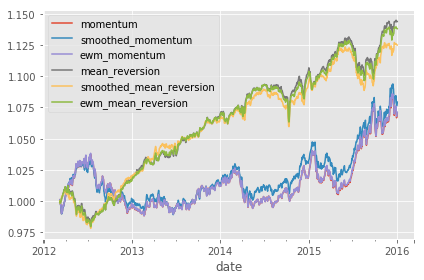

In [25]:
(1+factor_returns_df).cumprod().plot()
plt.tight_layout()

In [26]:
factor_names = factor_data.keys()
factor_names

odict_keys(['momentum', 'smoothed_momentum', 'ewm_momentum', 'mean_reversion', 'smoothed_mean_reversion', 'ewm_mean_reversion'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12362e898>,
      dtype=object)

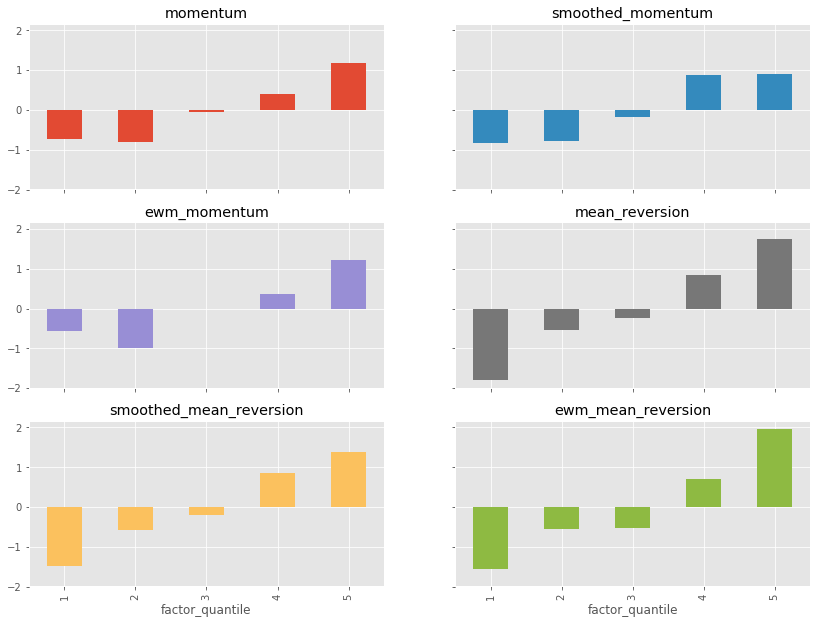

In [27]:
qr_factor_returns = pd.DataFrame()
for key, val in factor_data.items():
    qr_factor_returns[key] = al.performance.mean_return_by_quantile(val)[0].iloc[:,0]


(10000 * qr_factor_returns).plot.bar(
    subplots=True,
    sharey = True,
    layout=(4,2),
    figsize=(14,14),
    legend=False
)

In [28]:
def get_sharpe_ratio(factor_returns, ann_factor):
    sharpe = factor_returns.mean() / (factor_returns.std())
    return sharpe * ann_factor

ann_factor = np.sqrt(252)
get_sharpe_ratio(factor_returns_df, ann_factor).round(2)

momentum                   0.58
smoothed_momentum          0.64
ewm_momentum               0.58
mean_reversion             1.59
smoothed_mean_reversion    1.40
ewm_mean_reversion         1.53
dtype: float64

# Looking at the data above, we'll use the second half of the year 2013 to back test the data since all factors seem to do well then.

In [29]:
index = smoothed_momentum.index.intersection(smoothed_mean_reversion.loc['2013-07-01':'2014-01-15'].index)

In [30]:
m = momentum.loc[index,:].stack()
print(m.shape)
sm = smoothed_momentum.loc[index,:].stack()
print(sm.shape)
mr = mean_reversion.loc[index, :].stack()
print(mr.shape)
smr = smoothed_mean_reversion.loc[index, :].stack()
print(smr.shape)

ewmmr = ewm_mean_reversion.loc[index, :].stack()
print(ewmmr.shape)
ewmm = ewm_momentum.loc[index, :].stack()
print(ewmm.shape)
adj_p = p.loc[index,:].copy()
print(adj_p.shape)

(102258,)
(102258,)
(102258,)
(102258,)
(102258,)
(102258,)
(138, 741)


Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% en

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128c7c668>,
      dtype=object)

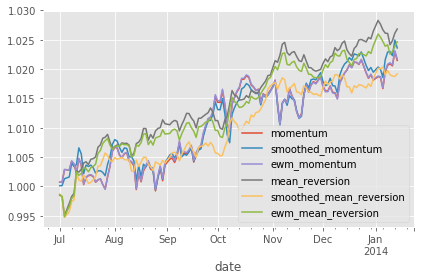

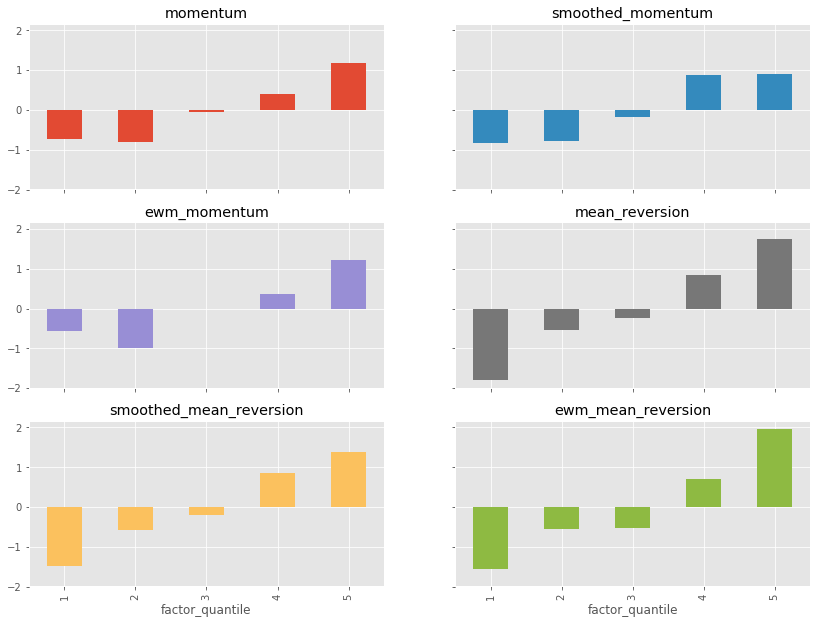

In [31]:
factor_data = OrderedDict()
factor_data['momentum'] = al.utils.get_clean_factor_and_forward_returns(m, adj_p, periods=[1])
factor_data['smoothed_momentum'] = al.utils.get_clean_factor_and_forward_returns(sm, adj_p, periods=[1])
factor_data['ewm_momentum'] = al.utils.get_clean_factor_and_forward_returns(ewmm, adj_p, periods=[1])
factor_data['mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(mr, adj_p, periods=[1])
factor_data['smoothed_mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(smr, adj_p, periods=[1])
factor_data['ewm_mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(ewmmr, adj_p, periods=[1])


factor_returns_df = pd.DataFrame()
for key, val in factor_data.items():
    factor_returns_df[key] = al.performance.factor_returns(val).iloc[:,0]

(1+factor_returns_df).cumprod().plot()
plt.tight_layout()

factor_names = factor_data.keys()
(10000 * qr_factor_returns).plot.bar(
    subplots=True,
    sharey = True,
    layout=(4,2),
    figsize=(14,14),
    legend=False
)

In [32]:
def get_sharpe_ratio(factor_returns, ann_factor):
    sharpe = factor_returns.mean() / (factor_returns.std())
    return sharpe * ann_factor

ann_factor = np.sqrt(252)
get_sharpe_ratio(factor_returns_df, ann_factor).round(2)

momentum                   1.60
smoothed_momentum          1.78
ewm_momentum               1.61
mean_reversion             3.13
smoothed_mean_reversion    2.25
ewm_mean_reversion         2.90
dtype: float64

## We will use smoothed_momentum (252 day return and 44 day smoothing period) and mean_reversion (two week return)

In [33]:
def build_frames(factor_data, returns, n_components):
    frames = OrderedDict()
    
    # setting the index
    alpha_names = list(factor_data.keys())
    index = factor_data[alpha_names[0]].index.get_level_values('date').unique()
    if len(alpha_names) > 0:
        for name in alpha_names[1:]:
            index = index.intersection(factor_data[name].index.get_level_values('date').unique())

    assert len(index) > 0   
    print('length of dates: ', len(index))
    
    
    for d in tqdm(index):
        d_str = d.strftime('%Y%m%d')
        # for the risk factors
        end_date = d
        start_date = d - dt.timedelta(days=365)
        rets = returns.loc[start_date:end_date,:]
        rets_shifted = returns.shift(-2).loc[start_date:end_date,:]
        
        if len(rets) != len(rets_shifted):
            raise Exception('returns and shifted returns are different shapes')
        
        if len(rets) < 250:
            raise Exception('Less than 250 days for risk model: Only {} days'.format(len(rets)))
            
        rm = RiskModelPCA(rets, n_components)        
        pnl_returns = rets_shifted.loc[d]
        pnl_returns.name = 'DlyReturnShifted'
        risk_names = rm.factor_exposures.columns
        
        # to add each factor series
        s = []
        for name in alpha_names:
            series = factor_data[name].loc[d, 'factor']
            series.name = name
            s.append(series)
        df = pd.concat([rm.factor_exposures, rm.total_var, rm.i_var_vector, *s, pnl_returns], axis=1)
        df['DataDate'] = d_str
        df = df.reset_index()
        df.rename(columns={'index':'ticker'}, inplace=True)
        frames[d_str] = df
        
    return frames, alpha_names, risk_names

In [34]:
alpha_factor_names = ['smoothed_momentum', 'mean_reversion']
fd = OrderedDict({k: factor_data[k] for k in alpha_factor_names})

frames, alpha_names, risk_names = build_frames(fd, returns, 5)
first = list(frames.keys())[0]
print(frames[first].head())

  0%|          | 0/137 [00:00<?, ?it/s]

length of dates:  137


100%|██████████| 137/137 [00:42<00:00,  3.27it/s]

  ticker  factor_0  factor_1  factor_2  factor_3  factor_4  total_var  \
0   CSCO -0.033154  0.045992  0.053286 -0.024285 -0.000190   0.065043   
1    UAL -0.029945 -0.065404 -0.022871  0.067353  0.061500   0.127026   
2   TROW -0.043606 -0.010007 -0.011194 -0.015311 -0.006167   0.041157   
3   ISRG -0.028666 -0.012032  0.063054  0.003174 -0.034397   0.098984   
4    NVR -0.026641 -0.055110 -0.021251  0.050182 -0.003217   0.053339   

   spec_var  mean_reversion  smoothed_momentum  DlyReturnShifted  DataDate  
0  0.043660        0.028030           1.093189          0.011102  20130701  
1  0.101941       -0.836243           0.504549         -0.008257  20130701  
2  0.013956        1.153922          -0.051389          0.000946  20130701  
3  0.082745        0.252274          -1.714532         -0.002933  20130701  
4  0.036845        1.466929          -0.747480          0.001142  20130701  


In [35]:
len(list(frames.keys()))

137

In [36]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

20130701


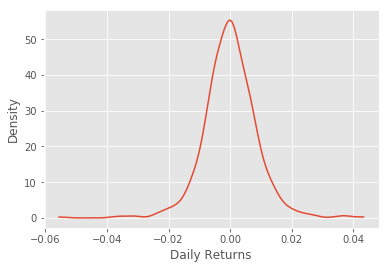

In [37]:
def density_plot(data): 
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.show()
    
first = list(frames.keys())[0]
print(first)
test = frames[first]
test['DlyReturnShifted'] = wins(test['DlyReturnShifted'],-0.1,0.1)
density_plot(test['DlyReturnShifted'])

In [38]:
def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n):
    return list(filter(lambda x: x in [*risk_names, *alpha_names], n))

def estimate_factor_returns(df): 
    ## here we would build universe based on filters 
    estu = df.copy(deep=True)
  
    ## winsorize returns for fitting 
    #estu['DlyReturnShifted'] = wins(estu['DlyReturnShifted'], -0.25, 0.25)
  
    all_factors = factors_from_names(list(df))
    form = get_formula(all_factors, "DlyReturnShifted")
    model = ols(form, data=estu)
    results = model.fit()
    return results

In [39]:
facret = OrderedDict()

for date in tqdm(frames):
    facret[date] = estimate_factor_returns(frames[date]).params

100%|██████████| 137/137 [00:01<00:00, 96.77it/s] 


In [40]:
for date in facret:
    print(date)
    print(facret[date].head())
    print(facret[date].tail())
    break

20130701
factor_0   -0.007951
factor_1    0.016480
factor_2    0.050956
factor_3    0.001288
factor_4   -0.007537
dtype: float64
factor_2             0.050956
factor_3             0.001288
factor_4            -0.007537
mean_reversion      -0.000255
smoothed_momentum    0.000183
dtype: float64


In [41]:
my_dates = sorted(list(map(lambda date: pd.to_datetime(date, format='%Y%m%d'), frames.keys())))
my_dates[:5]

[Timestamp('2013-07-01 00:00:00'),
 Timestamp('2013-07-02 00:00:00'),
 Timestamp('2013-07-03 00:00:00'),
 Timestamp('2013-07-05 00:00:00'),
 Timestamp('2013-07-08 00:00:00')]

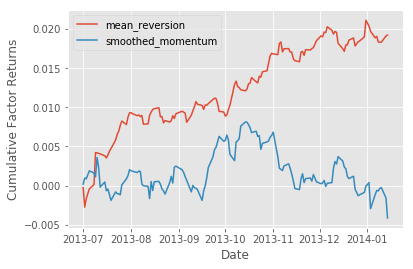

In [42]:
facret_df = pd.DataFrame(index = my_dates)
for date_ in my_dates: 
    for alp in alpha_names: 
        facret_df.at[date_, alp] = facret[date_.strftime('%Y%m%d')][alp]

for column in facret_df.columns:
    plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

Neither of these "alpha" factors do well after we take into account risk factors (mean reversion even only goes up 2%) so i will create an artifical factor that is basically be the average 5 day rolling return of a portfolio that goes long the best stocks over the period and shorts the worst over the 5 day period.

In [69]:
def create_artificial_alpha_factor(window_length, prices, sector_data):
    rolling = prices.pct_change().dropna().rolling(window_length).mean().dropna()
    winners = rolling[rolling > 0].mean(axis=1)
    losers = rolling[rolling <= 0].mean(axis=1)
    result = winners - losers
    return result
#    sectors = sector_data.unique()
#     df = prices.pct_change(window_length).dropna()
#     for sector in sectors:
#         col_filter = sector_data[sector_data==sector].index
#         means = df.loc[:, col_filter].mean(axis=1)
#         df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
#     ranked = df.rank(axis=1, method='first', ascending=False)
#     means = ranked.mean(axis=1)
#     stds = ranked.std(axis=1)
#     demeaned = ranked.subtract(means, axis=0)
#     zscored = demeaned.div(stds, axis=0)
#     return zscored

In [70]:
r = create_artificial_alpha_factor(5, p, sector_data)
r.head()

Date
2011-01-12    0.009145
2011-01-13    0.008631
2011-01-14    0.009908
2011-01-18    0.010752
2011-01-19    0.008628
dtype: float64

In [46]:
def clean_nas(df): 
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for numeric_column in numeric_columns: 
        df[numeric_column] = np.nan_to_num(df[numeric_column])
    
    return df

In [47]:
previous_holdings = pd.DataFrame(data = {"ticker" : ["CSCO"], "h.opt.previous" : np.array(0)})
df = frames[my_dates[0].strftime('%Y%m%d')]
print(df.head())

df = df.merge(previous_holdings, how = 'left', on = 'ticker')
df = clean_nas(df)
df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])

  ticker  factor_0  factor_1  factor_2  factor_3  factor_4  total_var  \
0   CSCO -0.033154  0.045992  0.053286 -0.024285 -0.000190   0.065043   
1    UAL -0.029945 -0.065404 -0.022871  0.067353  0.061500   0.127026   
2   TROW -0.043606 -0.010007 -0.011194 -0.015311 -0.006167   0.041157   
3   ISRG -0.028666 -0.012032  0.063054  0.003174 -0.034397   0.098984   
4    NVR -0.026641 -0.055110 -0.021251  0.050182 -0.003217   0.053339   

   spec_var  mean_reversion  smoothed_momentum  DlyReturnShifted  DataDate  
0  0.043660        0.028030           1.093189          0.011102  20130701  
1  0.101941       -0.836243           0.504549         -0.008257  20130701  
2  0.013956        1.153922          -0.051389          0.000946  20130701  
3  0.082745        0.252274          -1.714532         -0.002933  20130701  
4  0.036845        1.466929          -0.747480          0.001142  20130701  


KeyError: 'SpecRisk'

In [59]:
factor_data = {}
start = pd.to_datetime('2015-05-01')
end = pd.to_datetime('2015-09-30')
factor_data['momentum'] = momentum.loc[start:end,:].stack()
factor_data['momentum'].head()
factor_prices = p.loc[start:end, :]
factor_returns = al.utils.get_clean_factor_and_forward_returns(factor=factor_data['momentum'], prices=factor_prices, periods=[1])

Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


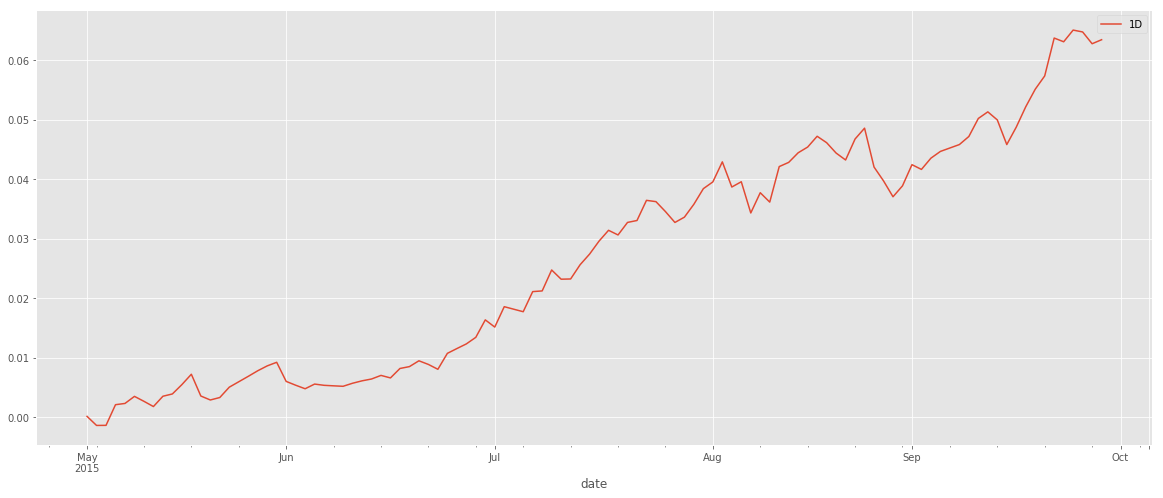

In [162]:
figsize(20,8)
factor_returns_data = al.performance.factor_returns(factor_returns)
factor_returns_data.cumsum().plot()

In [92]:
sharpe = factor_returns_data.mean() * np.sqrt(252) / factor_returns_data.std()
sharpe

1D    1.649287
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1251a5b38>,
      dtype=object)

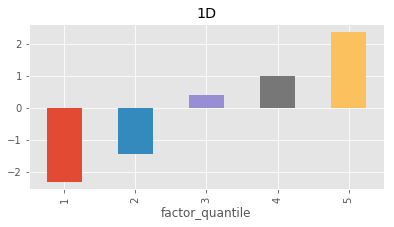

In [93]:

qr_factor_returns = al.performance.mean_return_by_quantile(factor_returns)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

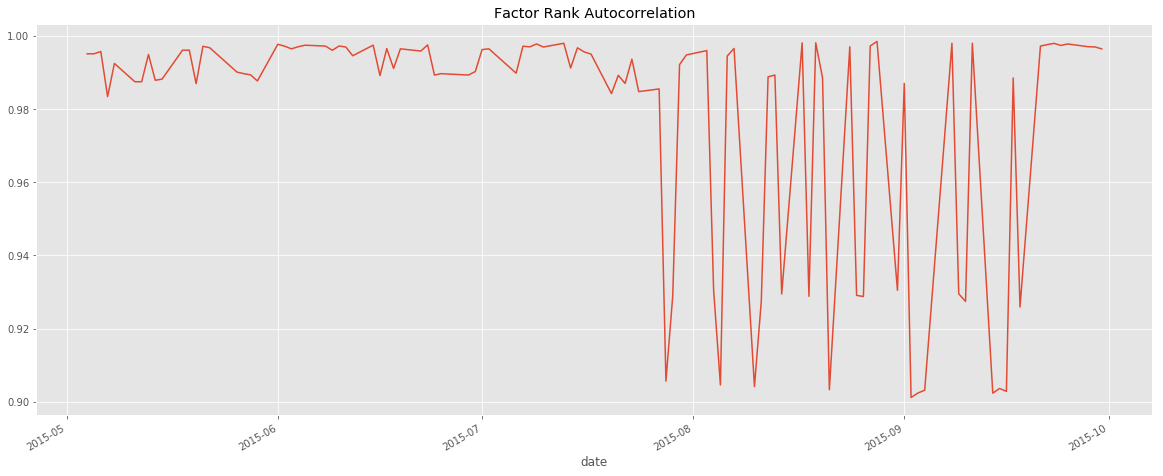

In [27]:
ls_FRA = al.performance.factor_rank_autocorrelation(factor_returns)

ls_FRA.plot(title="Factor Rank Autocorrelation")

In [28]:
rets_index = rets.index[-1]
alpha_vector = momentum.loc[rets_index, :]
print(type(alpha_vector))
len(alpha_vector)

<class 'pandas.core.series.Series'>


762

In [29]:
previous = np.asarray(holdings) / 50000000
len(previous)
previous[:5]

array([0.00131234, 0.00131234, 0.00131234, 0.00131234, 0.00131234])

In [30]:
class OptimalHoldingsCVX:

    def __init__(self, risk_model, alpha_vector, previous, risk_cap=0.05, factor_max=10.0, gvm=50e6, lambda_reg=0.00,
                 factor_min=-10.0, weights_max=0.55, weights_min=-0.55, risk_aversion=1.0e-6):

        self.risk_model = risk_model
        self.alpha_vector = alpha_vector
        self.previous = previous
        self.risk_cap = risk_cap
        self.factor_min = factor_min
        self.factor_max = factor_max
        self.weights_min = weights_min
        self.weights_max = weights_max
        self.risk_aversion = risk_aversion
        self.gmv = gvm
        self.lambda_reg = lambda_reg

    def _get_obj(self, h1):
        ra = self.risk_aversion
        Q = self.risk_model.Q # Q is k x N
        ivv = self.risk_model.i_var_vector
        av = -self.alpha_vector
        #h0 = self.previous.flatten()
        #lv = np.ones((len(av), 1)) * 0.1/2000000
        #obj_func = cvx.Minimize(np.array(av.T) * h1 + self.lambda_reg * cvx.norm(h1, 2) + (h1-h0)**2 @ lv)
        obj_func = cvx.Minimize(np.array(av.T) * h1 + self.lambda_reg * cvx.norm(h1, 2))

        return obj_func

    def _get_constraints(self, h1, risk):
        c = []
        factor_exposures = self.risk_model.factor_exposures
        c.append(risk <= self.risk_cap**2)
        c.append(factor_exposures.T @ h1 <= self.factor_max)
        c.append(factor_exposures.T @ h1 >= self.factor_min)
        c.append(sum(h1) == 0)
        c.append(sum(cvx.abs(h1)) <= 1.0)
        c.append(h1 >= self.weights_min)
        c.append(h1 <= self.weights_max)
        return c

    def get_risk(self, h1):
        av_index = self.alpha_vector.index
        Q = self.risk_model.Q
        ivv = self.risk_model.i_var_vector
        risk = cvx.sum((Q @ (h1 / self.gmv))**2) + ((h1/self.gmv)**2) @ ivv
        return risk
#         ivm = self.risk_model.i_var_matrix.loc[av_index].values
#         f = self.risk_model.factor_exposures.loc[av_index].values.T @ h1
#         X = self.risk_model.factor_cov_matrix
#         risk = cvx.quad_form(f, X) + cvx.quad_form(h1, ivm)
#         return risk

    def find(self):
        h1 = cvx.Variable(len(self.alpha_vector))
        risk = self.get_risk(h1)
        obj_func = self._get_obj(h1)
        constraints = self._get_constraints(h1, risk)
        prob = cvx.Problem(obj_func, constraints)
        prob.solve(max_iters=100, verbose=True)
        optimal_weights = np.asarray(h1.value).flatten()
        df = pd.DataFrame(optimal_weights, index=self.alpha_vector.index)
        return df

In [31]:
oh = OptimalHoldingsCVX(risk_model, alpha_vector, previous, lambda_reg=5.0)
optimal_weights = oh.find()


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.305e-17  -2.683e+03  +1e+06  8e-01  7e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -3.988e+01  -1.421e+03  +7e+05  3e-01  4e-01  6e-01  6e-01  0.5134  1e-01   2  2  2 |  0  0
 2  -3.511e+01  -9.544e+02  +4e+05  2e-01  3e-01  5e-01  4e-01  0.5426  3e-01   3  2  2 |  0  0
 3  -1.654e+01  -1.152e+02  +5e+04  2e-02  3e-02  5e-02  4e-02  0.9025  3e-02   3  2  2 |  0  0
 4  -9.253e+00  -3.206e+01  +1e+04  4e-03  7e-03  1e-02  1e-02  0.8105  4e-02   4  3  3 |  0  0
 5  -1.740e+00  -2.804e+00  +5e+02  2e-04  3e-04  4e-04  5e-04  0.9544  3e-03   5  4  4 |  0  0
 6  -1.303e+00  -1.410e+00  +5e+01  2e-05  2e-05  6e-05  5e-05  0.9509  5e-02   1  1  1 |  0  0
 7  -1.188e+00  -1.197e+00  +4e+00  2e-06  2e-06  5e-06  4e-06  0.9408  2e-02   4  3  3 |  0  0
 8  -1.177e+00  -1.177e+00  +2e-01  7e-08  8e-

/Users/richard.wuebker/.pyenv/versions/zipline/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


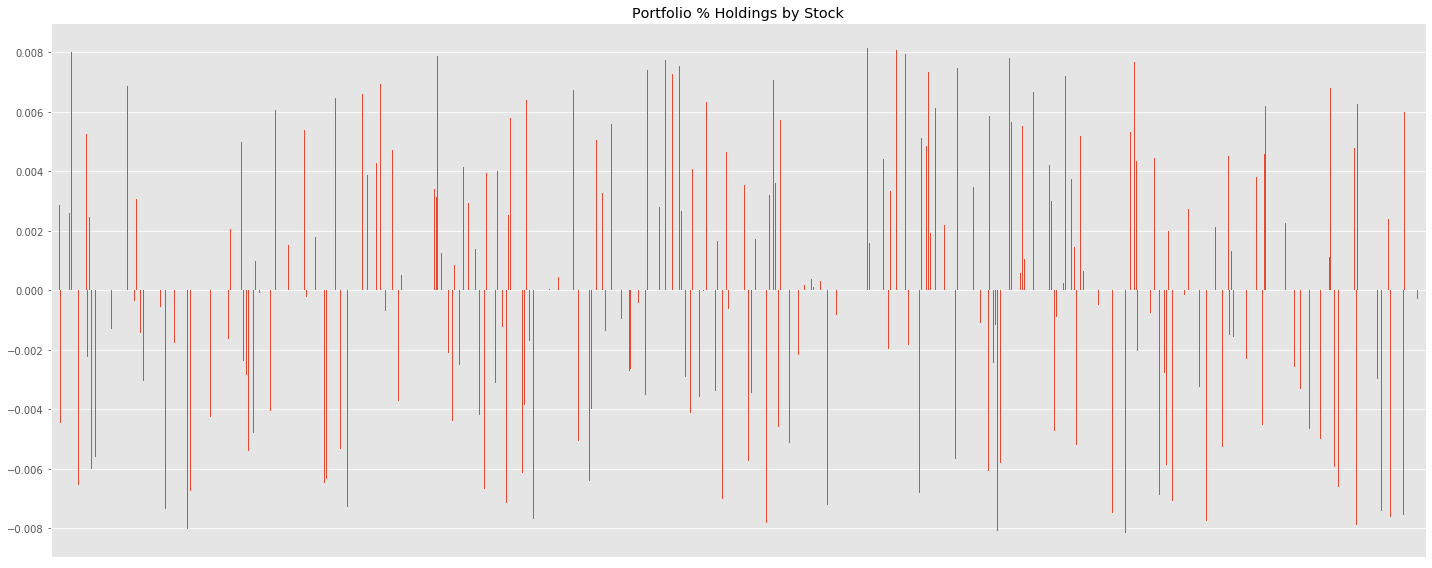

In [32]:
figsize(20, 8)
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.tight_layout()


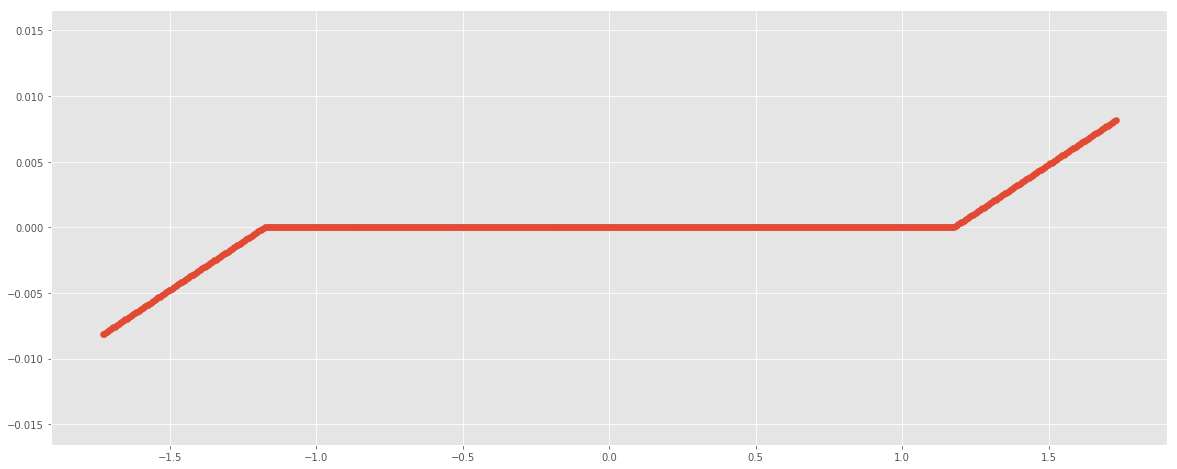

In [33]:
plt.scatter(alpha_vector, optimal_weights)

In [34]:
print(len(alpha_vector))
print(len(optimal_weights))
print(alpha_vector.head())
print(optimal_weights.head())

762
762
ticker
CSCO   -0.343003
UAL    -0.679191
TROW   -0.992664
ISRG   -0.892716
NVR     1.369740
Name: 2015-12-31 00:00:00, dtype: float64
                   0
ticker              
CSCO   -1.376392e-15
UAL    -3.726972e-15
TROW   -1.236365e-14
ISRG   -7.625866e-15
NVR     2.855906e-03


In [35]:
def get_transfer_coefficient(a, b):
    tc, p = spearmanr(a, b)
    return tc

In [36]:
av = alpha_vector.values
r = optimal_weights.values.flatten()
print(av.shape)
print(r.shape)

(762,)
(762,)


In [37]:
get_transfer_coefficient(av, r)

0.999999240592099

In [38]:
class OptimalHoldingsCVX:

    def __init__(self, risk_model, alpha_vector, previous, risk_cap=0.05, factor_max=10.0, gmv=5e3, lambda_reg=0.00,
                 factor_min=-10.0, weights_max=0.50, weights_min=-0.50, risk_aversion=1.0e-6):

        self.risk_model = risk_model
        self.alpha_vector = alpha_vector
        self.previous = previous
        self.risk_cap = risk_cap
        self.factor_min = factor_min
        self.factor_max = factor_max
        self.weights_min = weights_min * gmv
        self.weights_max = weights_max * gmv
        self.risk_aversion = risk_aversion
        self.gmv = gmv
        self.lambda_reg = lambda_reg

    def _get_obj(self, h1):
        ra = self.risk_aversion
        Q = self.risk_model.Q # Q is k x N
        ivv = self.risk_model.i_var_vector
        av = -self.alpha_vector
        h0 = self.previous.flatten()
        lv = np.ones((len(av), 1)) * 0.1/25000000
        #obj_func = cvx.Minimize(np.array(av.T) * h1 + self.lambda_reg * cvx.norm(h1, 2) + (h1-h0)**2 @ lv)
        obj_func = cvx.Minimize(np.array(av.T) * h1 + self.lambda_reg * cvx.norm(h1, 2))
        return obj_func

    def _get_constraints(self, h1, risk):
        c = []
        factor_exposures = self.risk_model.factor_exposures
        c.append(risk <= self.risk_cap**2)
        #c.append(factor_exposures.T @ h1 <= self.factor_max)
        #c.append(factor_exposures.T @ h1 >= self.factor_min)
        c.append(sum(h1) == 0)
        c.append(sum(cvx.abs(h1)) <= self.gmv)
        c.append(h1 >= self.weights_min)
        c.append(h1 <= self.weights_max)
        return c

    def get_risk(self, h1):
#         av_index = self.alpha_vector.index
#         Q = self.risk_model.Q
#         ivv = self.risk_model.i_var_vector
#         risk = cvx.sum((Q @ (h1 / self.gmv))**2) + ((h1/self.gmv)**2) @ ivv
#         return risk
        av_index = self.alpha_vector.index
        ivm = self.risk_model.i_var_matrix.loc[av_index].values
        f = self.risk_model.factor_exposures.loc[av_index].values.T @ h1
        X = self.risk_model.factor_cov_matrix
        risk = cvx.quad_form(f, X) + cvx.quad_form(h1/self.gmv, ivm)
        return risk

    def find(self):
        h1 = cvx.Variable(len(self.alpha_vector))
        risk = self.get_risk(h1)
        obj_func = self._get_obj(h1)
        constraints = self._get_constraints(h1, risk)
        prob = cvx.Problem(obj_func, constraints)
        prob.solve(max_iters=1000, verbose=True)
        optimal_weights = np.asarray(h1.value).flatten()
        df = pd.DataFrame(optimal_weights, index=self.alpha_vector.index, columns=['holdings'])
        return df

In [39]:
initial_holdings = np.zeros((len(alpha_vector), 1))  / len(alpha_vector)
print(initial_holdings.shape)
initial_holdings[:5]

(762, 1)


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [40]:
oh = OptimalHoldingsCVX(risk_model, alpha_vector, initial_holdings, lambda_reg=5.0, gmv=50000)
optimal_weights = oh.find()


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.822e+07  +4e+07  6e-04  7e-01  1e+00  3e+01    ---    ---    1  1  - |  -  - 
 1  -8.130e-01  -5.994e+06  +6e+06  9e-05  1e-01  3e-01  5e+00  0.8465  3e-03   2  1  1 |  0  0
 2  -6.852e+00  -4.579e+06  +5e+06  7e-05  1e-01  4e-01  4e+00  0.3035  1e-01   2  1  1 |  0  0
 3  -2.453e+01  -6.371e+05  +6e+05  9e-06  1e-02  6e-02  5e-01  0.8619  1e-03   2  1  2 |  0  0
 4  -3.626e+01  -6.428e+05  +6e+05  1e-05  1e-02  7e-02  5e-01  0.0170  8e-01   3  3  3 |  0  0
 5  -4.989e+01  -6.514e+05  +6e+05  1e-05  2e-02  8e-02  5e-01  0.0233  8e-01   3  3  3 |  0  0
 6  -5.787e+01  -6.601e+05  +6e+05  1e-05  2e-02  9e-02  5e-01  0.0154  9e-01   3  3  3 |  0  0
 7  -8.151e+01  -6.778e+05  +6e+05  1e-05  2e-02  1e-01  5e-01  0.0500  8e-01   3  3  3 |  0  0
 8  -1.125e+02  -7.047e+05  +6e+05  1e-05  2e-

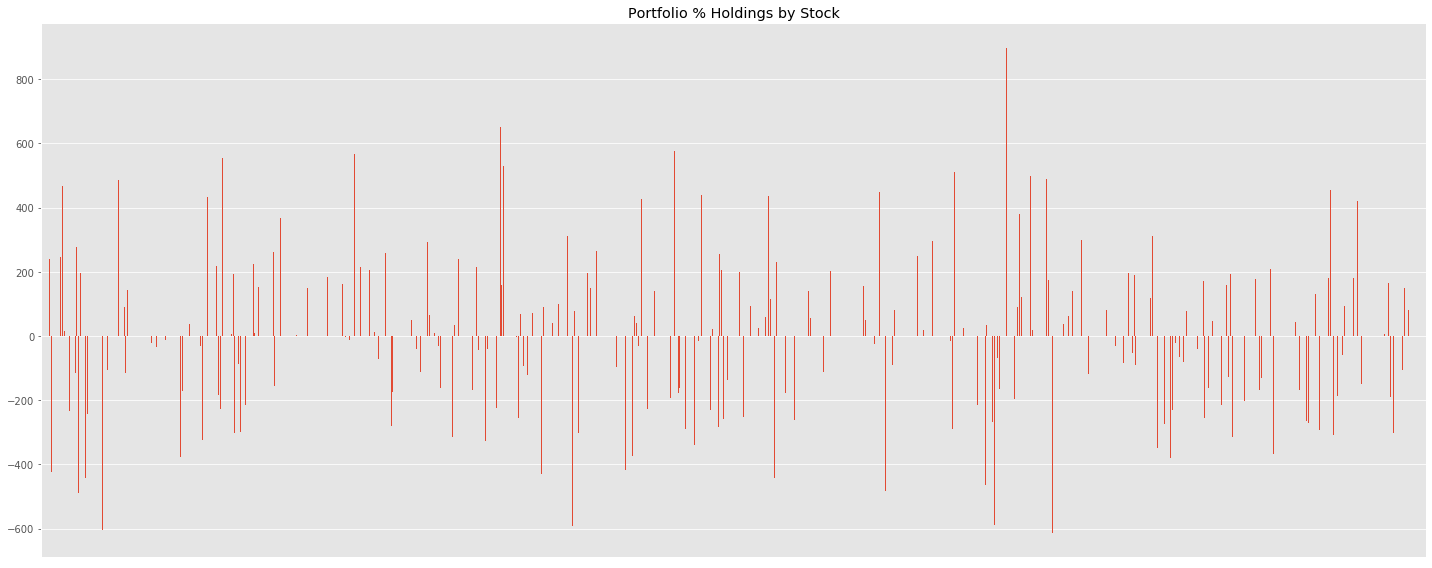

In [41]:
figsize(20, 8)
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.tight_layout()

In [42]:
optimal_weights.head()

,holdings
ticker,
CSCO,-1.207775e-08
UAL,2.076662e-09
TROW,-2.132198e-07
ISRG,-5.073925e-06
NVR,2.384272e+02


In [43]:
print('average long holdings: ', optimal_weights.loc[optimal_weights['holdings'] > 0].mean().values[0].round(4))
print('max long holding: ', optimal_weights.loc[optimal_weights['holdings'] > 0].max().values[0].round(4))
print('average short holdings: ', optimal_weights.loc[optimal_weights['holdings'] <= 0].mean().values[0].round(4))
print('max short holding: ', optimal_weights.loc[optimal_weights['holdings'] < 0].min().values[0].round(4))
print('gmv = ', optimal_weights.loc[optimal_weights['holdings'] > 0].sum() + optimal_weights.loc[optimal_weights['holdings'] < 0].abs().sum().values[0])

average long holdings:  65.6168
max long holding:  898.1173
average short holdings:  -65.6168
max short holding:  -614.0537
gmv =  holdings    49999.999972
dtype: float64


In [44]:
np.sqrt(risk_model.predict_portfolio_risk_opt(optimal_weights.values.flatten(), 50000))

this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)


0.01716723394770366

In [45]:
def backtest(test_period, holdings, returns, alpha, gmv):
    port = {}
    for d in tqdm(test_period):
        str_d = d.strftime('%Y%m%d')
        end_date = d
        start_date = d - dt.timedelta(days=365)
        av = alpha.loc[end_date, :]
        rets = returns.loc[start_date:end_date, :]
        lambda_vector = np.ones((1, len(av))) * 0.1/25000000
        rm = RiskModelPCA(rets, 20)
        start = time.time()
        oh = OptimalHoldingsCVX(rm, av, holdings, lambda_reg=10.0, gmv=gmv)
        end = time.time()
        start = time.time()
        new_holdings = oh.find()
        end = time.time()
        data = np.matmul(rm.factor_exposures.values.T, new_holdings.values).flatten()
        risk_exposures = pd.Series(data=data.T, index=rm.factor_exposures.columns.values) 
        alpha_exposures = pd.Series(av * new_holdings['holdings'], index=av.index) 
        transaction_costs = np.dot(lambda_vector, (new_holdings - holdings)**2).flatten()
        print('TRANSACTION COSTS: ', transaction_costs)
        result = {
            'h.opt.previous': holdings,
            'h.opt': new_holdings,
            'risk.exposures': risk_exposures,
            'alpha.exposures': alpha_exposures,
            't.costs': transaction_costs,
            'factor.exposures': rm.factor_exposures,
            'alpha.vector': av,
            'rm': risk_model
        }
        print('RISK: ', np.sqrt(rm.predict_portfolio_risk_opt(new_holdings.values.flatten(), gmv)))
        port[str_d] = result
        holdings = np.asarray(new_holdings)
    return port

In [46]:
test_period = momentum.loc['2015-05-01':'2016-04-30'].index
print(test_period[:5])
initial_holdings = np.zeros((len(momentum.columns), 1))
port = backtest(test_period, initial_holdings, returns, momentum, 300000000)

  0%|          | 0/252 [00:00<?, ?it/s]

DatetimeIndex(['2015-05-01', '2015-05-04', '2015-05-05', '2015-05-06',
               '2015-05-07'],
              dtype='datetime64[ns]', name='Date', freq=None)

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.753e+00  -2.275e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  1  1 |  0  0
 2  +6.920e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.226e+00  -1.583e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3042  3e-04   1  0  1 |  0  0
 4  +8.235e+00  -1.571e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0085  4e-02   1  1  1 |  0  0
 5  -4.431e+01  -1.020e+11  +1e+11  4e-08  2e-01  1e+02  9e+04  0.3512  1e-03   1  1  1 |  0  0
 6  -3.940e+02  -1.829e+10  +2e+10  8e-09  3e-02  6e+01  2e+04  0.8213  5e-

  0%|          | 1/252 [00:35<2:27:32, 35.27s/it]

31  -2.191e+08  -2.191e+08  +1e+00  2e-14  2e-09  8e-03  9e-07  0.9890  3e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.7e-09, reltol=4.6e-09, abstol=1.0e+00).
Runtime: 22.313365 seconds.

TRANSACTION COSTS:  [1390841.77659982]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012185019251455011

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.736e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  1  1 |  0  0
 2  +6.879e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.741e+00  -1.615e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2903  3e-04   1  0  1 |  0  0
 4  +1.060e+01  -1.602e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0087  4e-02   1  1  1 |  0  0
 5  -4.215e+01  -1.0

  1%|          | 2/252 [01:09<2:26:06, 35.07s/it]

31  -2.183e+08  -2.183e+08  +4e+00  2e-14  3e-09  2e-02  4e-06  0.8802  7e-02   1  1  1 |  0  0
32  -2.183e+08  -2.183e+08  +1e-01  2e-14  7e-10  7e-04  1e-07  0.9799  8e-03   1  1  1 |  0  0

OPTIMAL (within feastol=7.1e-10, reltol=5.6e-10, abstol=1.2e-01).
Runtime: 21.875708 seconds.

TRANSACTION COSTS:  [46564.70661914]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012055388069123534

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.756e+00  -2.275e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  0  1 |  0  0
 2  +6.916e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.586e+00  -1.604e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2949  3e-04   1  0  1 |  0  0
 4  +9.666e+00  -1.591

  1%|          | 3/252 [01:47<2:28:35, 35.81s/it]

TRANSACTION COSTS:  [34218.52867526]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011872864432426487

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.783e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  1  1 |  0  0
 2  +6.966e+00  -2.274e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.146e+00  -1.577e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3067  3e-04   1  0  1 |  0  0
 4  +7.268e+00  -1.563e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0096  4e-02   1  1  1 |  0  0
 5  -6.063e+01  -9.307e+10  +9e+10  4e-08  2e-01  1e+02  8e+04  0.4051  1e-03   1  1  1 |  0  0
 6  -4.392e+02  -1.586e+10  +2e+10  7e-09  3e-02  5e+01  1e+04  0.8301  5e-04   1  1  1 |  0  0
 7  -9.100e+02  -1.575

  2%|▏         | 4/252 [02:25<2:30:49, 36.49s/it]

39  -2.236e+08  -2.236e+08  +7e-01  1e-14  1e-09  1e-02  6e-07  0.8821  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.2e-09, reltol=3.2e-09, abstol=7.2e-01).
Runtime: 25.416090 seconds.

TRANSACTION COSTS:  [49784.29153406]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01162539075978378

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.785e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  1  1 |  0  0
 2  +6.970e+00  -2.274e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.174e+00  -1.578e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3062  3e-04   1  0  1 |  0  0
 4  +7.480e+00  -1.564e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0094  4e-02   1  1  1 |  0  0
 5  -6.300e+01  -9.089e

  2%|▏         | 5/252 [03:01<2:29:36, 36.34s/it]

35  -2.223e+08  -2.223e+08  +4e-01  1e-14  1e-09  4e-03  3e-07  0.9568  5e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.2e-09, reltol=1.7e-09, abstol=3.8e-01).
Runtime: 23.365741 seconds.

TRANSACTION COSTS:  [38499.31450467]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011553818910262376

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.746e+00  -2.275e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0079  4e-03   1  0  1 |  0  0
 2  +6.891e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.891e+00  -1.624e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2864  3e-04   1  0  1 |  0  0
 4  +1.096e+01  -1.610e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0094  4e-02   1  1  1 |  0  0
 5  -5.552e+01  -9.357

  2%|▏         | 6/252 [03:40<2:31:41, 37.00s/it]

39  -2.201e+08  -2.201e+08  +1e+00  2e-14  2e-09  2e-02  1e-06  0.9549  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.1e-09, reltol=6.1e-09, abstol=1.4e+00).
Runtime: 25.889373 seconds.

TRANSACTION COSTS:  [48139.57242635]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011695305903453157

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.754e+00  -2.275e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  1  1 |  0  0
 2  +6.901e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.101e+00  -1.635e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2815  3e-04   1  0  1 |  0  0
 4  +1.183e+01  -1.620e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0097  4e-02   1  1  1 |  0  0
 5  -5.921e+01  -9.096

  3%|▎         | 7/252 [04:16<2:30:31, 36.86s/it]


OPTIMAL (within feastol=6.3e-10, reltol=7.5e-10, abstol=1.7e-01).
Runtime: 23.844137 seconds.

TRANSACTION COSTS:  [36085.35508792]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011808497204468173

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.759e+00  -2.275e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  1  1 |  0  0
 2  +6.909e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.077e+00  -1.633e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2822  3e-04   1  0  1 |  0  0
 4  +1.174e+01  -1.619e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0094  4e-02   1  1  1 |  0  0
 5  -5.425e+01  -9.422e+10  +9e+10  4e-08  2e-01  1e+02  8e+04  0.4187  1e-03   1  1  1 |  0  0
 6  -4.269e+02  -1.518

  3%|▎         | 8/252 [04:53<2:29:25, 36.74s/it]

35  -2.199e+08  -2.199e+08  +6e+01  2e-14  2e-08  6e-01  5e-05  0.9295  2e-02   1  1  1 |  0  0
36  -2.199e+08  -2.199e+08  +2e+00  2e-14  3e-09  2e-02  2e-06  0.9890  3e-02   1  1  1 |  0  0
37  -2.199e+08  -2.199e+08  +1e-01  2e-14  7e-10  1e-03  9e-08  0.9554  3e-03   1  1  1 |  0  0

OPTIMAL (within feastol=7.2e-10, reltol=5.0e-10, abstol=1.1e-01).
Runtime: 23.906255 seconds.

TRANSACTION COSTS:  [31981.28619775]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01163366258760272

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.765e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  0  1 |  0  0
 2  +6.918e+00  -2.274e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +7.069e+00  -1.632e

  4%|▎         | 9/252 [05:30<2:30:12, 37.09s/it]

38  -2.198e+08  -2.198e+08  +2e+01  2e-14  4e-09  2e-01  1e-05  0.9028  1e-02   1  1  1 |  0  0
39  -2.198e+08  -2.198e+08  +1e+00  2e-14  8e-10  1e-02  1e-06  0.9491  4e-02   1  1  1 |  0  0

OPTIMAL (within feastol=7.6e-10, reltol=6.5e-09, abstol=1.4e+00).
Runtime: 25.195449 seconds.

TRANSACTION COSTS:  [26354.47958205]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011843464012136422

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.765e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  0  1 |  0  0
 2  +6.918e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.153e+00  -1.637e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2806  3e-04   1  0  1 |  0  0
 4  +1.213e+01  -1.622

  4%|▍         | 10/252 [06:11<2:33:41, 38.11s/it]

39  -2.197e+08  -2.197e+08  +4e+00  2e-14  2e-09  8e-02  4e-06  0.9237  4e-02   1  1  1 |  0  0
40  -2.197e+08  -2.197e+08  +1e-01  2e-14  7e-10  3e-03  1e-07  0.9686  3e-03   1  1  1 |  0  0

OPTIMAL (within feastol=6.6e-10, reltol=6.6e-10, abstol=1.5e-01).
Runtime: 27.913876 seconds.

TRANSACTION COSTS:  [27951.33476359]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011995652298334299

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.766e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  1  1 |  0  0
 2  +6.920e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +7.151e+00  -1.636e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2807  3e-04   1  0  1 |  0  0
 4  +1.220e+01  -1.623

  4%|▍         | 11/252 [06:49<2:33:02, 38.10s/it]

37  -2.185e+08  -2.185e+08  +2e+01  2e-14  4e-09  2e-01  2e-05  0.9237  5e-03   1  1  1 |  0  0
38  -2.185e+08  -2.185e+08  +9e-01  2e-14  6e-10  1e-02  8e-07  0.9739  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=6.0e-10, reltol=4.0e-09, abstol=8.8e-01).
Runtime: 25.303442 seconds.

TRANSACTION COSTS:  [21977.35349858]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011795642677335618

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.769e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  0  1 |  0  0
 2  +6.929e+00  -2.274e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.951e+00  -1.625e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2859  3e-04   1  0  1 |  0  0
 4  +1.121e+01  -1.611

  5%|▍         | 12/252 [07:27<2:32:02, 38.01s/it]


Runtime: 25.119868 seconds.

TRANSACTION COSTS:  [18439.1226252]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011814495114944536

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.768e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  1  1 |  0  0
 2  +6.930e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.939e+00  -1.623e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2864  3e-04   1  0  1 |  0  0
 4  +1.129e+01  -1.610e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0090  4e-02   1  1  1 |  0  0
 5  -5.137e+01  -9.592e+10  +1e+11  4e-08  2e-01  1e+02  8e+04  0.4049  1e-03   1  1  1 |  0  0
 6  -4.194e+02  -1.505e+10  +2e+10  6e-09  3e-02  5e+01  1e+04  0.8435  4e-04   1  1  1 |

  5%|▌         | 13/252 [08:05<2:32:06, 38.19s/it]

38  -2.180e+08  -2.180e+08  +2e-01  2e-14  1e-09  2e-03  2e-07  0.9642  7e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.0e-09, reltol=1.0e-09, abstol=2.2e-01).
Runtime: 25.897237 seconds.

TRANSACTION COSTS:  [17099.37465504]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011779441486512282

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.766e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  0  1 |  0  0
 2  +6.926e+00  -2.274e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.793e+00  -1.616e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2898  3e-04   1  0  1 |  0  0
 4  +1.029e+01  -1.601e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0099  4e-02   1  1  1 |  0  0
 5  -6.129e+01  -9.088

  6%|▌         | 14/252 [08:41<2:27:56, 37.29s/it]

34  -2.225e+08  -2.225e+08  +3e+00  2e-14  2e-09  3e-02  3e-06  0.9838  5e-02   1  1  1 |  0  0
35  -2.225e+08  -2.225e+08  +1e-01  2e-14  7e-10  9e-04  9e-08  0.9717  4e-03   1  1  1 |  0  0

OPTIMAL (within feastol=6.9e-10, reltol=4.6e-10, abstol=1.0e-01).
Runtime: 22.553754 seconds.

TRANSACTION COSTS:  [38162.24551738]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011913539680728369

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.741e+00  -2.275e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  0  1 |  0  0
 2  +6.886e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.756e+00  -1.616e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2899  3e-04   1  0  1 |  0  0
 4  +1.025e+01  -1.601

  6%|▌         | 15/252 [09:18<2:27:34, 37.36s/it]


OPTIMAL (within feastol=1.1e-09, reltol=8.2e-10, abstol=1.8e-01).
Runtime: 24.781792 seconds.

TRANSACTION COSTS:  [14749.61171844]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011857369643774455

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.757e+00  -2.275e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  1  1 |  0  0
 2  +6.917e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.525e+00  -1.601e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2963  3e-04   1  0  1 |  0  0
 4  +9.061e+00  -1.586e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0100  4e-02   1  1  1 |  0  0
 5  -6.191e+01  -9.125e+10  +9e+10  4e-08  2e-01  1e+02  8e+04  0.4253  9e-04   1  1  1 |  0  0
 6  -4.416e+02  -1.633

  6%|▋         | 16/252 [09:53<2:24:15, 36.67s/it]

34  -2.234e+08  -2.235e+08  +3e+01  2e-14  1e-08  4e-01  3e-05  0.8964  1e-01   1  1  1 |  0  0
35  -2.234e+08  -2.234e+08  +2e+00  2e-14  4e-09  2e-02  1e-06  0.9453  4e-03   1  1  1 |  0  0

OPTIMAL (within feastol=4.0e-09, reltol=7.8e-09, abstol=1.7e+00).
Runtime: 22.459110 seconds.

TRANSACTION COSTS:  [14789.3118742]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011876598739715116

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.741e+00  -2.275e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  0  1 |  0  0
 2  +6.889e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.563e+00  -1.605e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2948  3e-04   1  0  1 |  0  0
 4  +9.431e+00  -1.590e

  7%|▋         | 17/252 [10:31<2:25:00, 37.02s/it]

38  -2.206e+08  -2.206e+08  +3e+00  2e-14  1e-09  5e-02  3e-06  0.9767  4e-02   1  1  1 |  0  0
39  -2.206e+08  -2.206e+08  +1e-01  2e-14  7e-10  2e-03  1e-07  0.9665  3e-03   1  1  1 |  0  0

OPTIMAL (within feastol=6.5e-10, reltol=5.6e-10, abstol=1.2e-01).
Runtime: 25.393694 seconds.

TRANSACTION COSTS:  [24172.98059498]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011730332042495496

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.735e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  1  1 |  0  0
 2  +6.880e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +6.612e+00  -1.608e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2935  3e-04   1  0  1 |  0  0
 4  +9.662e+00  -1.593

  7%|▋         | 18/252 [11:08<2:24:08, 36.96s/it]

37  -2.228e+08  -2.228e+08  +2e-01  2e-14  7e-10  2e-03  2e-07  0.9783  3e-02   1  1  1 |  0  0

OPTIMAL (within feastol=6.6e-10, reltol=8.4e-10, abstol=1.9e-01).
Runtime: 24.222696 seconds.

TRANSACTION COSTS:  [24162.60757905]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011917645813521607

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.751e+00  -2.275e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0079  3e-03   1  0  1 |  0  0
 2  +6.907e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.536e+00  -1.602e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2959  3e-04   1  0  1 |  0  0
 4  +9.267e+00  -1.588e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0096  4e-02   1  1  1 |  0  0
 5  -5.798e+01  -9.329

  8%|▊         | 19/252 [11:45<2:23:41, 37.00s/it]

36  -2.219e+08  -2.219e+08  +2e+01  2e-14  3e-09  1e-01  2e-05  0.9703  6e-02   1  1  1 |  0  0
37  -2.219e+08  -2.219e+08  +1e+00  2e-14  2e-09  7e-03  1e-06  0.9520  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.6e-09, reltol=6.4e-09, abstol=1.4e+00).
Runtime: 23.579996 seconds.

TRANSACTION COSTS:  [20860.86036835]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011709014814761456

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.729e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0077  4e-03   1  1  1 |  0  0
 2  +6.864e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.845e+00  -1.622e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2872  3e-04   1  0  1 |  0  0
 4  +1.070e+01  -1.607

  8%|▊         | 20/252 [12:21<2:21:37, 36.63s/it]

33  -2.237e+08  -2.237e+08  +5e+00  2e-14  6e-09  6e-02  4e-06  0.9145  8e-02   1  1  1 |  0  0
34  -2.237e+08  -2.237e+08  +5e-01  2e-14  1e-09  7e-03  5e-07  0.9521  7e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=2.4e-09, abstol=5.3e-01).
Runtime: 22.937839 seconds.

TRANSACTION COSTS:  [19329.18168267]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011932490777292012

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.737e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  0  1 |  0  0
 2  +6.878e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.801e+00  -1.619e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2886  3e-04   1  0  1 |  0  0
 4  +1.044e+01  -1.604

  8%|▊         | 21/252 [12:56<2:19:37, 36.27s/it]

35  -2.247e+08  -2.247e+08  +2e+00  2e-14  2e-09  2e-02  2e-06  0.8784  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.1e-09, reltol=9.1e-09, abstol=2.0e+00).
Runtime: 22.922366 seconds.

TRANSACTION COSTS:  [13756.86868239]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011944772503562646

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.739e+00  -2.275e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  1  1 |  0  0
 2  +6.882e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.713e+00  -1.614e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2907  3e-04   1  0  1 |  0  0
 4  +9.858e+00  -1.598e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0104  3e-02   1  1  1 |  0  0
 5  -6.272e+01  -9.052

  9%|▊         | 22/252 [13:31<2:17:27, 35.86s/it]

33  -2.262e+08  -2.262e+08  +9e+00  2e-14  5e-09  7e-02  8e-06  0.9855  2e-02   1  1  1 |  0  0
34  -2.262e+08  -2.262e+08  +4e-01  2e-14  1e-09  3e-03  4e-07  0.9566  5e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=2.0e-09, abstol=4.5e-01).
Runtime: 22.344065 seconds.

TRANSACTION COSTS:  [18629.94292333]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012065189719093644

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.754e+00  -2.275e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  0  1 |  0  0
 2  +6.910e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.524e+00  -1.602e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2960  3e-04   1  0  1 |  0  0
 4  +8.921e+00  -1.586

  9%|▉         | 23/252 [14:06<2:15:46, 35.58s/it]

35  -2.264e+08  -2.264e+08  +3e+00  2e-14  4e-09  3e-02  3e-06  0.9714  2e-02   1  1  1 |  0  0
36  -2.264e+08  -2.264e+08  +4e-01  2e-14  1e-09  4e-03  4e-07  0.9315  6e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.0e-09, reltol=1.9e-09, abstol=4.2e-01).
Runtime: 22.304096 seconds.

TRANSACTION COSTS:  [15939.51821916]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01205659376925801

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.764e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  0  1 |  0  0
 2  +6.930e+00  -2.274e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.367e+00  -1.591e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3004  3e-04   1  0  1 |  0  0
 4  +8.133e+00  -1.576e

 10%|▉         | 24/252 [14:40<2:13:59, 35.26s/it]

34  -2.271e+08  -2.271e+08  +5e-01  2e-14  1e-09  4e-03  5e-07  0.9779  8e-04   1  1  1 |  0  0

OPTIMAL (within feastol=1.2e-09, reltol=2.4e-09, abstol=5.4e-01).
Runtime: 21.896314 seconds.

TRANSACTION COSTS:  [19676.98634634]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011899121437353149

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.763e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  0  1 |  0  0
 2  +6.923e+00  -2.274e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +6.647e+00  -1.608e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2932  3e-04   1  0  1 |  0  0
 4  +9.416e+00  -1.592e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0104  3e-02   1  1  1 |  0  0
 5  -6.455e+01  -8.979

 10%|▉         | 25/252 [15:15<2:12:41, 35.07s/it]

33  -2.262e+08  -2.262e+08  +3e-01  2e-14  1e-09  3e-03  2e-07  0.9407  4e-02   2  1  1 |  0  0

OPTIMAL (within feastol=1.0e-09, reltol=1.3e-09, abstol=2.9e-01).
Runtime: 21.995219 seconds.

TRANSACTION COSTS:  [12342.66168727]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011858659363607646

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.787e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  0  1 |  0  0
 2  +6.959e+00  -2.274e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +6.752e+00  -1.612e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2913  3e-04   1  0  1 |  0  0
 4  +9.704e+00  -1.596e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0106  3e-02   1  1  1 |  0  0
 5  -6.785e+01  -8.789

 10%|█         | 26/252 [15:54<2:15:55, 36.09s/it]

39  -2.274e+08  -2.274e+08  +6e-01  1e-14  7e-10  6e-03  6e-07  0.9383  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=7.0e-10, reltol=2.8e-09, abstol=6.4e-01).
Runtime: 25.876741 seconds.

TRANSACTION COSTS:  [14980.55946301]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011780696866182763

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.773e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0082  3e-03   1  0  1 |  0  0
 2  +6.938e+00  -2.274e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.805e+00  -1.616e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2897  3e-04   1  0  1 |  0  0
 4  +1.016e+01  -1.600e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0103  3e-02   1  1  1 |  0  0
 5  -6.442e+01  -8.942

 11%|█         | 27/252 [16:29<2:14:18, 35.81s/it]

35  -2.265e+08  -2.265e+08  +5e-01  2e-14  9e-10  6e-03  5e-07  0.9428  7e-02   1  1  1 |  0  0

OPTIMAL (within feastol=8.6e-10, reltol=2.4e-09, abstol=5.4e-01).
Runtime: 22.527441 seconds.

TRANSACTION COSTS:  [17478.12432429]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011851099532723125

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.755e+00  -2.275e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  1  1 |  0  0
 2  +6.906e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.800e+00  -1.617e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2891  3e-04   1  0  1 |  0  0
 4  +1.019e+01  -1.602e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0105  3e-02   1  1  1 |  0  0
 5  -6.467e+01  -8.916

 11%|█         | 28/252 [17:05<2:13:54, 35.87s/it]

34  -2.262e+08  -2.262e+08  +3e+00  2e-14  3e-09  2e-02  2e-06  0.9750  2e-02   1  1  1 |  0  0
35  -2.262e+08  -2.262e+08  +2e-01  2e-14  5e-10  1e-03  1e-07  0.9469  6e-03   1  1  1 |  0  0

OPTIMAL (within feastol=5.4e-10, reltol=7.4e-10, abstol=1.7e-01).
Runtime: 23.311306 seconds.

TRANSACTION COSTS:  [17341.94619845]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011888057354781564

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.735e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  1  1 |  0  0
 2  +6.870e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.005e+00  -1.631e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2832  3e-04   1  0  1 |  0  0
 4  +1.133e+01  -1.616

 12%|█▏        | 29/252 [17:40<2:13:01, 35.79s/it]

32  -2.257e+08  -2.258e+08  +1e+02  2e-14  3e-08  1e+00  1e-04  0.9596  3e-02   1  1  1 |  0  0
33  -2.257e+08  -2.257e+08  +2e+01  2e-14  1e-08  2e-01  2e-05  0.9260  6e-02   1  1  1 |  0  0
34  -2.257e+08  -2.257e+08  +2e+00  2e-14  2e-09  1e-02  1e-06  0.9551  4e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.8e-09, reltol=7.4e-09, abstol=1.7e+00).
Runtime: 22.980556 seconds.

TRANSACTION COSTS:  [14166.53668227]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011845079804265373

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.734e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  1  1 |  0  0
 2  +6.871e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.913e+00  -1.626

 12%|█▏        | 30/252 [18:16<2:11:58, 35.67s/it]

34  -2.258e+08  -2.258e+08  +3e+00  2e-14  3e-09  2e-02  2e-06  0.9695  1e-02   1  1  1 |  0  0
35  -2.258e+08  -2.258e+08  +9e-02  2e-14  4e-10  6e-04  8e-08  0.9736  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=4.4e-10, reltol=4.1e-10, abstol=9.3e-02).
Runtime: 22.761239 seconds.

TRANSACTION COSTS:  [31757.4818735]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011910013726329697

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.745e+00  -2.275e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0079  4e-03   1  0  1 |  0  0
 2  +6.883e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.186e+00  -1.641e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2789  3e-04   1  0  1 |  0  0
 4  +1.216e+01  -1.625e

 12%|█▏        | 31/252 [18:51<2:11:14, 35.63s/it]

34  -2.250e+08  -2.250e+08  +6e+00  2e-14  6e-09  5e-02  5e-06  0.9254  5e-02   1  1  1 |  0  0
35  -2.250e+08  -2.250e+08  +9e-01  2e-14  1e-09  7e-03  8e-07  0.8973  6e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.3e-09, reltol=3.9e-09, abstol=8.7e-01).
Runtime: 22.972635 seconds.

TRANSACTION COSTS:  [22330.33016476]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011808629379316633

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.738e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  0  1 |  0  0
 2  +6.872e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +7.146e+00  -1.639e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2796  3e-04   1  0  1 |  0  0
 4  +1.208e+01  -1.624

 13%|█▎        | 32/252 [19:28<2:12:08, 36.04s/it]

36  -2.224e+08  -2.224e+08  +1e+01  2e-14  5e-09  1e-01  1e-05  0.9010  2e-02   1  1  1 |  0  0
37  -2.224e+08  -2.224e+08  +7e-01  2e-14  1e-09  7e-03  6e-07  0.9589  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.5e-09, reltol=3.1e-09, abstol=6.9e-01).
Runtime: 24.505506 seconds.

TRANSACTION COSTS:  [24185.43956519]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011644194969010558

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.748e+00  -2.275e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0079  4e-03   1  0  1 |  0  0
 2  +6.897e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.832e+00  -1.620e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2883  3e-04   1  0  1 |  0  0
 4  +1.064e+01  -1.605

 13%|█▎        | 33/252 [20:07<2:14:25, 36.83s/it]

38  -2.234e+08  -2.234e+08  +5e+01  2e-14  6e-09  5e-01  4e-05  0.8615  2e-02   1  1  1 |  0  0
39  -2.234e+08  -2.234e+08  +4e+00  2e-14  8e-10  4e-02  4e-06  0.9649  5e-02   1  1  1 |  0  0
40  -2.234e+08  -2.234e+08  +3e-01  2e-14  5e-10  3e-03  2e-07  0.9369  6e-03   1  1  1 |  0  0

OPTIMAL (within feastol=4.6e-10, reltol=1.3e-09, abstol=2.8e-01).
Runtime: 26.015110 seconds.

TRANSACTION COSTS:  [18759.36629232]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011630146395203381

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.763e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  0  1 |  0  0
 2  +6.925e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.709e+00  -1.611

 13%|█▎        | 34/252 [20:43<2:13:23, 36.71s/it]

33  -2.242e+08  -2.242e+08  +1e+02  2e-14  3e-08  1e+00  1e-04  0.9319  4e-02   1  1  1 |  0  0
34  -2.242e+08  -2.242e+08  +1e+01  2e-14  5e-09  1e-01  1e-05  0.9606  5e-02   1  1  1 |  0  0
35  -2.242e+08  -2.242e+08  +1e+00  2e-14  3e-09  1e-02  1e-06  0.9358  4e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.7e-09, reltol=5.3e-09, abstol=1.2e+00).
Runtime: 23.149910 seconds.

TRANSACTION COSTS:  [18910.79569327]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011732072376639388

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.788e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  0  1 |  0  0
 2  +6.969e+00  -2.274e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.688e+00  -1.607

 14%|█▍        | 35/252 [21:20<2:12:59, 36.77s/it]

34  -2.235e+08  -2.235e+08  +2e+01  1e-14  6e-09  2e-01  2e-05  0.9507  9e-02   1  1  1 |  0  0
35  -2.235e+08  -2.235e+08  +2e+00  1e-14  3e-09  3e-02  2e-06  0.9268  4e-02   1  1  1 |  0  0
36  -2.235e+08  -2.235e+08  +2e-01  1e-14  6e-10  2e-03  2e-07  0.9613  6e-02   1  1  1 |  0  0

OPTIMAL (within feastol=5.8e-10, reltol=1.1e-09, abstol=2.5e-01).
Runtime: 24.151001 seconds.

TRANSACTION COSTS:  [21740.54262747]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01173761122143759

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.801e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0085  3e-03   1  0  1 |  0  0
 2  +6.992e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.660e+00  -1.604e

 14%|█▍        | 36/252 [21:54<2:08:51, 35.79s/it]


OPTIMAL (within feastol=6.5e-10, reltol=7.2e-10, abstol=1.6e-01).
Runtime: 20.901948 seconds.

TRANSACTION COSTS:  [33647.5018463]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011757139680188922

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.802e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0085  3e-03   1  0  1 |  0  0
 2  +6.994e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.550e+00  -1.597e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2975  3e-04   1  0  1 |  0  0
 4  +9.160e+00  -1.583e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0096  4e-02   1  1  1 |  0  0
 5  -6.219e+01  -9.085e+10  +9e+10  4e-08  2e-01  1e+02  8e+04  0.4268  9e-04   1  1  1 |  0  0
 6  -4.456e+02  -1.648e

 15%|█▍        | 37/252 [22:29<2:07:14, 35.51s/it]

35  -2.245e+08  -2.245e+08  +3e-01  1e-14  1e-09  2e-03  3e-07  0.9334  6e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=1.5e-09, abstol=3.3e-01).
Runtime: 22.204327 seconds.

TRANSACTION COSTS:  [15185.9390489]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011872264859321502

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.790e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0084  3e-03   1  0  1 |  0  0
 2  +6.967e+00  -2.274e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.853e+00  -1.617e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2892  3e-04   1  0  1 |  0  0
 4  +1.058e+01  -1.602e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0095  4e-02   1  1  1 |  0  0
 5  -5.806e+01  -9.268e

 15%|█▌        | 38/252 [23:05<2:07:14, 35.68s/it]

36  -2.225e+08  -2.225e+08  +6e-01  1e-14  1e-09  6e-03  5e-07  0.9232  6e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=2.5e-09, abstol=5.5e-01).
Runtime: 23.445746 seconds.

TRANSACTION COSTS:  [36006.69164918]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01169109096584247

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.769e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  0  1 |  0  0
 2  +6.928e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.180e+00  -1.637e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2804  3e-04   1  0  1 |  0  0
 4  +1.231e+01  -1.623e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0095  4e-02   1  1  1 |  0  0
 5  -5.768e+01  -9.154e

 15%|█▌        | 39/252 [23:41<2:07:06, 35.80s/it]

31  -2.224e+08  -2.225e+08  +2e+03  1e-13  1e-07  2e+01  2e-03  0.9832  1e-01   1  1  1 |  0  0
32  -2.224e+08  -2.224e+08  +2e+02  2e-14  4e-08  2e+00  2e-04  0.9438  4e-02   1  1  1 |  0  0
33  -2.224e+08  -2.224e+08  +1e+01  2e-14  5e-09  1e-01  1e-05  0.9890  7e-02   1  1  1 |  0  0
34  -2.224e+08  -2.224e+08  +5e-01  1e-14  2e-09  5e-03  4e-07  0.9679  4e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.7e-09, reltol=2.3e-09, abstol=5.2e-01).
Runtime: 23.262436 seconds.

TRANSACTION COSTS:  [22535.37546305]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011960556368732113

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.293e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.768e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  1  1 |  0  0
 2  +6.927e+00  -2.275

 16%|█▌        | 40/252 [24:20<2:10:05, 36.82s/it]


OPTIMAL (within feastol=9.5e-10, reltol=1.9e-09, abstol=4.1e-01).
Runtime: 26.620739 seconds.

TRANSACTION COSTS:  [24668.68794424]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01194872111097562

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.781e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  0  1 |  0  0
 2  +6.956e+00  -2.274e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.901e+00  -1.619e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2882  3e-04   1  0  1 |  0  0
 4  +1.100e+01  -1.605e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0096  4e-02   1  1  1 |  0  0
 5  -5.795e+01  -9.224e+10  +9e+10  4e-08  2e-01  1e+02  8e+04  0.4259  9e-04   1  1  1 |  0  0
 6  -4.345e+02  -1.576e

 16%|█▋        | 41/252 [24:57<2:10:05, 36.99s/it]

36  -2.232e+08  -2.232e+08  +5e-01  1e-14  3e-09  7e-03  5e-07  0.9680  3e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.6e-09, reltol=2.4e-09, abstol=5.4e-01).
Runtime: 24.718655 seconds.

TRANSACTION COSTS:  [23203.89167208]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.0121683344252549

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.775e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0082  3e-03   1  0  1 |  0  0
 2  +6.931e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.463e+00  -1.653e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2733  3e-04   1  0  1 |  0  0
 4  +1.362e+01  -1.639e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0095  4e-02   1  1  1 |  0  0
 5  -5.571e+01  -9.206e+

 17%|█▋        | 42/252 [25:35<2:10:38, 37.33s/it]

35  -2.204e+08  -2.206e+08  +3e+03  2e-13  2e-07  3e+01  3e-03  0.8440  3e-02   1  1  1 |  0  0
36  -2.204e+08  -2.204e+08  +4e+02  3e-14  3e-08  4e+00  3e-04  0.9399  7e-02   1  1  1 |  0  0
37  -2.204e+08  -2.204e+08  +6e+01  2e-14  1e-08  6e-01  5e-05  0.8629  2e-02   1  1  1 |  0  0
38  -2.204e+08  -2.204e+08  +3e+00  1e-14  3e-09  4e-02  3e-06  0.9544  9e-03   1  1  1 |  0  0
39  -2.204e+08  -2.204e+08  +1e-01  1e-14  7e-10  1e-03  1e-07  0.9631  5e-03   1  1  1 |  0  0

OPTIMAL (within feastol=6.5e-10, reltol=6.1e-10, abstol=1.3e-01).
Runtime: 25.399608 seconds.

TRANSACTION COSTS:  [25311.2830115]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011864652926760361

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.774e+00  -2.275e

 17%|█▋        | 43/252 [26:12<2:09:22, 37.14s/it]

38  -2.196e+08  -2.196e+08  +3e-01  1e-14  1e-09  3e-03  2e-07  0.9659  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=1.2e-09, abstol=2.6e-01).
Runtime: 24.042642 seconds.

TRANSACTION COSTS:  [20128.91489022]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011916792786354305

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.749e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0079  4e-03   1  0  1 |  0  0
 2  +6.892e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.499e+00  -1.657e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2719  3e-04   1  0  1 |  0  0
 4  +1.419e+01  -1.643e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0091  4e-02   1  1  1 |  0  0
 5  -5.051e+01  -9.430

 17%|█▋        | 44/252 [26:51<2:10:48, 37.73s/it]

TRANSACTION COSTS:  [20435.56175988]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011916721797719118

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.749e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0079  4e-03   1  0  1 |  0  0
 2  +6.886e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.978e+00  -1.684e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2599  3e-04   1  0  1 |  0  0
 4  +1.659e+01  -1.670e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0092  4e-02   1  1  1 |  0  0
 5  -5.564e+01  -8.900e+10  +9e+10  4e-08  2e-01  1e+02  8e+04  0.4677  8e-04   1  1  1 |  0  0
 6  -4.307e+02  -1.618e+10  +2e+10  7e-09  3e-02  5e+01  1e+04  0.8187  5e-04   1  1  1 |  0  0
 7  -9.006e+02  -1.606

 18%|█▊        | 45/252 [27:26<2:06:55, 36.79s/it]

32  -2.186e+08  -2.186e+08  +5e+01  2e-14  1e-08  4e-01  5e-05  0.9608  4e-02   1  1  1 |  0  0
33  -2.186e+08  -2.186e+08  +4e+00  1e-14  5e-09  3e-02  3e-06  0.9530  2e-02   1  1  1 |  0  0
34  -2.186e+08  -2.186e+08  +5e-01  1e-14  1e-09  3e-03  4e-07  0.9307  6e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.2e-09, reltol=2.1e-09, abstol=4.6e-01).
Runtime: 21.968802 seconds.

TRANSACTION COSTS:  [28081.33912043]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011961427629714699

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.732e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0077  4e-03   1  1  1 |  0  0
 2  +6.856e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +8.060e+00  -1.691

 18%|█▊        | 46/252 [28:00<2:03:40, 36.02s/it]

33  -2.194e+08  -2.194e+08  +8e+00  1e-14  9e-09  7e-02  7e-06  0.9702  5e-03   1  1  1 |  0  0
34  -2.194e+08  -2.194e+08  +9e-01  1e-14  2e-09  7e-03  7e-07  0.9354  4e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.3e-09, reltol=4.0e-09, abstol=8.7e-01).
Runtime: 21.579402 seconds.

TRANSACTION COSTS:  [17948.62430849]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01196690534552768

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.736e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  0  1 |  0  0
 2  +6.865e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.988e+00  -1.686e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2592  3e-04   1  0  1 |  0  0
 4  +1.683e+01  -1.673e

 19%|█▊        | 47/252 [28:38<2:05:16, 36.67s/it]

39  -2.181e+08  -2.181e+08  +4e+00  1e-14  3e-09  4e-02  4e-06  0.9605  2e-02   1  1  1 |  0  0
40  -2.181e+08  -2.181e+08  +2e-01  1e-14  9e-10  2e-03  1e-07  0.9681  7e-03   1  1  1 |  0  0

OPTIMAL (within feastol=9.2e-10, reltol=7.4e-10, abstol=1.6e-01).
Runtime: 25.620000 seconds.

TRANSACTION COSTS:  [11227.79791843]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011999491069507418

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.732e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0077  4e-03   1  1  1 |  0  0
 2  +6.856e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +8.028e+00  -1.690e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2578  3e-04   1  0  1 |  0  0
 4  +1.693e+01  -1.676

 19%|█▉        | 48/252 [29:14<2:04:06, 36.50s/it]

35  -2.184e+08  -2.184e+08  +2e+02  2e-14  3e-08  1e+00  2e-04  0.9039  1e-01   1  1  1 |  0  0
36  -2.184e+08  -2.184e+08  +2e+01  1e-14  3e-09  9e-02  1e-05  0.9713  5e-02   1  1  1 |  0  0
37  -2.184e+08  -2.184e+08  +3e+00  1e-14  2e-09  2e-02  2e-06  0.8424  1e-02   1  1  1 |  0  0
38  -2.184e+08  -2.184e+08  +1e-01  1e-14  5e-10  6e-04  8e-08  0.9677  5e-03   1  1  1 |  0  0

OPTIMAL (within feastol=4.8e-10, reltol=4.4e-10, abstol=9.5e-02).
Runtime: 23.440703 seconds.

TRANSACTION COSTS:  [9506.53429734]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011975715342951308

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.734e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0077  4e-03   1  0  1 |  0  0
 2  +6.859e+00  -2.276e

 19%|█▉        | 49/252 [29:51<2:03:25, 36.48s/it]

34  -2.175e+08  -2.177e+08  +2e+03  1e-13  9e-08  1e+01  1e-03  0.9477  3e-02   1  1  1 |  0  0
35  -2.175e+08  -2.176e+08  +3e+02  2e-14  4e-08  2e+00  2e-04  0.8645  3e-02   1  1  1 |  0  0
36  -2.176e+08  -2.176e+08  +1e+01  1e-14  9e-09  9e-02  1e-05  0.9650  1e-02   1  1  1 |  0  0
37  -2.176e+08  -2.176e+08  +8e-01  1e-14  1e-09  5e-03  7e-07  0.9499  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.4e-09, reltol=3.5e-09, abstol=7.7e-01).
Runtime: 23.769108 seconds.

TRANSACTION COSTS:  [15775.81554562]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011944865689642209

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.726e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0077  4e-03   1  1  1 |  0  0
 2  +6.851e+00  -2.276

 20%|█▉        | 50/252 [30:27<2:02:24, 36.36s/it]

36  -2.182e+08  -2.182e+08  +3e+01  2e-14  1e-08  4e-01  3e-05  0.9200  3e-02   1  1  1 |  0  0
37  -2.182e+08  -2.182e+08  +2e+00  1e-14  2e-09  2e-02  2e-06  0.9890  5e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.8e-09, reltol=9.7e-09, abstol=2.1e+00).
Runtime: 23.387610 seconds.

TRANSACTION COSTS:  [20571.98793283]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01196150078366428

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.730e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0077  4e-03   1  0  1 |  0  0
 2  +6.854e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.899e+00  -1.682e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2610  3e-04   1  0  1 |  0  0
 4  +1.639e+01  -1.669e

 20%|██        | 51/252 [31:04<2:03:00, 36.72s/it]

35  -2.164e+08  -2.165e+08  +8e+02  5e-14  8e-08  8e+00  7e-04  0.9095  1e-01   1  1  1 |  0  0
36  -2.164e+08  -2.164e+08  +3e+01  1e-14  1e-08  3e-01  2e-05  0.9890  2e-02   1  1  1 |  0  0
37  -2.164e+08  -2.164e+08  +1e+00  1e-14  3e-09  1e-02  9e-07  0.9698  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=3.2e-09, reltol=5.1e-09, abstol=1.1e+00).
Runtime: 24.905294 seconds.

TRANSACTION COSTS:  [23183.52574002]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011887001637861353

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.743e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  0  1 |  0  0
 2  +6.876e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +7.899e+00  -1.681

 21%|██        | 52/252 [31:43<2:03:56, 37.18s/it]

TRANSACTION COSTS:  [14298.63792218]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011773298728409745

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.741e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  0  1 |  0  0
 2  +6.878e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.761e+00  -1.673e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2652  3e-04   1  0  1 |  0  0
 4  +1.582e+01  -1.660e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0085  4e-02   1  1  1 |  0  0
 5  -4.373e+01  -9.662e+10  +1e+11  4e-08  2e-01  1e+02  8e+04  0.4185  1e-03   1  1  1 |  0  0
 6  -4.055e+02  -1.378e+10  +1e+10  6e-09  2e-02  4e+01  1e+04  0.8577  4e-04   1  1  1 |  0  0
 7  -7.977e+02  -1.372

 21%|██        | 53/252 [32:19<2:02:29, 36.93s/it]

35  -2.150e+08  -2.150e+08  +8e+00  1e-14  7e-09  5e-02  7e-06  0.9559  6e-03   1  1  1 |  0  0
36  -2.150e+08  -2.150e+08  +1e+00  1e-14  3e-09  8e-03  1e-06  0.9174  8e-02   1  1  1 |  0  0

OPTIMAL (within feastol=3.4e-09, reltol=5.6e-09, abstol=1.2e+00).
Runtime: 23.516458 seconds.

TRANSACTION COSTS:  [25452.48229498]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011771261477610118

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.723e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0076  4e-03   1  0  1 |  0  0
 2  +6.849e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.727e+00  -1.673e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2654  3e-04   1  0  1 |  0  0
 4  +1.577e+01  -1.660

 21%|██▏       | 54/252 [32:55<2:00:56, 36.65s/it]

35  -2.151e+08  -2.151e+08  +2e+00  1e-14  2e-09  2e-02  2e-06  0.9633  5e-02   1  1  1 |  0  0
36  -2.151e+08  -2.151e+08  +1e-01  1e-14  1e-09  1e-03  1e-07  0.9593  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.0e-09, reltol=6.2e-10, abstol=1.3e-01).
Runtime: 23.372201 seconds.

TRANSACTION COSTS:  [17458.50845486]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011730806591469465

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.752e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0079  4e-03   1  0  1 |  0  0
 2  +6.896e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.794e+00  -1.673e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2650  3e-04   1  0  1 |  0  0
 4  +1.597e+01  -1.660

 22%|██▏       | 55/252 [33:32<2:00:47, 36.79s/it]

37  -2.164e+08  -2.164e+08  +2e-01  1e-14  2e-09  2e-03  2e-07  0.9808  5e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.7e-09, reltol=1.1e-09, abstol=2.3e-01).
Runtime: 24.465471 seconds.

TRANSACTION COSTS:  [29990.3502405]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011796324211965024

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.746e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0079  4e-03   1  0  1 |  0  0
 2  +6.897e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.337e+00  -1.647e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2766  3e-04   1  0  1 |  0  0
 4  +1.401e+01  -1.634e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0080  4e-02   1  1  1 |  0  0
 5  -4.072e+01  -9.913e

 22%|██▏       | 56/252 [34:07<1:57:55, 36.10s/it]

30  -2.121e+08  -2.121e+08  +5e+02  3e-14  5e-08  5e+00  4e-04  0.8869  1e-02   1  1  1 |  0  0
31  -2.121e+08  -2.121e+08  +4e+01  2e-14  6e-09  4e-01  4e-05  0.9684  6e-02   1  1  1 |  0  0
32  -2.121e+08  -2.121e+08  +7e-01  1e-14  2e-09  8e-03  6e-07  0.9842  2e-03   1  1  1 |  0  0

OPTIMAL (within feastol=2.5e-09, reltol=3.5e-09, abstol=7.4e-01).
Runtime: 21.649536 seconds.

TRANSACTION COSTS:  [33169.25774584]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011555159407176831

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.748e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0079  4e-03   1  1  1 |  0  0
 2  +6.919e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.694e+00  -1.608

 23%|██▎       | 57/252 [34:41<1:56:01, 35.70s/it]

TRANSACTION COSTS:  [30307.00884528]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011744830765077562

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.715e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0075  4e-03   1  0  1 |  0  0
 2  +6.860e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +6.786e+00  -1.617e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2900  3e-04   1  0  1 |  0  0
 4  +1.168e+01  -1.605e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0081  4e-02   1  1  1 |  0  0
 5  -4.334e+01  -9.850e+10  +1e+11  4e-08  2e-01  1e+02  8e+04  0.3869  1e-03   1  1  1 |  0  0
 6  -4.002e+02  -1.329e+10  +1e+10  6e-09  2e-02  4e+01  1e+04  0.8654  4e-04   1  1  1 |  0  0
 7  -7.782e+02  -1.323

 23%|██▎       | 58/252 [35:16<1:54:19, 35.36s/it]

TRANSACTION COSTS:  [34347.86439101]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011794968927282221

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.763e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  1  1 |  0  0
 2  +6.945e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.650e+00  -1.604e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2955  3e-04   1  0  1 |  0  0
 4  +1.103e+01  -1.592e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0077  5e-02   1  1  1 |  0  0
 5  -3.874e+01  -1.018e+11  +1e+11  4e-08  2e-01  1e+02  9e+04  0.3617  1e-03   1  1  1 |  0  0
 6  -3.925e+02  -1.320e+10  +1e+10  6e-09  2e-02  4e+01  1e+04  0.8706  3e-04   1  1  1 |  0  0
 7  -7.640e+02  -1.315

 23%|██▎       | 59/252 [35:51<1:53:00, 35.13s/it]

32  -2.093e+08  -2.093e+08  +1e+00  1e-14  1e-09  7e-03  9e-07  0.9608  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.4e-09, reltol=5.2e-09, abstol=1.1e+00).
Runtime: 21.945481 seconds.

TRANSACTION COSTS:  [30364.98760471]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011638132980779791

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.727e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0077  4e-03   1  0  1 |  0  0
 2  +6.881e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.937e+00  -1.623e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2871  3e-04   1  0  1 |  0  0
 4  +1.260e+01  -1.612e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0078  5e-02   1  1  1 |  0  0
 5  -3.759e+01  -1.014

 24%|██▍       | 60/252 [36:27<1:53:22, 35.43s/it]

36  -2.090e+08  -2.090e+08  +5e-01  1e-14  1e-09  3e-03  4e-07  0.9637  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.4e-09, reltol=2.4e-09, abstol=5.0e-01).
Runtime: 23.204165 seconds.

TRANSACTION COSTS:  [89748.99761281]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011686572178967054

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.728e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0077  4e-03   1  0  1 |  0  0
 2  +6.884e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.679e+00  -1.609e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2933  3e-04   1  0  1 |  0  0
 4  +1.198e+01  -1.600e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0061  6e-02   1  1  1 |  0  0
 5  -1.107e+01  -1.163

 24%|██▍       | 61/252 [37:00<1:50:38, 34.76s/it]

TRANSACTION COSTS:  [131800.50457848]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012044183088767148

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.715e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0075  4e-03   1  0  1 |  0  0
 2  +6.862e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.593e+00  -1.606e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2949  3e-04   1  0  1 |  0  0
 4  +1.070e+01  -1.594e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0082  4e-02   1  1  1 |  0  0
 5  -3.941e+01  -1.022e+11  +1e+11  4e-08  2e-01  1e+02  9e+04  0.3595  1e-03   1  1  1 |  0  0
 6  -3.887e+02  -1.445e+10  +1e+10  6e-09  3e-02  4e+01  1e+04  0.8590  4e-04   1  1  1 |  0  0
 7  -7.991e+02  -1.43

 25%|██▍       | 62/252 [37:37<1:52:27, 35.51s/it]

31  -2.091e+08  -2.105e+08  +2e+04  1e-12  7e-07  2e+02  1e-02  0.7493  8e-02   1  1  1 |  0  0
32  -2.093e+08  -2.096e+08  +3e+03  2e-13  2e-07  3e+01  3e-03  0.9371  1e-01   1  1  1 |  0  0
33  -2.094e+08  -2.094e+08  +5e+02  3e-14  5e-08  5e+00  4e-04  0.8848  2e-02   1  1  1 |  0  0
34  -2.094e+08  -2.094e+08  +5e+01  2e-14  8e-09  5e-01  4e-05  0.9392  6e-02   1  1  1 |  0  0
35  -2.094e+08  -2.094e+08  +6e+00  1e-14  4e-09  6e-02  5e-06  0.9188  3e-02   1  1  1 |  0  0
36  -2.094e+08  -2.094e+08  +2e-01  1e-14  1e-09  2e-03  2e-07  0.9811  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.0e-09, reltol=1.1e-09, abstol=2.4e-01).
Runtime: 24.294774 seconds.

TRANSACTION COSTS:  [106362.3637886]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011653567348418013

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e

 25%|██▌       | 63/252 [38:15<1:53:44, 36.11s/it]

36  -2.087e+08  -2.087e+08  +7e+00  1e-14  4e-09  7e-02  6e-06  0.9285  2e-02   1  1  1 |  0  0
37  -2.087e+08  -2.087e+08  +2e-01  1e-14  1e-09  2e-03  2e-07  0.9881  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.0e-09, reltol=1.0e-09, abstol=2.2e-01).
Runtime: 24.673399 seconds.

TRANSACTION COSTS:  [29521.84846166]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011551155865262343

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.703e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0074  4e-03   1  1  1 |  0  0
 2  +6.845e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.384e+00  -1.595e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2998  3e-04   1  0  1 |  0  0
 4  +9.802e+00  -1.583

 25%|██▌       | 64/252 [38:49<1:51:43, 35.66s/it]

TRANSACTION COSTS:  [24305.50762617]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011529019018388252

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.714e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0075  4e-03   1  0  1 |  0  0
 2  +6.863e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.450e+00  -1.597e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2986  3e-04   1  0  1 |  0  0
 4  +1.008e+01  -1.585e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0081  4e-02   1  1  1 |  0  0
 5  -3.738e+01  -1.039e+11  +1e+11  4e-08  2e-01  1e+02  9e+04  0.3455  1e-03   1  1  1 |  0  0
 6  -3.842e+02  -1.451e+10  +1e+10  6e-09  3e-02  4e+01  1e+04  0.8607  4e-04   1  1  1 |  0  0
 7  -7.958e+02  -1.443

 26%|██▌       | 65/252 [39:25<1:51:33, 35.80s/it]

34  -2.078e+08  -2.078e+08  +2e+01  2e-14  3e-09  2e-01  1e-05  0.9623  4e-02   1  1  1 |  0  0
35  -2.078e+08  -2.078e+08  +5e-01  2e-14  2e-09  5e-03  4e-07  0.9853  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.7e-09, reltol=2.5e-09, abstol=5.2e-01).
Runtime: 23.357445 seconds.

TRANSACTION COSTS:  [14005.8052537]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011565599170495253

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.693e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0073  4e-03   1  1  1 |  0  0
 2  +6.824e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.508e+00  -1.603e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2961  3e-04   1  0  1 |  0  0
 4  +1.115e+01  -1.594e

 26%|██▌       | 66/252 [39:59<1:48:48, 35.10s/it]

31  -1.946e+08  -1.946e+08  +2e+01  2e-14  7e-09  2e-01  2e-05  0.9744  1e-02   1  1  1 |  0  0
32  -1.946e+08  -1.946e+08  +4e-01  2e-14  1e-09  3e-03  3e-07  0.9824  1e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.3e-09, reltol=1.9e-09, abstol=3.7e-01).
Runtime: 20.805804 seconds.

TRANSACTION COSTS:  [97710.36486277]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011974364745159196

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.711e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0075  4e-03   1  0  1 |  0  0
 2  +6.862e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.366e+00  -1.592e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3009  3e-04   1  0  1 |  0  0
 4  +9.741e+00  -1.580

 27%|██▋       | 67/252 [40:33<1:47:01, 34.71s/it]

32  -2.092e+08  -2.092e+08  +2e+01  2e-14  3e-09  2e-01  2e-05  0.9729  7e-02   1  1  1 |  0  0
33  -2.092e+08  -2.092e+08  +2e+00  2e-14  1e-09  1e-02  1e-06  0.9207  3e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.4e-09, reltol=8.0e-09, abstol=1.7e+00).
Runtime: 21.098583 seconds.

TRANSACTION COSTS:  [174280.22905353]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011598728653991149

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.723e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0076  4e-03   1  1  1 |  0  0
 2  +6.882e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.297e+00  -1.587e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3030  3e-04   1  0  1 |  0  0
 4  +9.223e+00  -1.57

 27%|██▋       | 68/252 [41:08<1:46:53, 34.86s/it]

34  -2.109e+08  -2.109e+08  +1e+00  2e-14  1e-09  1e-02  1e-06  0.9727  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.4e-09, reltol=5.7e-09, abstol=1.2e+00).
Runtime: 22.710437 seconds.

TRANSACTION COSTS:  [37786.08501868]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011590361262436889

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.730e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0077  4e-03   1  1  1 |  0  0
 2  +6.896e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.332e+00  -1.588e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3025  3e-04   1  0  1 |  0  0
 4  +9.541e+00  -1.576e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0081  4e-02   1  1  1 |  0  0
 5  -3.830e+01  -1.038

 27%|██▋       | 69/252 [41:44<1:47:09, 35.13s/it]

35  -2.072e+08  -2.072e+08  +8e+00  2e-14  8e-09  6e-02  7e-06  0.9783  1e-02   1  1  1 |  0  0
36  -2.072e+08  -2.072e+08  +2e-01  2e-14  7e-10  2e-03  2e-07  0.9759  4e-03   1  1  1 |  0  0

OPTIMAL (within feastol=7.2e-10, reltol=1.1e-09, abstol=2.4e-01).
Runtime: 23.158770 seconds.

TRANSACTION COSTS:  [39048.14526696]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01167733732577748

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.756e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  1  1 |  0  0
 2  +6.943e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.988e+00  -1.566e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3119  3e-04   1  0  1 |  0  0
 4  +8.705e+00  -1.558e

 28%|██▊       | 70/252 [42:22<1:49:47, 36.20s/it]

40  -1.895e+08  -1.895e+08  +1e+00  1e-14  7e-10  1e-02  1e-06  0.9443  4e-02   1  1  1 |  0  0

OPTIMAL (within feastol=7.4e-10, reltol=6.1e-09, abstol=1.2e+00).
Runtime: 26.006631 seconds.

TRANSACTION COSTS:  [139730.70287412]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011941675438902897

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.724e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0076  4e-03   1  1  1 |  0  0
 2  +6.890e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.388e+00  -1.591e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3015  3e-04   1  0  1 |  0  0
 4  +1.029e+01  -1.580e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0073  5e-02   1  1  1 |  0  0
 5  -2.473e+01  -1.11

 28%|██▊       | 71/252 [42:59<1:49:26, 36.28s/it]

35  -2.000e+08  -2.000e+08  +1e+00  1e-14  2e-09  1e-02  1e-06  0.9565  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.7e-09, reltol=5.8e-09, abstol=1.2e+00).
Runtime: 23.489366 seconds.

TRANSACTION COSTS:  [105438.17554315]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011640759525011828

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.724e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0076  4e-03   1  0  1 |  0  0
 2  +6.878e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.006e+00  -1.627e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2856  3e-04   1  0  1 |  0  0
 4  +1.311e+01  -1.616e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0075  5e-02   1  1  1 |  0  0
 5  -2.639e+01  -1.08

 29%|██▊       | 72/252 [43:34<1:47:25, 35.81s/it]

28  -2.013e+08  -2.025e+08  +2e+04  1e-12  9e-07  1e+02  2e-02  0.9335  7e-02   1  1  1 |  0  0
29  -2.015e+08  -2.018e+08  +6e+03  3e-13  3e-07  3e+01  5e-03  0.8284  1e-01   1  1  1 |  0  0
30  -2.016e+08  -2.017e+08  +3e+03  1e-13  2e-07  1e+01  2e-03  0.8335  3e-01   1  1  1 |  0  0
31  -2.016e+08  -2.016e+08  +3e+02  2e-14  3e-08  2e+00  3e-04  0.9844  1e-01   1  1  1 |  0  0
32  -2.016e+08  -2.016e+08  +4e+01  2e-14  7e-09  2e-01  4e-05  0.8682  7e-03   1  1  1 |  0  0
33  -2.016e+08  -2.016e+08  +2e+00  1e-14  2e-09  8e-03  1e-06  0.9664  1e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.6e-09, reltol=7.5e-09, abstol=1.5e+00).
Runtime: 21.694575 seconds.

TRANSACTION COSTS:  [31903.04639026]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011678965861626233

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e

 29%|██▉       | 73/252 [44:11<1:47:52, 36.16s/it]

35  -1.969e+08  -1.969e+08  +1e+01  2e-14  4e-09  2e-01  8e-06  0.9832  2e-02   1  1  1 |  0  0
36  -1.969e+08  -1.969e+08  +3e-01  2e-14  1e-09  5e-03  2e-07  0.9729  4e-04   1  1  1 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=1.4e-09, abstol=2.7e-01).
Runtime: 24.095477 seconds.

TRANSACTION COSTS:  [26377.35589454]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011471109385322467

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.741e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  1  1 |  0  0
 2  +6.911e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +6.596e+00  -1.602e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2964  3e-04   1  0  1 |  0  0
 4  +1.187e+01  -1.594

 29%|██▉       | 74/252 [44:45<1:45:27, 35.55s/it]

27  -1.813e+08  -1.839e+08  +4e+04  2e-12  2e-06  3e+02  3e-02  0.9251  3e-01   1  1  1 |  0  0
28  -1.816e+08  -1.823e+08  +1e+04  6e-13  5e-07  9e+01  9e-03  0.8886  2e-01   1  1  1 |  0  0
29  -1.817e+08  -1.819e+08  +2e+03  1e-13  2e-07  2e+01  2e-03  0.9012  1e-01   1  1  1 |  0  0
30  -1.817e+08  -1.818e+08  +2e+02  2e-14  1e-08  1e+00  1e-04  0.9701  4e-02   1  1  1 |  0  0
31  -1.817e+08  -1.817e+08  +1e+01  1e-14  7e-09  1e-01  1e-05  0.9333  2e-02   1  1  1 |  0  0
32  -1.817e+08  -1.817e+08  +6e-01  1e-14  2e-09  6e-03  5e-07  0.9742  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.7e-09, reltol=3.4e-09, abstol=6.2e-01).
Runtime: 21.110049 seconds.

TRANSACTION COSTS:  [107650.20704185]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011715339697625952

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294

 30%|██▉       | 75/252 [45:20<1:44:25, 35.40s/it]

33  -1.818e+08  -1.818e+08  +4e-01  1e-14  1e-09  3e-03  3e-07  0.9166  3e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.2e-09, reltol=1.9e-09, abstol=3.5e-01).
Runtime: 21.997398 seconds.

TRANSACTION COSTS:  [18005.89191712]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011768117678571683

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.732e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0077  4e-03   1  0  1 |  0  0
 2  +6.903e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.536e+00  -1.598e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2982  3e-04   1  0  1 |  0  0
 4  +1.112e+01  -1.588e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0071  5e-02   1  1  1 |  0  0
 5  -1.937e+01  -1.139

 30%|███       | 76/252 [45:53<1:42:16, 34.86s/it]

28  -1.958e+08  -1.958e+08  +2e+02  2e-14  1e-08  9e-01  2e-04  0.8659  2e-03   1  1  1 |  0  0
29  -1.958e+08  -1.958e+08  +7e+00  1e-14  3e-09  3e-02  6e-06  0.9755  1e-02   1  1  1 |  0  0
30  -1.958e+08  -1.958e+08  +7e-01  1e-14  1e-09  3e-03  6e-07  0.9467  4e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.3e-09, reltol=3.4e-09, abstol=6.7e-01).
Runtime: 20.077976 seconds.

TRANSACTION COSTS:  [111185.79046142]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01154493187793002

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.743e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  1  1 |  0  0
 2  +6.923e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.539e+00  -1.597

 31%|███       | 77/252 [46:33<1:45:57, 36.33s/it]

40  -1.949e+08  -1.949e+08  +1e+01  1e-14  3e-09  1e-01  1e-05  0.9278  4e-03   1  1  1 |  0  0
41  -1.949e+08  -1.949e+08  +8e-01  1e-14  6e-10  7e-03  7e-07  0.9572  3e-02   1  1  1 |  0  0

OPTIMAL (within feastol=5.8e-10, reltol=4.1e-09, abstol=8.1e-01).
Runtime: 26.766586 seconds.

TRANSACTION COSTS:  [17313.46523536]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011468547918489667

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.766e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0080  3e-03   1  1  1 |  0  0
 2  +6.968e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.315e+00  -1.581e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3054  3e-04   1  0  1 |  0  0
 4  +1.014e+01  -1.571

 31%|███       | 78/252 [47:09<1:44:56, 36.19s/it]

36  -1.962e+08  -1.962e+08  +1e+00  1e-14  1e-09  1e-02  1e-06  0.9747  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=6.7e-09, abstol=1.3e+00).
Runtime: 22.849971 seconds.

TRANSACTION COSTS:  [36949.18407293]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011621207730921235

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.772e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  1  1 |  0  0
 2  +6.979e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +5.795e+00  -1.553e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3179  3e-04   1  0  1 |  0  0
 4  +8.225e+00  -1.545e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0055  6e-02   1  1  1 |  0  0
 5  +2.300e+00  -1.262

 31%|███▏      | 79/252 [47:44<1:43:43, 35.97s/it]

34  -1.786e+08  -1.786e+08  +2e+01  1e-14  1e-08  1e-01  2e-05  0.9782  6e-03   1  1  1 |  0  0
35  -1.786e+08  -1.786e+08  +2e+00  1e-14  2e-09  9e-03  1e-06  0.9483  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.0e-09, reltol=9.5e-09, abstol=1.7e+00).
Runtime: 22.564676 seconds.

TRANSACTION COSTS:  [169843.1022711]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011706782903212105

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.820e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0087  3e-03   1  0  1 |  0  0
 2  +7.071e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.049e+00  -1.507e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3377  2e-04   1  0  1 |  0  0
 4  +4.693e+00  -1.499

 32%|███▏      | 80/252 [48:21<1:44:06, 36.32s/it]

33  -1.779e+08  -1.779e+08  +2e+02  2e-14  2e-08  2e+00  2e-04  0.8557  4e-03   1  1  1 |  0  0
34  -1.779e+08  -1.779e+08  +2e+01  1e-14  6e-09  2e-01  2e-05  0.9127  1e-02   1  1  1 |  0  0
35  -1.779e+08  -1.779e+08  +5e-01  1e-14  2e-09  4e-03  4e-07  0.9766  3e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.7e-09, reltol=2.8e-09, abstol=5.0e-01).
Runtime: 24.290963 seconds.

TRANSACTION COSTS:  [25683.85806739]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011800942541843547

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.807e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0085  3e-03   1  0  1 |  0  0
 2  +7.056e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.153e+00  -1.512

 32%|███▏      | 81/252 [48:59<1:44:32, 36.68s/it]

32  -1.927e+08  -1.927e+08  +9e-01  1e-14  3e-09  3e-03  8e-07  0.9095  1e-01   1  1  1 |  0  0

OPTIMAL (within feastol=3.2e-09, reltol=4.8e-09, abstol=9.2e-01).
Runtime: 20.987650 seconds.

TRANSACTION COSTS:  [112055.80633938]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011477584254931096

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.829e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0088  3e-03   1  0  1 |  0  0
 2  +7.091e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.803e+00  -1.492e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3441  2e-04   1  0  1 |  0  0
 4  +3.704e+00  -1.485e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0054  6e-02   1  1  1 |  0  0
 5  -3.254e+00  -1.23

 33%|███▎      | 82/252 [49:33<1:41:57, 35.98s/it]

32  -1.781e+08  -1.781e+08  +8e+00  1e-14  4e-09  8e-02  7e-06  0.9714  2e-02   1  1  1 |  0  0
33  -1.781e+08  -1.781e+08  +5e-01  1e-14  7e-10  5e-03  5e-07  0.9387  5e-03   1  1  1 |  0  0

OPTIMAL (within feastol=6.9e-10, reltol=3.0e-09, abstol=5.4e-01).
Runtime: 21.201422 seconds.

TRANSACTION COSTS:  [105591.75742971]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011640897395666263

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.825e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0087  3e-03   1  0  1 |  0  0
 2  +7.089e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.298e+00  -1.464e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3562  2e-04   1  0  1 |  0  0
 4  +1.267e+00  -1.45

 33%|███▎      | 83/252 [50:08<1:40:27, 35.66s/it]

33  -1.801e+08  -1.801e+08  +1e+00  1e-14  2e-09  7e-03  1e-06  0.9777  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.5e-09, reltol=7.9e-09, abstol=1.4e+00).
Runtime: 21.811670 seconds.

TRANSACTION COSTS:  [26309.05459093]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011704305963052634

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.832e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0088  3e-03   1  1  1 |  0  0
 2  +7.099e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.375e+00  -1.469e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3543  2e-04   1  0  1 |  0  0
 4  +1.457e+00  -1.461e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0056  6e-02   1  1  1 |  0  0
 5  -9.457e+00  -1.217

 33%|███▎      | 84/252 [50:44<1:39:34, 35.57s/it]

35  -1.812e+08  -1.812e+08  +1e-01  1e-14  8e-10  8e-04  1e-07  0.9724  5e-02   1  1  1 |  0  0

OPTIMAL (within feastol=8.2e-10, reltol=7.9e-10, abstol=1.4e-01).
Runtime: 22.272134 seconds.

TRANSACTION COSTS:  [12429.15541666]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011712581957230763

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.830e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0088  3e-03   1  1  1 |  0  0
 2  +7.100e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.468e+00  -1.473e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3526  2e-04   1  0  1 |  0  0
 4  +1.315e+00  -1.463e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0071  5e-02   1  1  1 |  0  0
 5  -2.984e+01  -1.121

 34%|███▎      | 85/252 [51:18<1:37:42, 35.11s/it]

31  -1.964e+08  -1.964e+08  +3e+01  1e-14  1e-08  8e-02  2e-05  0.9603  8e-02   1  1  1 |  0  0
32  -1.964e+08  -1.964e+08  +2e+00  1e-14  1e-09  6e-03  2e-06  0.9504  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.5e-09, reltol=9.4e-09, abstol=1.9e+00).
Runtime: 21.092847 seconds.

TRANSACTION COSTS:  [102256.22273313]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011418315558569418

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.842e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0089  3e-03   1  0  1 |  0  0
 2  +7.125e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.076e+00  -1.450e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3624  2e-04   1  0  0 |  0  0
 4  -6.814e-01  -1.44

 34%|███▍      | 86/252 [52:01<1:44:18, 37.70s/it]

35  -2.015e+08  -2.015e+08  +5e-01  1e-14  8e-10  4e-03  5e-07  0.9648  3e-03   1  1  1 |  0  0

OPTIMAL (within feastol=7.9e-10, reltol=2.6e-09, abstol=5.3e-01).
Runtime: 29.137744 seconds.

TRANSACTION COSTS:  [37910.85310936]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011602994586195382

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.829e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0088  3e-03   1  0  1 |  0  0
 2  +7.104e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.747e+00  -1.433e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3697  2e-04   1  0  0 |  0  0
 4  -1.228e+00  -1.427e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0055  6e-02   1  1  1 |  0  0
 5  -1.155e+01  -1.212

 35%|███▍      | 87/252 [52:36<1:41:03, 36.75s/it]

33  -1.811e+08  -1.811e+08  +9e-02  1e-14  1e-09  6e-04  8e-08  0.9830  3e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=5.2e-10, abstol=9.4e-02).
Runtime: 21.495209 seconds.

TRANSACTION COSTS:  [129644.80723639]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01194187378708224

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.812e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0085  3e-03   1  1  1 |  0  0
 2  +7.081e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.716e+00  -1.431e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3709  2e-04   1  0  0 |  0  0
 4  -1.957e+00  -1.422e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0072  5e-02   1  1  1 |  0  0
 5  -3.539e+01  -1.101

 35%|███▍      | 88/252 [53:10<1:38:26, 36.01s/it]

33  -1.992e+08  -1.992e+08  +3e+00  1e-14  1e-09  1e-02  2e-06  0.8348  4e-03   1  1  1 |  0  0
34  -1.992e+08  -1.992e+08  +2e-01  1e-14  4e-10  8e-04  1e-07  0.9625  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=4.3e-10, reltol=7.8e-10, abstol=1.5e-01).
Runtime: 21.562728 seconds.

TRANSACTION COSTS:  [132158.82244837]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011542707881073332

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.815e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0086  3e-03   1  0  1 |  0  0
 2  +7.091e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +2.995e+00  -1.392e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3880  2e-04   1  0  1 |  0  0
 4  -4.404e+00  -1.38

 35%|███▌      | 89/252 [53:43<1:35:14, 35.06s/it]

31  -1.809e+08  -1.809e+08  +2e+01  1e-14  7e-09  7e-02  1e-05  0.9243  1e-02   1  1  1 |  0  0
32  -1.809e+08  -1.809e+08  +6e-01  1e-14  2e-09  3e-03  6e-07  0.9708  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.0e-09, reltol=3.6e-09, abstol=6.5e-01).
Runtime: 20.260638 seconds.

TRANSACTION COSTS:  [135384.67750181]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011836875839965412

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.799e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0084  3e-03   1  1  1 |  0  0
 2  +7.068e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +2.728e+00  -1.378e+11  +1e+11  6e-08  2e-01  2e+01  1e+05  0.3943  2e-04   1  0  0 |  0  0
 4  -5.613e+00  -1.37

 36%|███▌      | 90/252 [54:18<1:34:50, 35.13s/it]

34  -1.819e+08  -1.819e+08  +3e+00  1e-14  4e-09  2e-02  2e-06  0.9890  3e-02   1  1  1 |  0  0
35  -1.819e+08  -1.819e+08  +7e-02  1e-14  1e-09  5e-04  6e-08  0.9804  7e-03   1  1  1 |  0  0

OPTIMAL (within feastol=9.9e-10, reltol=4.0e-10, abstol=7.4e-02).
Runtime: 22.333541 seconds.

TRANSACTION COSTS:  [16297.5265626]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011809853532529559

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.800e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0084  3e-03   1  1  1 |  0  0
 2  +7.072e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +2.796e+00  -1.381e+11  +1e+11  6e-08  2e-01  2e+01  1e+05  0.3931  2e-04   1  0  0 |  0  0
 4  -5.969e+00  -1.373e

 36%|███▌      | 91/252 [54:52<1:33:06, 34.70s/it]

30  -1.980e+08  -1.982e+08  +3e+03  1e-13  1e-07  1e+01  3e-03  0.8946  6e-02   1  1  1 |  0  0
31  -1.981e+08  -1.981e+08  +1e+03  4e-14  8e-08  4e+00  9e-04  0.8636  2e-01   1  1  1 |  0  0
32  -1.981e+08  -1.981e+08  +4e+01  1e-14  1e-08  2e-01  4e-05  0.9890  3e-02   1  1  1 |  0  0
33  -1.981e+08  -1.981e+08  +1e+00  1e-14  3e-09  4e-03  9e-07  0.9779  2e-03   1  1  1 |  0  0

OPTIMAL (within feastol=2.5e-09, reltol=5.3e-09, abstol=1.0e+00).
Runtime: 20.697029 seconds.

TRANSACTION COSTS:  [94636.57648621]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011498830370347341

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.784e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0082  3e-03   1  1  1 |  0  0
 2  +7.037e+00  -2.275

 37%|███▋      | 92/252 [55:27<1:32:25, 34.66s/it]

32  -1.811e+08  -1.811e+08  +2e+00  1e-14  4e-09  1e-02  2e-06  0.9765  2e-03   1  1  1 |  0  0
33  -1.811e+08  -1.811e+08  +4e-02  1e-14  9e-10  3e-04  4e-08  0.9890  9e-03   1  1  1 |  0  0

OPTIMAL (within feastol=9.1e-10, reltol=2.5e-10, abstol=4.5e-02).
Runtime: 21.555419 seconds.

TRANSACTION COSTS:  [107353.01064044]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011752858036350886

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.756e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0079  3e-03   1  0  1 |  0  0
 2  +6.989e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.207e+00  -1.407e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3821  2e-04   1  0  0 |  0  0
 4  -3.228e+00  -1.40

 37%|███▋      | 93/252 [56:00<1:31:07, 34.39s/it]

29  -1.802e+08  -1.804e+08  +5e+03  2e-13  3e-07  3e+01  4e-03  0.9158  7e-02   1  1  1 |  0  0
30  -1.802e+08  -1.803e+08  +1e+03  6e-14  1e-07  8e+00  1e-03  0.8707  2e-01   1  1  1 |  0  0
31  -1.802e+08  -1.802e+08  +1e+02  1e-14  1e-08  6e-01  1e-04  0.9875  6e-02   1  1  1 |  0  0
32  -1.802e+08  -1.802e+08  +2e+01  1e-14  4e-09  1e-01  2e-05  0.8332  4e-03   1  1  1 |  0  0
33  -1.802e+08  -1.802e+08  +8e-01  1e-14  1e-09  4e-03  7e-07  0.9645  6e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=4.4e-09, abstol=7.9e-01).
Runtime: 20.823279 seconds.

TRANSACTION COSTS:  [20243.73153991]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011710795964392822

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.782e+00  -2.276

 37%|███▋      | 94/252 [56:36<1:31:07, 34.61s/it]

34  -1.997e+08  -1.997e+08  +5e-01  1e-14  1e-09  4e-03  4e-07  0.9492  1e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.3e-09, reltol=2.6e-09, abstol=5.1e-01).
Runtime: 22.193949 seconds.

TRANSACTION COSTS:  [137642.23123301]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011668265725336807

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.778e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0082  3e-03   1  0  1 |  0  0
 2  +7.033e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +2.551e+00  -1.369e+11  +1e+11  6e-08  2e-01  2e+01  1e+05  0.3982  2e-04   1  0  1 |  0  0
 4  -6.461e+00  -1.363e+11  +1e+11  6e-08  2e-01  6e+01  1e+05  0.0054  6e-02   1  1  1 |  0  0
 5  -1.997e+01  -1.18

 38%|███▊      | 95/252 [57:10<1:30:04, 34.43s/it]

32  -1.855e+08  -1.855e+08  +6e+00  1e-14  3e-09  3e-02  5e-06  0.9666  5e-02   1  1  1 |  0  0
33  -1.855e+08  -1.855e+08  +6e-01  1e-14  8e-10  3e-03  5e-07  0.8916  5e-03   1  1  1 |  0  0

OPTIMAL (within feastol=8.4e-10, reltol=3.4e-09, abstol=6.3e-01).
Runtime: 20.934311 seconds.

TRANSACTION COSTS:  [147069.39590037]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01188152009654139

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.798e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0084  3e-03   1  1  1 |  0  0
 2  +7.069e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +2.691e+00  -1.375e+11  +1e+11  6e-08  2e-01  2e+01  1e+05  0.3956  2e-04   1  0  0 |  0  0
 4  -6.670e+00  -1.366

 38%|███▊      | 96/252 [57:45<1:30:19, 34.74s/it]

TRANSACTION COSTS:  [149448.37580348]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011711452861190895

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.797e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0084  3e-03   1  0  1 |  0  0
 2  +7.067e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +2.851e+00  -1.384e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3919  2e-04   1  0  0 |  0  0
 4  -5.598e+00  -1.376e+11  +1e+11  6e-08  2e-01  6e+01  1e+05  0.0066  5e-02   1  1  1 |  0  0
 5  -3.220e+01  -1.129e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.1802  3e-03   1  1  1 |  0  0
 6  -3.218e+02  -2.747e+10  +3e+10  1e-08  5e-02  9e+01  2e+04  0.7575  9e-04   1  1  1 |  0  0
 7  -1.007e+03  -2.65

 38%|███▊      | 97/252 [58:23<1:31:55, 35.58s/it]

38  -1.981e+08  -1.981e+08  +1e-01  1e-14  8e-10  9e-04  1e-07  0.9890  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=8.3e-10, reltol=5.8e-10, abstol=1.1e-01).
Runtime: 24.664372 seconds.

TRANSACTION COSTS:  [31316.99401967]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011786435344985632

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.816e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0086  3e-03   1  0  1 |  0  0
 2  +7.104e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +2.118e+00  -1.344e+11  +1e+11  6e-08  2e-01  2e+01  1e+05  0.4093  2e-04   1  0  0 |  0  0
 4  -8.472e+00  -1.338e+11  +1e+11  6e-08  2e-01  6e+01  1e+05  0.0053  6e-02   1  1  1 |  0  0
 5  -2.149e+01  -1.177

 39%|███▉      | 98/252 [58:56<1:29:50, 35.00s/it]

33  -1.840e+08  -1.840e+08  +9e-02  1e-14  3e-10  6e-04  8e-08  0.9776  3e-03   1  1  1 |  0  0

OPTIMAL (within feastol=3.4e-10, reltol=5.0e-10, abstol=9.2e-02).
Runtime: 20.719704 seconds.

TRANSACTION COSTS:  [116330.40022717]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011979337053806702

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.807e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0085  3e-03   1  1  1 |  0  0
 2  +7.087e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +2.174e+00  -1.347e+11  +1e+11  6e-08  2e-01  2e+01  1e+05  0.4079  2e-04   1  0  0 |  0  0
 4  -8.133e+00  -1.341e+11  +1e+11  6e-08  2e-01  6e+01  1e+05  0.0052  6e-02   1  1  1 |  0  0
 5  -1.910e+01  -1.18

 39%|███▉      | 99/252 [59:32<1:29:42, 35.18s/it]

33  -1.817e+08  -1.817e+08  +1e+00  1e-14  2e-09  7e-03  1e-06  0.9664  4e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.6e-09, reltol=8.2e-09, abstol=1.5e+00).
Runtime: 22.560917 seconds.

TRANSACTION COSTS:  [16445.10425935]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012018523891671915

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.789e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  1  1 |  0  0
 2  +7.058e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +2.041e+00  -1.341e+11  +1e+11  6e-08  2e-01  2e+01  1e+05  0.4109  2e-04   1  0  0 |  0  0
 4  -8.696e+00  -1.334e+11  +1e+11  6e-08  2e-01  6e+01  1e+05  0.0052  6e-02   1  1  1 |  0  0
 5  -1.954e+01  -1.187

 40%|███▉      | 100/252 [1:00:12<1:32:41, 36.59s/it]


OPTIMAL (within feastol=1.6e-09, reltol=3.8e-09, abstol=6.9e-01).
Runtime: 23.372366 seconds.

TRANSACTION COSTS:  [14800.52721625]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012012649428530912

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.774e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  1  1 |  0  0
 2  +7.025e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +2.849e+00  -1.386e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3912  2e-04   1  0  0 |  0  0
 4  -4.824e+00  -1.379e+11  +1e+11  6e-08  2e-01  6e+01  1e+05  0.0052  6e-02   1  1  1 |  0  0
 5  -1.115e+01  -1.219e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.1170  5e-03   1  1  1 |  0  0
 6  -2.462e+02  -3.280

 40%|████      | 101/252 [1:00:46<1:30:41, 36.04s/it]

31  -1.772e+08  -1.772e+08  +1e+02  1e-14  2e-08  7e-01  9e-05  0.9706  2e-02   1  1  1 |  0  0
32  -1.772e+08  -1.772e+08  +3e+00  1e-14  4e-09  2e-02  2e-06  0.9755  8e-04   1  1  1 |  0  0
33  -1.772e+08  -1.772e+08  +1e-01  1e-14  1e-09  7e-04  9e-08  0.9747  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.2e-09, reltol=5.9e-10, abstol=1.1e-01).
Runtime: 21.517498 seconds.

TRANSACTION COSTS:  [12986.66711448]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01196610241351671

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.740e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  0  1 |  0  0
 2  +6.943e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.517e+00  -1.482e

 40%|████      | 102/252 [1:01:21<1:28:53, 35.55s/it]

33  -1.776e+08  -1.776e+08  +1e-01  1e-14  8e-10  7e-04  1e-07  0.9818  5e-03   1  1  1 |  0  0

OPTIMAL (within feastol=7.8e-10, reltol=6.8e-10, abstol=1.2e-01).
Runtime: 21.058767 seconds.

TRANSACTION COSTS:  [25128.26696171]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012020487959508643

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.776e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0082  3e-03   1  1  1 |  0  0
 2  +7.007e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.402e+00  -1.473e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3528  2e-04   1  0  0 |  0  0
 4  +1.949e+00  -1.466e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0056  6e-02   1  1  1 |  0  0
 5  -2.404e+00  -1.255

 41%|████      | 103/252 [1:01:55<1:27:03, 35.06s/it]

33  -1.761e+08  -1.761e+08  +4e-01  1e-14  1e-09  2e-03  3e-07  0.9529  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=2.3e-09, abstol=4.0e-01).
Runtime: 21.063242 seconds.

TRANSACTION COSTS:  [12575.07794036]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011942657944993525

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.796e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0084  3e-03   1  1  1 |  0  0
 2  +7.048e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.962e+00  -1.447e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3641  2e-04   1  0  0 |  0  0
 4  +5.203e-02  -1.440e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0054  6e-02   1  1  1 |  0  0
 5  -3.258e+00  -1.251

 41%|████▏     | 104/252 [1:02:29<1:25:38, 34.72s/it]

31  -1.734e+08  -1.734e+08  +9e+01  1e-14  2e-08  4e-01  8e-05  0.9405  4e-02   1  1  1 |  0  0
32  -1.734e+08  -1.734e+08  +2e+01  1e-14  9e-09  9e-02  2e-05  0.8058  6e-02   1  1  1 |  0  0
33  -1.734e+08  -1.734e+08  +1e+00  1e-14  3e-09  5e-03  1e-06  0.9654  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.5e-09, reltol=7.3e-09, abstol=1.3e+00).
Runtime: 21.003885 seconds.

TRANSACTION COSTS:  [39703.22225338]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01182740501008105

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.818e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0086  3e-03   1  0  1 |  0  0
 2  +7.091e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +3.315e+00  -1.410e

 42%|████▏     | 105/252 [1:03:07<1:27:50, 35.85s/it]

32  -1.751e+08  -1.751e+08  +4e+00  1e-14  5e-09  2e-02  3e-06  0.9714  1e-03   1  1  1 |  0  0
33  -1.751e+08  -1.751e+08  +2e-01  1e-14  1e-09  1e-03  2e-07  0.9608  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.4e-09, reltol=1.1e-09, abstol=1.9e-01).
Runtime: 24.650449 seconds.

TRANSACTION COSTS:  [27739.94319526]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011901041747401222

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.790e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  0  1 |  0  0
 2  +7.037e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.741e+00  -1.435e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3692  2e-04   1  0  0 |  0  0
 4  -1.152e+00  -1.428

 42%|████▏     | 106/252 [1:03:42<1:26:09, 35.41s/it]

33  -1.760e+08  -1.760e+08  +3e-01  1e-14  2e-09  2e-03  3e-07  0.9391  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.6e-09, reltol=2.0e-09, abstol=3.5e-01).
Runtime: 21.080213 seconds.

TRANSACTION COSTS:  [34570.1299956]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01206904531927933

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.820e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0086  3e-03   1  1  1 |  0  0
 2  +7.089e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +3.801e+00  -1.437e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3684  2e-04   1  1  0 |  0  0
 4  -6.328e-01  -1.430e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0052  7e-02   1  1  1 |  0  0
 5  -2.457e+00  -1.251e+

 42%|████▏     | 107/252 [1:04:16<1:24:54, 35.13s/it]

33  -1.713e+08  -1.713e+08  +1e+01  1e-14  6e-09  8e-02  1e-05  0.8416  1e-02   1  1  1 |  0  0
34  -1.713e+08  -1.713e+08  +6e-01  1e-14  2e-09  3e-03  5e-07  0.9706  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.9e-09, reltol=3.3e-09, abstol=5.7e-01).
Runtime: 21.559651 seconds.

TRANSACTION COSTS:  [30710.13469499]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01220468982326466

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.849e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0090  3e-03   1  0  1 |  0  0
 2  +7.139e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.772e+00  -1.434e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3696  2e-04   1  0  1 |  0  0
 4  -8.870e-01  -1.427e

 43%|████▎     | 108/252 [1:04:50<1:23:46, 34.90s/it]

33  -1.733e+08  -1.733e+08  +1e+01  1e-14  3e-09  5e-02  9e-06  0.9743  5e-02   1  1  1 |  0  0
34  -1.733e+08  -1.733e+08  +4e-01  1e-14  1e-09  2e-03  4e-07  0.9617  3e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=2.4e-09, abstol=4.1e-01).
Runtime: 21.596482 seconds.

TRANSACTION COSTS:  [34085.67744831]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012173313467111833

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.862e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0091  3e-03   1  0  1 |  0  0
 2  +7.177e+00  -2.273e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +2.554e+00  -1.366e+11  +1e+11  6e-08  2e-01  2e+01  1e+05  0.3993  2e-04   1  0  0 |  0  0
 4  -6.299e+00  -1.360

 43%|████▎     | 109/252 [1:05:25<1:22:44, 34.71s/it]

35  -1.746e+08  -1.746e+08  +1e-01  1e-14  6e-10  6e-04  1e-07  0.9619  4e-03   1  1  1 |  0  0

OPTIMAL (within feastol=6.2e-10, reltol=8.5e-10, abstol=1.5e-01).
Runtime: 21.646436 seconds.

TRANSACTION COSTS:  [52482.23233984]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012148443437882437

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.853e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0090  3e-03   1  0  1 |  0  0
 2  +7.154e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.191e+00  -1.401e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3840  2e-04   1  0  0 |  0  0
 4  -3.369e+00  -1.395e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0051  7e-02   1  1  1 |  0  0
 5  -7.115e+00  -1.229

 44%|████▎     | 110/252 [1:05:59<1:21:39, 34.50s/it]

32  -1.710e+08  -1.710e+08  +3e+01  1e-14  1e-08  2e-01  3e-05  0.9712  9e-03   1  1  1 |  0  0
33  -1.710e+08  -1.710e+08  +2e+00  1e-14  2e-09  1e-02  1e-06  0.9560  8e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.7e-09, reltol=9.5e-09, abstol=1.6e+00).
Runtime: 21.474550 seconds.

TRANSACTION COSTS:  [29507.88142061]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01182699769248984

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.862e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0091  3e-03   1  1  1 |  0  0
 2  +7.171e+00  -2.273e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.109e+00  -1.396e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3860  2e-04   1  0  0 |  0  0
 4  -3.742e+00  -1.390e

 44%|████▍     | 111/252 [1:06:32<1:20:27, 34.24s/it]

33  -1.694e+08  -1.694e+08  +9e-01  1e-14  3e-09  4e-03  7e-07  0.9310  7e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.7e-09, reltol=5.1e-09, abstol=8.6e-01).
Runtime: 20.945377 seconds.

TRANSACTION COSTS:  [33577.07088756]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011721008534953397

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.858e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0091  3e-03   1  0  1 |  0  0
 2  +7.159e+00  -2.273e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.455e+00  -1.415e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3775  2e-04   1  0  0 |  0  0
 4  -2.222e+00  -1.409e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0051  7e-02   1  1  1 |  0  0
 5  -5.035e+00  -1.237

 44%|████▍     | 112/252 [1:07:06<1:19:35, 34.11s/it]


OPTIMAL (within feastol=7.2e-10, reltol=2.2e-09, abstol=3.8e-01).
Runtime: 21.099274 seconds.

TRANSACTION COSTS:  [79434.09950987]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011793373994389473

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.831e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0088  3e-03   1  1  1 |  0  0
 2  +7.095e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.643e+00  -1.483e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3479  2e-04   1  0  1 |  0  0
 4  +2.945e+00  -1.476e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0055  6e-02   1  1  1 |  0  0
 5  -1.168e+00  -1.249e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.1546  4e-03   1  1  1 |  0  0
 6  -2.620e+02  -2.622

 45%|████▍     | 113/252 [1:07:41<1:19:51, 34.47s/it]

34  -1.751e+08  -1.751e+08  +2e+02  2e-14  2e-08  1e+00  2e-04  0.9164  7e-03   1  1  1 |  0  0
35  -1.751e+08  -1.751e+08  +1e+01  1e-14  3e-09  9e-02  1e-05  0.9693  4e-02   1  1  1 |  0  0
36  -1.751e+08  -1.751e+08  +4e-01  1e-14  1e-09  3e-03  3e-07  0.9731  4e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.4e-09, reltol=2.3e-09, abstol=4.1e-01).
Runtime: 22.617240 seconds.

TRANSACTION COSTS:  [63856.49808273]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012175290290166972

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.818e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0086  3e-03   1  1  1 |  0  0
 2  +7.074e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +4.912e+00  -1.498

 45%|████▌     | 114/252 [1:08:18<1:20:51, 35.16s/it]

37  -1.644e+08  -1.644e+08  +4e-01  1e-14  1e-09  5e-03  3e-07  0.9379  7e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.3e-09, reltol=2.2e-09, abstol=3.7e-01).
Runtime: 24.064124 seconds.

TRANSACTION COSTS:  [94466.611865]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011964966074384173

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.798e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0084  3e-03   1  0  1 |  0  0
 2  +7.038e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.975e+00  -1.503e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3393  2e-04   1  0  1 |  0  0
 4  +5.028e+00  -1.497e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0050  7e-02   1  1  1 |  0  0
 5  +1.061e+01  -1.297e+

 46%|████▌     | 115/252 [1:08:53<1:19:41, 34.90s/it]

32  -1.620e+08  -1.620e+08  +7e+00  1e-14  4e-09  5e-02  6e-06  0.9414  4e-02   1  1  1 |  0  0
33  -1.620e+08  -1.620e+08  +1e+00  1e-14  2e-09  8e-03  9e-07  0.8799  5e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.3e-09, reltol=6.4e-09, abstol=1.0e+00).
Runtime: 21.674138 seconds.

TRANSACTION COSTS:  [20397.82536983]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01199013545698652

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.805e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0085  3e-03   1  0  1 |  0  0
 2  +7.044e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.163e+00  -1.514e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3346  2e-04   1  0  1 |  0  0
 4  +5.654e+00  -1.507e

 46%|████▌     | 116/252 [1:09:25<1:17:45, 34.31s/it]

32  -1.632e+08  -1.632e+08  +1e+00  1e-14  1e-09  4e-03  8e-07  0.9500  3e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.5e-09, reltol=5.9e-09, abstol=9.6e-01).
Runtime: 20.196542 seconds.

TRANSACTION COSTS:  [58078.56150384]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011754573280016667

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.770e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  1  1 |  0  0
 2  +6.999e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.820e+00  -1.495e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3432  2e-04   1  0  1 |  0  0
 4  +4.031e+00  -1.488e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0058  6e-02   1  1  1 |  0  0
 5  +1.469e-01  -1.268

 46%|████▋     | 117/252 [1:10:00<1:17:06, 34.27s/it]

26  -1.663e+08  -1.875e+08  +6e+05  2e-11  1e-05  2e+03  5e-01  0.7043  3e-01   1  1  1 |  0  0
27  -1.715e+08  -1.809e+08  +2e+05  8e-12  6e-06  8e+02  2e-01  0.7834  2e-01   1  1  1 |  0  0
28  -1.739e+08  -1.755e+08  +4e+04  1e-12  1e-06  1e+02  3e-02  0.8401  1e-02   1  1  1 |  0  0
29  -1.743e+08  -1.744e+08  +2e+03  7e-14  2e-07  7e+00  2e-03  0.9735  2e-02   1  1  1 |  0  0
30  -1.744e+08  -1.744e+08  +2e+02  2e-14  4e-08  9e-01  2e-04  0.9054  4e-02   1  1  1 |  0  0
31  -1.744e+08  -1.744e+08  +5e+01  1e-14  2e-08  2e-01  5e-05  0.9096  1e-01   1  1  1 |  0  0
32  -1.744e+08  -1.744e+08  +4e+00  1e-14  2e-09  1e-02  3e-06  0.9809  5e-02   1  1  1 |  0  0
33  -1.744e+08  -1.744e+08  +2e-01  1e-14  1e-09  7e-04  1e-07  0.9720  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.0e-09, reltol=9.6e-10, abstol=1.7e-01).
Runtime: 21.556014 seconds.

TRANSACTION COSTS:  [179678.14006572]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011726875215306035

ECOS 2.0.7 - (

 47%|████▋     | 118/252 [1:10:34<1:16:50, 34.41s/it]

34  -1.763e+08  -1.763e+08  +2e-01  1e-14  1e-09  2e-03  2e-07  0.9524  5e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.4e-09, reltol=1.2e-09, abstol=2.2e-01).
Runtime: 21.953404 seconds.

TRANSACTION COSTS:  [44410.78513045]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011965853578915595

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.818e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0086  3e-03   1  0  1 |  0  0
 2  +7.098e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.064e+00  -1.448e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3635  2e-04   1  0  0 |  0  0
 4  +7.189e-01  -1.441e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0057  6e-02   1  1  1 |  0  0
 5  -6.131e+00  -1.239

 47%|████▋     | 119/252 [1:11:09<1:16:22, 34.45s/it]

32  -1.782e+08  -1.782e+08  +1e+01  1e-14  6e-09  1e-01  8e-06  0.9830  2e-02   1  1  1 |  0  0
33  -1.782e+08  -1.782e+08  +3e-01  1e-14  1e-09  3e-03  3e-07  0.9664  1e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.2e-09, reltol=1.9e-09, abstol=3.4e-01).
Runtime: 21.720809 seconds.

TRANSACTION COSTS:  [25787.54042914]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011918806686324387

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.811e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0085  3e-03   1  0  1 |  0  0
 2  +7.083e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.037e+00  -1.448e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3638  2e-04   1  0  0 |  0  0
 4  +4.422e-01  -1.440

 48%|████▊     | 120/252 [1:11:44<1:16:26, 34.75s/it]

31  -1.801e+08  -1.801e+08  +4e+02  2e-14  6e-08  2e+00  3e-04  0.9237  2e-01   1  1  1 |  0  0
32  -1.801e+08  -1.801e+08  +3e+01  1e-14  6e-09  2e-01  2e-05  0.9852  6e-02   1  1  1 |  0  0
33  -1.801e+08  -1.801e+08  +3e+00  1e-14  3e-09  1e-02  2e-06  0.9143  1e-02   1  1  1 |  0  0
34  -1.801e+08  -1.801e+08  +8e-02  1e-14  6e-10  5e-04  7e-08  0.9777  9e-03   1  1  1 |  0  0

OPTIMAL (within feastol=6.3e-10, reltol=4.5e-10, abstol=8.1e-02).
Runtime: 21.924958 seconds.

TRANSACTION COSTS:  [31073.0275185]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012009255105480255

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.761e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  1  1 |  0  0
 2  +6.982e+00  -2.277e

 48%|████▊     | 121/252 [1:12:19<1:16:04, 34.84s/it]


OPTIMAL (within feastol=1.6e-09, reltol=3.9e-09, abstol=7.1e-01).
Runtime: 22.261465 seconds.

TRANSACTION COSTS:  [68705.41044295]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01197218980727977

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.763e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  0  1 |  0  0
 2  +6.989e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.761e+00  -1.492e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3447  2e-04   1  0  1 |  0  0
 4  +3.665e+00  -1.484e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0061  6e-02   1  1  1 |  0  0
 5  -4.836e+00  -1.246e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.1612  3e-03   1  1  1 |  0  0
 6  -2.617e+02  -2.771e

 48%|████▊     | 122/252 [1:12:55<1:16:08, 35.14s/it]

36  -1.802e+08  -1.802e+08  +3e-01  1e-14  1e-09  2e-03  3e-07  0.9692  6e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.3e-09, reltol=1.7e-09, abstol=3.0e-01).
Runtime: 22.991998 seconds.

TRANSACTION COSTS:  [75496.31674999]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011910532992354101

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.765e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  0  1 |  0  0
 2  +6.989e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.027e+00  -1.507e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3380  2e-04   1  0  1 |  0  0
 4  +4.628e+00  -1.498e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0065  5e-02   1  1  1 |  0  0
 5  -8.737e+00  -1.226

 49%|████▉     | 123/252 [1:13:31<1:16:05, 35.39s/it]

37  -1.871e+08  -1.871e+08  +5e-01  1e-14  8e-10  3e-03  5e-07  0.9594  7e-03   1  1  1 |  0  0

OPTIMAL (within feastol=8.0e-10, reltol=2.9e-09, abstol=5.4e-01).
Runtime: 23.225445 seconds.

TRANSACTION COSTS:  [75735.48941015]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011944209303575782

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.742e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  0  1 |  0  0
 2  +6.940e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.650e+00  -1.545e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3217  2e-04   1  0  1 |  0  0
 4  +7.612e+00  -1.536e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0064  5e-02   1  1  1 |  0  0
 5  -2.353e+00  -1.250

 49%|████▉     | 124/252 [1:14:06<1:15:14, 35.27s/it]

34  -1.822e+08  -1.822e+08  +5e+00  1e-14  3e-09  4e-02  4e-06  0.9890  3e-02   1  1  1 |  0  0
35  -1.822e+08  -1.822e+08  +1e-01  1e-14  9e-10  1e-03  1e-07  0.9777  2e-03   1  1  1 |  0  0

OPTIMAL (within feastol=8.5e-10, reltol=6.2e-10, abstol=1.1e-01).
Runtime: 22.334973 seconds.

TRANSACTION COSTS:  [52052.55628284]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011619399196233726

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.709e+00  -2.278e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0074  4e-03   1  0  1 |  0  0
 2  +6.886e+00  -2.278e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.549e+00  -1.542e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3233  2e-04   1  0  1 |  0  0
 4  +7.295e+00  -1.533

 50%|████▉     | 125/252 [1:14:41<1:14:38, 35.26s/it]

33  -1.820e+08  -1.820e+08  +1e+03  5e-14  1e-07  7e+00  9e-04  0.9159  5e-02   1  1  1 |  0  0
34  -1.820e+08  -1.820e+08  +1e+02  1e-14  1e-08  7e-01  9e-05  0.9398  4e-02   1  1  1 |  0  0
35  -1.820e+08  -1.820e+08  +2e+01  1e-14  7e-09  1e-01  2e-05  0.8706  6e-02   1  1  1 |  0  0
36  -1.820e+08  -1.820e+08  +7e-01  1e-14  2e-09  4e-03  6e-07  0.9742  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.6e-09, reltol=3.7e-09, abstol=6.7e-01).
Runtime: 22.529020 seconds.

TRANSACTION COSTS:  [29532.35785595]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011631046196762028

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.741e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  1  1 |  0  0
 2  +6.944e+00  -2.277

 50%|█████     | 126/252 [1:15:19<1:15:15, 35.84s/it]


OPTIMAL (within feastol=8.6e-10, reltol=7.6e-10, abstol=1.4e-01).
Runtime: 24.398400 seconds.

TRANSACTION COSTS:  [50654.54223386]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011823298843850603

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.718e+00  -2.278e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0075  4e-03   1  1  1 |  0  0
 2  +6.898e+00  -2.278e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.804e+00  -1.555e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3173  3e-04   1  0  1 |  0  0
 4  +8.300e+00  -1.546e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0068  5e-02   1  1  1 |  0  0
 5  -6.882e+00  -1.224e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2088  2e-03   1  1  1 |  0  0
 6  -2.733e+02  -2.781

 50%|█████     | 127/252 [1:15:55<1:14:48, 35.90s/it]

37  -1.880e+08  -1.880e+08  +1e+00  1e-14  2e-09  9e-03  1e-06  0.9640  3e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.8e-09, reltol=6.2e-09, abstol=1.2e+00).
Runtime: 23.309729 seconds.

TRANSACTION COSTS:  [107218.88801165]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011696437015348947

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.764e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  0  1 |  0  0
 2  +6.956e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.618e+00  -1.600e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2974  3e-04   1  0  1 |  0  0
 4  +1.157e+01  -1.590e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0070  5e-02   1  1  1 |  0  0
 5  -2.757e+00  -1.23

 51%|█████     | 128/252 [1:16:31<1:14:41, 36.14s/it]

37  -1.859e+08  -1.859e+08  +1e+00  1e-14  1e-09  1e-02  1e-06  0.8720  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=6.5e-09, abstol=1.2e+00).
Runtime: 23.892609 seconds.

TRANSACTION COSTS:  [58269.99770393]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011628299410053718

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.791e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  1  1 |  0  0
 2  +7.007e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.358e+00  -1.582e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3049  3e-04   1  0  1 |  0  0
 4  +1.031e+01  -1.572e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0069  5e-02   1  1  1 |  0  0
 5  -4.423e+00  -1.233

 51%|█████     | 129/252 [1:17:08<1:14:07, 36.16s/it]

35  -1.857e+08  -1.857e+08  +5e+01  1e-14  1e-08  4e-01  4e-05  0.9126  3e-02   1  1  1 |  0  0
36  -1.857e+08  -1.857e+08  +2e+00  1e-14  2e-09  1e-02  1e-06  0.9877  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.3e-09, reltol=9.0e-09, abstol=1.7e+00).
Runtime: 23.630370 seconds.

TRANSACTION COSTS:  [95550.17116056]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011519938565484793

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.788e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  0  1 |  0  0
 2  +7.002e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.220e+00  -1.575e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3081  3e-04   1  0  1 |  0  0
 4  +9.486e+00  -1.565

 52%|█████▏    | 130/252 [1:17:41<1:12:07, 35.47s/it]

33  -1.912e+08  -1.912e+08  +3e-01  1e-14  7e-10  2e-03  2e-07  0.9674  8e-04   1  1  1 |  0  0

OPTIMAL (within feastol=7.2e-10, reltol=1.4e-09, abstol=2.7e-01).
Runtime: 21.215278 seconds.

TRANSACTION COSTS:  [69148.07139413]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011676821578954947

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.763e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  1  1 |  0  0
 2  +6.947e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.529e+00  -1.597e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2986  3e-04   1  0  1 |  0  0
 4  +1.046e+01  -1.585e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0078  5e-02   1  1  1 |  0  0
 5  -1.419e+01  -1.189

 52%|█████▏    | 131/252 [1:18:22<1:14:33, 36.97s/it]

39  -1.949e+08  -1.949e+08  +6e+00  1e-14  1e-09  4e-02  5e-06  0.8547  9e-03   1  1  1 |  0  0
40  -1.949e+08  -1.949e+08  +3e-01  1e-14  5e-10  2e-03  2e-07  0.9557  4e-03   1  1  1 |  0  0

OPTIMAL (within feastol=4.6e-10, reltol=1.4e-09, abstol=2.8e-01).
Runtime: 27.734138 seconds.

TRANSACTION COSTS:  [57276.0889211]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011874200015504901

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.768e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  0  1 |  0  0
 2  +6.956e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.593e+00  -1.599e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2974  3e-04   1  0  1 |  0  0
 4  +1.087e+01  -1.588e

 52%|█████▏    | 132/252 [1:19:03<1:16:08, 38.07s/it]

34  -1.944e+08  -1.944e+08  +2e-01  1e-14  1e-09  8e-04  2e-07  0.9890  9e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.4e-09, reltol=1.1e-09, abstol=2.2e-01).
Runtime: 24.891644 seconds.

TRANSACTION COSTS:  [64813.6003516]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011931949078624807

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.710e+00  -2.278e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0075  4e-03   1  1  1 |  0  0
 2  +6.849e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.927e+00  -1.625e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2864  3e-04   1  0  1 |  0  0
 4  +1.269e+01  -1.614e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0075  5e-02   1  1  1 |  0  0
 5  -7.975e+00  -1.209e

 53%|█████▎    | 133/252 [1:19:53<1:22:50, 41.77s/it]

44  -1.907e+08  -1.907e+08  +2e-01  1e-14  6e-10  2e-03  2e-07  0.9377  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=5.6e-10, reltol=9.3e-10, abstol=1.8e-01).
Runtime: 34.284453 seconds.

TRANSACTION COSTS:  [58393.85997656]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011861238274032232

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.749e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0079  4e-03   1  0  1 |  0  0
 2  +6.929e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.294e+00  -1.584e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3043  3e-04   1  0  1 |  0  0
 4  +9.616e+00  -1.573e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0076  5e-02   1  1  1 |  0  0
 5  -1.500e+01  -1.181

 53%|█████▎    | 134/252 [1:20:51<1:31:34, 46.57s/it]

42  -1.961e+08  -1.961e+08  +6e-01  1e-14  9e-10  6e-03  5e-07  0.9083  9e-02   1  1  1 |  0  0

OPTIMAL (within feastol=8.8e-10, reltol=2.9e-09, abstol=5.8e-01).
Runtime: 39.663701 seconds.

TRANSACTION COSTS:  [54632.99523271]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012217109205891282

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.734e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0077  4e-03   1  1  1 |  0  0
 2  +6.902e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.376e+00  -1.590e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3017  3e-04   1  0  1 |  0  0
 4  +9.989e+00  -1.579e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0077  5e-02   1  1  1 |  0  0
 5  -1.535e+01  -1.179

 54%|█████▎    | 135/252 [1:21:46<1:36:01, 49.25s/it]

TRANSACTION COSTS:  [18002.68404063]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012183677378519225

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.759e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  1  1 |  0  0
 2  +6.947e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.349e+00  -1.586e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3034  3e-04   1  0  1 |  0  0
 4  +1.008e+01  -1.576e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0071  5e-02   1  1  1 |  0  0
 5  -7.853e+00  -1.218e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2281  2e-03   1  1  1 |  0  0
 6  -2.973e+02  -2.238e+10  +2e+10  9e-09  4e-02  7e+01  2e+04  0.8168  6e-04   1  1  1 |  0  0
 7  -8.986e+02  -2.196

 54%|█████▍    | 136/252 [1:22:43<1:39:31, 51.48s/it]

35  -1.888e+08  -1.888e+08  +1e+02  1e-14  1e-08  8e-01  9e-05  0.9692  8e-02   1  1  1 |  0  0
36  -1.888e+08  -1.888e+08  +7e+00  1e-14  5e-09  6e-02  6e-06  0.9420  1e-02   1  1  1 |  0  0
37  -1.888e+08  -1.888e+08  +3e-01  1e-14  7e-10  3e-03  3e-07  0.9722  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=7.5e-10, reltol=1.7e-09, abstol=3.3e-01).
Runtime: 33.653612 seconds.

TRANSACTION COSTS:  [49469.86194266]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011940513363262724

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.740e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  1  1 |  0  0
 2  +6.918e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.287e+00  -1.584

 54%|█████▍    | 137/252 [1:23:38<1:40:45, 52.57s/it]

34  -1.882e+08  -1.882e+08  +2e+01  1e-14  7e-09  2e-01  1e-05  0.9890  3e-02   1  1  1 |  0  0
35  -1.882e+08  -1.882e+08  +6e-01  1e-14  2e-09  6e-03  5e-07  0.9671  2e-03   1  1  1 |  0  0

OPTIMAL (within feastol=2.1e-09, reltol=3.1e-09, abstol=5.9e-01).
Runtime: 31.985748 seconds.

TRANSACTION COSTS:  [18416.83051892]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012084482880246265

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.727e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0076  4e-03   1  1  1 |  0  0
 2  +6.899e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +5.832e+00  -1.559e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3153  3e-04   1  0  1 |  0  0
 4  +7.713e+00  -1.549

 55%|█████▍    | 138/252 [1:24:32<1:40:47, 53.04s/it]

29  -1.913e+08  -1.936e+08  +4e+04  2e-12  1e-06  3e+02  3e-02  0.9890  2e-01   1  1  1 |  0  0
30  -1.916e+08  -1.918e+08  +2e+03  1e-13  2e-07  2e+01  2e-03  0.9564  2e-02   1  1  1 |  0  0
31  -1.917e+08  -1.917e+08  +5e+02  3e-14  6e-08  3e+00  4e-04  0.8874  1e-01   1  1  1 |  0  0
32  -1.917e+08  -1.917e+08  +1e+02  1e-14  3e-08  8e-01  1e-04  0.8512  1e-01   1  1  1 |  0  0
33  -1.917e+08  -1.917e+08  +1e+01  1e-14  4e-09  8e-02  1e-05  0.9745  8e-02   1  1  1 |  0  0
34  -1.917e+08  -1.917e+08  +2e+00  1e-14  2e-09  1e-02  2e-06  0.8748  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.7e-09, reltol=9.2e-09, abstol=1.8e+00).
Runtime: 30.892252 seconds.

TRANSACTION COSTS:  [46839.96991368]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011955463701104667

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e

 55%|█████▌    | 139/252 [1:25:25<1:39:58, 53.08s/it]

TRANSACTION COSTS:  [18413.98856392]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011810079611307062

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.731e+00  -2.277e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0077  4e-03   1  1  1 |  0  0
 2  +6.917e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.354e+00  -1.531e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3279  2e-04   1  0  1 |  0  0
 4  +5.777e+00  -1.521e+11  +2e+11  6e-08  3e-01  7e+01  1e+05  0.0068  5e-02   1  1  1 |  0  0
 5  -1.056e+01  -1.216e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2015  3e-03   1  1  1 |  0  0
 6  -2.946e+02  -2.315e+10  +2e+10  1e-08  4e-02  8e+01  2e+04  0.8102  6e-04   1  1  1 |  0  0
 7  -9.149e+02  -2.267

 56%|█████▌    | 140/252 [1:26:18<1:38:47, 52.92s/it]

32  -1.891e+08  -1.891e+08  +2e+00  1e-14  4e-09  1e-02  2e-06  0.9758  2e-03   1  1  1 |  0  0

OPTIMAL (within feastol=3.8e-09, reltol=9.7e-09, abstol=1.8e+00).
Runtime: 29.440211 seconds.

TRANSACTION COSTS:  [13278.51326921]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011786669590637655

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.756e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  1  1 |  0  0
 2  +6.964e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.869e+00  -1.501e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3405  2e-04   1  0  1 |  0  0
 4  +3.311e+00  -1.492e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0069  5e-02   1  1  1 |  0  0
 5  -1.515e+01  -1.202

 56%|█████▌    | 141/252 [1:27:11<1:37:56, 52.94s/it]

TRANSACTION COSTS:  [33100.53287769]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011905916553357787

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.752e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0079  4e-03   1  0  1 |  0  0
 2  +6.954e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.053e+00  -1.512e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3358  2e-04   1  0  1 |  0  0
 4  +3.965e+00  -1.502e+11  +2e+11  6e-08  3e-01  7e+01  1e+05  0.0074  5e-02   1  1  1 |  0  0
 5  -1.985e+01  -1.177e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2169  2e-03   1  1  1 |  0  0
 6  -3.178e+02  -2.229e+10  +2e+10  9e-09  4e-02  7e+01  2e+04  0.8113  6e-04   1  1  1 |  0  0
 7  -9.280e+02  -2.189

 56%|█████▋    | 142/252 [1:28:11<1:40:48, 54.99s/it]

TRANSACTION COSTS:  [45717.74460826]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012173031196809788

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.770e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  0  1 |  0  0
 2  +6.989e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +4.929e+00  -1.503e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3396  2e-04   1  0  1 |  0  0
 4  +3.434e+00  -1.493e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0074  5e-02   1  1  1 |  0  0
 5  -2.121e+01  -1.170e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2174  2e-03   1  1  1 |  0  0
 6  -3.215e+02  -2.215e+10  +2e+10  9e-09  4e-02  7e+01  2e+04  0.8112  6e-04   1  1  1 |  0  0
 7  -9.289e+02  -2.176

 57%|█████▋    | 143/252 [1:29:09<1:41:46, 56.03s/it]

TRANSACTION COSTS:  [18329.31059731]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012203621568245686

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.765e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0080  3e-03   1  1  1 |  0  0
 2  +6.982e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.855e+00  -1.499e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3414  2e-04   1  0  1 |  0  0
 4  +3.169e+00  -1.489e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0073  5e-02   1  1  1 |  0  0
 5  -2.108e+01  -1.170e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2154  2e-03   1  1  1 |  0  0
 6  -3.207e+02  -2.214e+10  +2e+10  9e-09  4e-02  7e+01  2e+04  0.8114  6e-04   1  1  1 |  0  0
 7  -9.273e+02  -2.175

 57%|█████▋    | 144/252 [1:30:38<1:58:30, 65.84s/it]

TRANSACTION COSTS:  [11147.75428593]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.0122526466806892

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.786e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  0  1 |  0  0
 2  +7.017e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.639e+00  -1.486e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3469  2e-04   1  0  1 |  0  0
 4  +1.884e+00  -1.476e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0074  5e-02   1  1  1 |  0  0
 5  -2.310e+01  -1.169e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2093  2e-03   1  1  1 |  0  0
 6  -3.253e+02  -2.200e+10  +2e+10  9e-09  4e-02  7e+01  2e+04  0.8123  6e-04   1  1  1 |  0  0
 7  -9.293e+02  -2.163e+

 58%|█████▊    | 145/252 [1:45:02<9:04:25, 305.28s/it]

TRANSACTION COSTS:  [15559.39571428]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012261843811750096

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.791e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  0  1 |  0  0
 2  +7.025e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.655e+00  -1.487e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3465  2e-04   1  0  1 |  0  0
 4  +1.967e+00  -1.477e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0073  5e-02   1  1  1 |  0  0
 5  -2.177e+01  -1.175e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2054  2e-03   1  1  1 |  0  0
 6  -3.222e+02  -2.215e+10  +2e+10  9e-09  4e-02  7e+01  2e+04  0.8121  6e-04   1  1  1 |  0  0
 7  -9.278e+02  -2.176

 58%|█████▊    | 146/252 [1:46:09<6:52:56, 233.74s/it]

TRANSACTION COSTS:  [13800.85051543]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012267950765544175

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.785e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  0  1 |  0  0
 2  +7.016e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.549e+00  -1.481e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3490  2e-04   1  0  1 |  0  0
 4  +1.428e+00  -1.471e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0074  5e-02   1  1  1 |  0  0
 5  -2.398e+01  -1.166e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2084  2e-03   1  1  1 |  0  0
 6  -3.274e+02  -2.180e+10  +2e+10  9e-09  4e-02  7e+01  2e+04  0.8137  6e-04   1  1  1 |  0  0
 7  -9.264e+02  -2.143

 58%|█████▊    | 147/252 [1:47:07<5:16:43, 180.99s/it]

35  -2.002e+08  -2.002e+08  +9e+00  1e-14  2e-09  5e-02  8e-06  0.9694  8e-02   1  1  1 |  0  0
36  -2.002e+08  -2.002e+08  +1e+00  1e-14  1e-09  9e-03  1e-06  0.8356  5e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.0e-09, reltol=7.4e-09, abstol=1.5e+00).
Runtime: 33.780776 seconds.

TRANSACTION COSTS:  [11012.717442]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01228065135201701

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.768e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  1  1 |  0  0
 2  +6.985e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.029e+00  -1.455e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3606  2e-04   1  0  0 |  0  0
 4  -1.245e+00  -1.445e+1

 59%|█████▊    | 148/252 [1:48:00<4:07:34, 142.83s/it]

32  -1.984e+08  -1.984e+08  +3e+00  1e-14  2e-09  3e-02  3e-06  0.9820  2e-02   1  1  1 |  0  0
33  -1.984e+08  -1.984e+08  +2e-01  1e-14  5e-10  1e-03  1e-07  0.9521  3e-03   1  1  1 |  0  0

OPTIMAL (within feastol=5.1e-10, reltol=8.8e-10, abstol=1.7e-01).
Runtime: 30.377442 seconds.

TRANSACTION COSTS:  [141585.03215637]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011967450751341287

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.771e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  0  1 |  0  0
 2  +6.990e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.971e+00  -1.452e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3619  2e-04   1  0  0 |  0  0
 4  -1.624e+00  -1.44

 59%|█████▉    | 149/252 [1:48:41<3:12:46, 112.30s/it]

34  -1.980e+08  -1.980e+08  +8e-02  1e-14  5e-10  5e-04  7e-08  0.9872  4e-03   1  1  1 |  0  0

OPTIMAL (within feastol=5.0e-10, reltol=3.8e-10, abstol=7.6e-02).
Runtime: 21.820099 seconds.

TRANSACTION COSTS:  [32629.39083364]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011819308510678793

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.751e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0079  4e-03   1  1  1 |  0  0
 2  +6.954e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.051e+00  -1.458e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3595  2e-04   1  0  0 |  0  0
 4  -1.332e+00  -1.447e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0080  4e-02   1  1  1 |  0  0
 5  -3.139e+01  -1.146

 60%|█████▉    | 150/252 [1:49:23<2:34:43, 91.01s/it] 

42  -2.025e+08  -2.025e+08  +7e-01  1e-14  5e-10  8e-03  6e-07  0.9557  4e-02   1  1  1 |  0  0

OPTIMAL (within feastol=5.0e-10, reltol=3.3e-09, abstol=6.7e-01).
Runtime: 28.308218 seconds.

TRANSACTION COSTS:  [27928.89406374]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011912881766807958

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.775e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0082  3e-03   1  0  1 |  0  0
 2  +6.996e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.969e+00  -1.452e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3619  2e-04   1  0  0 |  0  0
 4  -1.868e+00  -1.441e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0080  4e-02   1  1  1 |  0  0
 5  -3.248e+01  -1.144

 60%|█████▉    | 151/252 [1:49:59<2:05:37, 74.63s/it]

35  -2.030e+08  -2.030e+08  +6e-02  1e-14  6e-10  5e-04  5e-08  0.9890  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=5.7e-10, reltol=2.8e-10, abstol=5.6e-02).
Runtime: 23.831877 seconds.

TRANSACTION COSTS:  [25614.97500809]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01209564935674623

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.787e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  0  1 |  0  0
 2  +7.019e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.888e+00  -1.446e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3643  2e-04   1  0  0 |  0  0
 4  -2.123e+00  -1.436e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0078  4e-02   1  1  1 |  0  0
 5  -3.081e+01  -1.152e

 60%|██████    | 152/252 [1:50:38<1:46:37, 63.97s/it]


OPTIMAL (within feastol=4.0e-10, reltol=2.4e-09, abstol=4.8e-01).
Runtime: 26.528429 seconds.

TRANSACTION COSTS:  [18203.85469681]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011947553610735318

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.801e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0085  3e-03   1  0  1 |  0  0
 2  +7.047e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.822e+00  -1.441e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3666  2e-04   1  0  0 |  0  0
 4  -2.359e+00  -1.431e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0078  4e-02   1  1  1 |  0  0
 5  -3.177e+01  -1.145e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2003  3e-03   1  1  1 |  0  0
 6  -3.385e+02  -2.282

 61%|██████    | 153/252 [1:51:22<1:35:34, 57.93s/it]

46  -2.027e+08  -2.027e+08  +8e-01  1e-14  1e-09  9e-03  7e-07  0.9168  7e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.3e-09, reltol=3.9e-09, abstol=7.9e-01).
Runtime: 31.391099 seconds.

TRANSACTION COSTS:  [42963.72815102]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012071531879116682

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.802e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0085  3e-03   1  0  1 |  0  0
 2  +7.048e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.624e+00  -1.431e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3710  2e-04   1  0  0 |  0  0
 4  -3.526e+00  -1.420e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0081  4e-02   1  1  1 |  0  0
 5  -3.566e+01  -1.133

 61%|██████    | 154/252 [1:52:02<1:25:45, 52.50s/it]

39  -2.070e+08  -2.070e+08  +4e+00  1e-14  2e-09  4e-02  3e-06  0.9279  3e-02   1  1  1 |  0  0
40  -2.070e+08  -2.070e+08  +3e-01  1e-14  5e-10  3e-03  2e-07  0.9565  3e-02   1  1  1 |  0  0

OPTIMAL (within feastol=5.5e-10, reltol=1.3e-09, abstol=2.6e-01).
Runtime: 26.902992 seconds.

TRANSACTION COSTS:  [43003.47985073]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012351463828598605

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.757e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  0  1 |  0  0
 2  +6.976e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.828e+00  -1.443e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3660  2e-04   1  0  0 |  0  0
 4  -1.818e+00  -1.434

 62%|██████▏   | 155/252 [1:52:36<1:16:10, 47.12s/it]

33  -2.017e+08  -2.017e+08  +2e+00  1e-14  2e-09  1e-02  2e-06  0.9049  5e-02   1  1  1 |  0  0
34  -2.017e+08  -2.017e+08  +5e-02  1e-14  4e-10  3e-04  5e-08  0.9890  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=4.1e-10, reltol=2.6e-10, abstol=5.3e-02).
Runtime: 21.966205 seconds.

TRANSACTION COSTS:  [74503.22791886]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012168068794445075

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.787e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  1  1 |  0  0
 2  +7.025e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.646e+00  -1.432e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3705  2e-04   1  0  0 |  0  0
 4  -2.958e+00  -1.423

 62%|██████▏   | 156/252 [1:53:10<1:08:53, 43.06s/it]

33  -2.015e+08  -2.015e+08  +1e+00  1e-14  2e-09  5e-03  1e-06  0.9618  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.1e-09, reltol=5.6e-09, abstol=1.1e+00).
Runtime: 20.965580 seconds.

TRANSACTION COSTS:  [26801.84901328]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012259283608828815

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.754e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0079  3e-03   1  1  1 |  0  0
 2  +6.961e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.089e+00  -1.459e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3589  2e-04   1  0  0 |  0  0
 4  -9.288e-01  -1.449e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0077  4e-02   1  1  1 |  0  0
 5  -2.844e+01  -1.156

 62%|██████▏   | 157/252 [1:53:49<1:06:25, 41.95s/it]

39  -2.023e+08  -2.023e+08  +2e+01  1e-14  4e-09  1e-01  2e-05  0.9078  8e-03   1  1  1 |  0  0
40  -2.023e+08  -2.023e+08  +2e+00  1e-14  8e-10  2e-02  2e-06  0.9252  5e-02   1  1  1 |  0  0
41  -2.023e+08  -2.023e+08  +1e-01  1e-14  4e-10  1e-03  1e-07  0.9487  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=4.4e-10, reltol=6.1e-10, abstol=1.2e-01).
Runtime: 26.830198 seconds.

TRANSACTION COSTS:  [17909.21333389]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012205226373995747

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.783e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  0  1 |  0  0
 2  +7.010e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.190e+00  -1.463

 63%|██████▎   | 158/252 [1:54:27<1:03:32, 40.56s/it]

35  -2.008e+08  -2.008e+08  +2e+01  1e-14  4e-09  1e-01  1e-05  0.8679  5e-02   1  1  1 |  0  0
36  -2.008e+08  -2.008e+08  +4e-01  1e-14  9e-10  3e-03  4e-07  0.9799  8e-03   1  1  1 |  0  0

OPTIMAL (within feastol=8.9e-10, reltol=2.1e-09, abstol=4.2e-01).
Runtime: 24.423408 seconds.

TRANSACTION COSTS:  [30449.38892376]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012293977588744825

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.805e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0085  3e-03   1  1  1 |  0  0
 2  +7.047e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.899e+00  -1.446e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3641  2e-04   1  0  0 |  0  0
 4  -2.411e+00  -1.435

 63%|██████▎   | 159/252 [1:55:02<1:00:25, 38.98s/it]

33  -2.074e+08  -2.074e+08  +5e+00  1e-14  4e-09  4e-02  5e-06  0.9523  3e-02   1  1  1 |  0  0
34  -2.074e+08  -2.074e+08  +7e-01  1e-14  2e-09  6e-03  6e-07  0.8951  4e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.3e-09, reltol=3.6e-09, abstol=7.5e-01).
Runtime: 22.691234 seconds.

TRANSACTION COSTS:  [51776.02005438]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012666701073288607

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.788e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  1  1 |  0  0
 2  +7.020e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.974e+00  -1.451e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3622  2e-04   1  0  0 |  0  0
 4  -1.811e+00  -1.440

 63%|██████▎   | 160/252 [1:55:41<59:59, 39.13s/it]  

37  -2.061e+08  -2.062e+08  +1e+03  9e-14  9e-08  1e+01  9e-04  0.8957  9e-02   1  1  1 |  0  0
38  -2.061e+08  -2.062e+08  +3e+02  3e-14  5e-08  4e+00  3e-04  0.8550  2e-01   1  1  1 |  0  0
39  -2.061e+08  -2.061e+08  +3e+01  1e-14  6e-09  4e-01  3e-05  0.9890  9e-02   1  1  1 |  0  0
40  -2.061e+08  -2.061e+08  +1e+00  1e-14  2e-09  2e-02  1e-06  0.9611  7e-03   1  1  1 |  0  0

OPTIMAL (within feastol=2.3e-09, reltol=6.9e-09, abstol=1.4e+00).
Runtime: 27.024104 seconds.

TRANSACTION COSTS:  [46456.57526114]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012703564664064897

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.813e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0086  3e-03   1  0  1 |  0  0
 2  +7.068e+00  -2.274

 64%|██████▍   | 161/252 [1:56:18<58:08, 38.33s/it]

TRANSACTION COSTS:  [25898.08077486]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012572272424267951

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.774e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  1  1 |  0  0
 2  +7.000e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.129e+00  -1.459e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3589  2e-04   1  0  0 |  0  0
 4  -7.824e-01  -1.448e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0082  4e-02   1  1  1 |  0  0
 5  -3.948e+01  -1.086e+11  +1e+11  5e-08  2e-01  1e+02  9e+04  0.2507  2e-03   1  1  1 |  0  0
 6  -3.713e+02  -1.818e+10  +2e+10  8e-09  3e-02  6e+01  2e+04  0.8331  5e-04   1  1  1 |  0  0
 7  -8.869e+02  -1.801

 64%|██████▍   | 162/252 [1:56:52<55:44, 37.16s/it]

29  -2.089e+08  -2.090e+08  +1e+03  6e-14  7e-08  9e+00  1e-03  0.9249  8e-02   1  1  1 |  0  0
30  -2.089e+08  -2.089e+08  +7e+01  1e-14  7e-09  5e-01  6e-05  0.9745  3e-02   1  1  1 |  0  0
31  -2.089e+08  -2.089e+08  +6e+00  1e-14  3e-09  4e-02  5e-06  0.9281  1e-02   1  1  1 |  0  0
32  -2.089e+08  -2.089e+08  +1e-01  1e-14  6e-10  1e-03  1e-07  0.9877  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=6.2e-10, reltol=6.6e-10, abstol=1.4e-01).
Runtime: 21.852070 seconds.

TRANSACTION COSTS:  [56296.26703429]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012282352204403267

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.757e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  0  1 |  0  0
 2  +6.959e+00  -2.276

 65%|██████▍   | 163/252 [1:57:29<54:56, 37.03s/it]

31  -2.086e+08  -2.106e+08  +3e+04  2e-12  7e-07  2e+02  3e-02  0.8888  2e-01   1  1  1 |  0  0
32  -2.089e+08  -2.093e+08  +6e+03  3e-13  2e-07  4e+01  5e-03  0.8341  3e-02   1  1  1 |  0  0
33  -2.089e+08  -2.090e+08  +8e+02  4e-14  3e-08  6e+00  7e-04  0.9351  7e-02   1  1  1 |  0  0
34  -2.089e+08  -2.089e+08  +1e+02  1e-14  1e-08  8e-01  1e-04  0.8761  1e-02   1  1  1 |  0  0
35  -2.089e+08  -2.089e+08  +7e+00  1e-14  2e-09  5e-02  6e-06  0.9474  1e-02   1  1  1 |  0  0
36  -2.089e+08  -2.089e+08  +3e-01  1e-14  5e-10  2e-03  2e-07  0.9631  2e-03   1  1  1 |  0  0

OPTIMAL (within feastol=4.6e-10, reltol=1.3e-09, abstol=2.8e-01).
Runtime: 24.189814 seconds.

TRANSACTION COSTS:  [60663.96685766]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01223148154153926

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+

 65%|██████▌   | 164/252 [1:58:04<53:14, 36.30s/it]

33  -2.011e+08  -2.011e+08  +2e-01  1e-14  5e-10  8e-04  1e-07  0.9393  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=4.9e-10, reltol=8.2e-10, abstol=1.6e-01).
Runtime: 22.161938 seconds.

TRANSACTION COSTS:  [55382.11607105]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.011978158983866496

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.762e+00  -2.276e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0080  3e-03   1  1  1 |  0  0
 2  +6.966e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.048e+00  -1.512e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3357  2e-04   1  0  1 |  0  0
 4  +3.396e+00  -1.500e+11  +2e+11  6e-08  3e-01  7e+01  1e+05  0.0084  4e-02   1  1  1 |  0  0
 5  -3.411e+01  -1.101

 65%|██████▌   | 165/252 [1:58:37<51:26, 35.47s/it]

32  -2.074e+08  -2.074e+08  +6e-01  1e-14  5e-10  2e-03  5e-07  0.9836  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=5.2e-10, reltol=2.7e-09, abstol=5.7e-01).
Runtime: 20.921350 seconds.

TRANSACTION COSTS:  [45045.11621525]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012345430238688131

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.772e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  1  1 |  0  0
 2  +6.984e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.052e+00  -1.512e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3358  2e-04   1  0  1 |  0  0
 4  +3.542e+00  -1.501e+11  +2e+11  6e-08  3e-01  7e+01  1e+05  0.0079  4e-02   1  1  1 |  0  0
 5  -2.802e+01  -1.133

 66%|██████▌   | 166/252 [1:59:21<54:31, 38.04s/it]

46  -2.018e+08  -2.018e+08  +6e-01  1e-14  8e-10  1e-02  5e-07  0.9776  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=7.6e-10, reltol=3.1e-09, abstol=6.2e-01).
Runtime: 31.473688 seconds.

TRANSACTION COSTS:  [41320.03807178]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012025108811216777

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.769e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  1  1 |  0  0
 2  +6.979e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.176e+00  -1.518e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3329  2e-04   1  0  1 |  0  0
 4  +4.190e+00  -1.507e+11  +2e+11  6e-08  3e-01  7e+01  1e+05  0.0080  4e-02   1  1  1 |  0  0
 5  -2.844e+01  -1.127

 66%|██████▋   | 167/252 [1:59:54<51:49, 36.58s/it]

30  -2.020e+08  -2.020e+08  +3e+01  1e-14  4e-09  1e-01  2e-05  0.9394  2e-03   1  1  1 |  0  0
31  -2.020e+08  -2.020e+08  +8e-01  1e-14  1e-09  3e-03  7e-07  0.9742  5e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.2e-09, reltol=4.0e-09, abstol=8.0e-01).
Runtime: 20.717914 seconds.

TRANSACTION COSTS:  [11260.74859178]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012006764431016536

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.769e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  1  1 |  0  0
 2  +6.979e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +5.142e+00  -1.516e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3337  2e-04   1  0  1 |  0  0
 4  +4.068e+00  -1.506

 67%|██████▋   | 168/252 [2:00:35<52:40, 37.63s/it]

36  -2.006e+08  -2.015e+08  +1e+04  8e-13  4e-07  1e+02  9e-03  0.8266  2e-01   1  1  1 |  0  0
37  -2.007e+08  -2.010e+08  +2e+03  2e-13  1e-07  3e+01  2e-03  0.7863  5e-02   1  1  1 |  0  0
38  -2.007e+08  -2.008e+08  +5e+02  4e-14  3e-08  6e+00  4e-04  0.9258  1e-01   1  1  1 |  0  0
39  -2.008e+08  -2.008e+08  +7e+01  1e-14  9e-09  8e-01  6e-05  0.8862  2e-02   1  1  1 |  0  0
40  -2.008e+08  -2.008e+08  +6e+00  1e-14  2e-09  8e-02  6e-06  0.9465  5e-02   1  1  1 |  0  0
41  -2.008e+08  -2.008e+08  +1e+00  1e-14  1e-09  1e-02  1e-06  0.8475  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=9.9e-10, reltol=5.6e-09, abstol=1.1e+00).
Runtime: 27.499732 seconds.

TRANSACTION COSTS:  [12408.40609131]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012080433435825497

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e

 67%|██████▋   | 169/252 [2:01:16<53:51, 38.93s/it]

40  -2.002e+08  -2.002e+08  +1e+02  2e-14  1e-08  2e+00  1e-04  0.9291  8e-02   1  1  1 |  0  0
41  -2.002e+08  -2.002e+08  +1e+01  1e-14  6e-09  2e-01  9e-06  0.9330  2e-02   1  1  1 |  0  0
42  -2.002e+08  -2.002e+08  +9e-01  1e-14  1e-09  2e-02  8e-07  0.9407  3e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.0e-09, reltol=4.6e-09, abstol=9.2e-01).
Runtime: 28.899007 seconds.

TRANSACTION COSTS:  [6982.00427565]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01210682293149484

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.777e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0082  3e-03   1  0  1 |  0  0
 2  +6.994e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.119e+00  -1.514e+

 67%|██████▋   | 170/252 [2:01:51<51:35, 37.75s/it]

33  -1.997e+08  -1.997e+08  +3e+00  1e-14  3e-09  1e-02  2e-06  0.9800  1e-02   1  1  1 |  0  0
34  -1.997e+08  -1.997e+08  +1e-01  1e-14  1e-09  7e-04  1e-07  0.9727  3e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.0e-09, reltol=7.2e-10, abstol=1.4e-01).
Runtime: 22.472439 seconds.

TRANSACTION COSTS:  [12570.62413667]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012139616468572426

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.767e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  1  1 |  0  0
 2  +6.980e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.166e+00  -1.517e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3335  2e-04   1  0  1 |  0  0
 4  +4.471e+00  -1.507

 68%|██████▊   | 171/252 [2:02:27<50:05, 37.11s/it]

34  -2.005e+08  -2.005e+08  +2e+00  1e-14  1e-09  2e-02  2e-06  0.9661  7e-02   1  1  1 |  0  0
35  -2.005e+08  -2.005e+08  +4e-01  1e-14  7e-10  3e-03  3e-07  0.8655  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=7.2e-10, reltol=1.8e-09, abstol=3.6e-01).
Runtime: 23.109657 seconds.

TRANSACTION COSTS:  [38815.30938289]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012400740232618388

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.294e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.780e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0082  3e-03   1  0  1 |  0  0
 2  +6.995e+00  -2.275e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.382e+00  -1.529e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3281  2e-04   1  0  1 |  0  0
 4  +5.276e+00  -1.519

 68%|██████▊   | 172/252 [2:03:04<49:20, 37.00s/it]

34  -2.006e+08  -2.006e+08  +6e+00  1e-14  4e-09  5e-02  5e-06  0.9890  4e-02   1  1  1 |  0  0
35  -2.006e+08  -2.006e+08  +1e-01  1e-14  9e-10  1e-03  1e-07  0.9801  1e-03   1  1  1 |  0  0

OPTIMAL (within feastol=9.2e-10, reltol=6.7e-10, abstol=1.3e-01).
Runtime: 24.167002 seconds.

TRANSACTION COSTS:  [27786.44681373]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012306812171169327

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.768e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  1  1 |  0  0
 2  +6.975e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.590e+00  -1.541e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3229  2e-04   1  0  1 |  0  0
 4  +6.448e+00  -1.531

 69%|██████▊   | 173/252 [2:03:39<47:50, 36.33s/it]

32  -2.004e+08  -2.004e+08  +2e+01  1e-14  5e-09  1e-01  1e-05  0.9618  1e-02   1  1  1 |  0  0
33  -2.004e+08  -2.004e+08  +4e-01  1e-14  8e-10  2e-03  3e-07  0.9793  2e-03   1  1  1 |  0  0

OPTIMAL (within feastol=7.5e-10, reltol=1.9e-09, abstol=3.8e-01).
Runtime: 22.200840 seconds.

TRANSACTION COSTS:  [26119.93108698]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012335338724083458

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.769e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  0  1 |  0  0
 2  +6.991e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.941e+00  -1.503e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3397  2e-04   1  0  1 |  0  0
 4  +3.803e+00  -1.494

 69%|██████▉   | 174/252 [2:04:16<47:31, 36.56s/it]

36  -1.992e+08  -1.992e+08  +1e-01  1e-14  1e-09  2e-03  9e-08  0.9663  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.0e-09, reltol=5.5e-10, abstol=1.1e-01).
Runtime: 24.518812 seconds.

TRANSACTION COSTS:  [24567.26796333]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012529644995957316

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.780e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0082  3e-03   1  0  1 |  0  0
 2  +7.013e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.723e+00  -1.490e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3455  2e-04   1  0  1 |  0  0
 4  +2.794e+00  -1.480e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0071  5e-02   1  1  1 |  0  0
 5  -2.361e+01  -1.145

 69%|██████▉   | 175/252 [2:04:52<46:46, 36.45s/it]

35  -2.016e+08  -2.016e+08  +1e+00  1e-14  1e-09  1e-02  9e-07  0.9887  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.2e-09, reltol=5.1e-09, abstol=1.0e+00).
Runtime: 23.667255 seconds.

TRANSACTION COSTS:  [35995.95281308]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012590764133034045

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.834e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0088  3e-03   1  1  1 |  0  0
 2  +7.109e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.608e+00  -1.479e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3498  2e-04   1  0  1 |  0  0
 4  +2.244e+00  -1.470e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0069  5e-02   1  1  1 |  0  0
 5  -2.448e+01  -1.139

 70%|██████▉   | 176/252 [2:05:28<46:11, 36.47s/it]

34  -2.007e+08  -2.007e+08  +5e+00  1e-14  4e-09  5e-02  5e-06  0.9871  2e-02   1  1  1 |  0  0
35  -2.007e+08  -2.007e+08  +1e-01  1e-14  7e-10  1e-03  1e-07  0.9792  5e-04   1  1  1 |  0  0

OPTIMAL (within feastol=7.0e-10, reltol=5.6e-10, abstol=1.1e-01).
Runtime: 23.914166 seconds.

TRANSACTION COSTS:  [26413.80543318]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01252395974347617

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.802e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0084  3e-03   1  1  1 |  0  0
 2  +7.049e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.044e+00  -1.506e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3384  2e-04   1  0  1 |  0  0
 4  +4.413e+00  -1.496e

 70%|███████   | 177/252 [2:06:06<46:00, 36.80s/it]

(762,)
this is ivv.shape:  (762, 1)
RISK:  0.012619403071593652

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.816e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0086  3e-03   1  1  1 |  0  0
 2  +7.069e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.146e+00  -1.511e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3360  2e-04   1  0  1 |  0  0
 4  +4.645e+00  -1.501e+11  +2e+11  6e-08  3e-01  7e+01  1e+05  0.0072  5e-02   1  1  1 |  0  0
 5  -2.197e+01  -1.146e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2373  2e-03   1  1  1 |  0  0
 6  -3.323e+02  -2.061e+10  +2e+10  9e-09  4e-02  7e+01  2e+04  0.8208  6e-04   1  1  1 |  0  0
 7  -8.983e+02  -2.032e+10  +2e+10  9e-09  3e-02  1e+02  2e+04  0.0175  9e-02 

 71%|███████   | 178/252 [2:06:44<45:53, 37.21s/it]

38  -1.996e+08  -1.996e+08  +9e-01  1e-14  1e-09  1e-02  8e-07  0.9565  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.0e-09, reltol=4.8e-09, abstol=9.5e-01).
Runtime: 25.516570 seconds.

TRANSACTION COSTS:  [48922.32981195]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012685530157186669

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.832e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0088  3e-03   1  1  1 |  0  0
 2  +7.106e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.451e+00  -1.471e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3535  2e-04   1  0  0 |  0  0
 4  +1.385e+00  -1.461e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0073  5e-02   1  1  1 |  0  0
 5  -2.911e+01  -1.119

 71%|███████   | 179/252 [2:07:21<45:12, 37.16s/it]

35  -2.024e+08  -2.024e+08  +8e+01  1e-14  2e-08  8e-01  7e-05  0.9113  2e-02   1  1  1 |  0  0
36  -2.024e+08  -2.024e+08  +9e+00  1e-14  3e-09  9e-02  7e-06  0.9358  5e-02   1  1  1 |  0  0
37  -2.024e+08  -2.024e+08  +8e-01  1e-14  2e-09  9e-03  7e-07  0.9523  5e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.8e-09, reltol=4.1e-09, abstol=8.2e-01).
Runtime: 24.496099 seconds.

TRANSACTION COSTS:  [63441.11288627]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012499568596640025

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.816e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0086  3e-03   1  1  1 |  0  0
 2  +7.063e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.659e+00  -1.540

 71%|███████▏  | 180/252 [2:07:59<44:57, 37.47s/it]

38  -1.983e+08  -1.983e+08  +1e-01  1e-14  9e-10  1e-03  1e-07  0.9794  1e-03   1  1  1 |  0  0

OPTIMAL (within feastol=8.9e-10, reltol=6.1e-10, abstol=1.2e-01).
Runtime: 25.620599 seconds.

TRANSACTION COSTS:  [90702.42561935]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012406329942568954

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.814e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0085  3e-03   1  0  1 |  0  0
 2  +7.061e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.010e+00  -1.558e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3154  3e-04   1  0  1 |  0  0
 4  +8.820e+00  -1.548e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0074  5e-02   1  1  1 |  0  0
 5  -2.069e+01  -1.131

 72%|███████▏  | 181/252 [2:08:34<43:20, 36.63s/it]

33  -1.994e+08  -1.994e+08  +2e+00  1e-14  4e-09  9e-03  2e-06  0.9613  5e-02   1  1  1 |  0  0
34  -1.994e+08  -1.994e+08  +6e-01  1e-14  2e-09  2e-03  5e-07  0.8873  1e-01   1  1  1 |  0  0

OPTIMAL (within feastol=2.1e-09, reltol=2.9e-09, abstol=5.8e-01).
Runtime: 22.121958 seconds.

TRANSACTION COSTS:  [33067.27907561]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012500962231989462

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.804e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0084  3e-03   1  0  1 |  0  0
 2  +7.045e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.782e+00  -1.547e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3205  3e-04   1  0  1 |  0  0
 4  +7.597e+00  -1.536

 72%|███████▏  | 182/252 [2:09:10<42:38, 36.56s/it]

34  -2.015e+08  -2.015e+08  +2e+02  2e-14  1e-08  2e+00  2e-04  0.9754  7e-02   1  1  1 |  0  0
35  -2.015e+08  -2.015e+08  +1e+01  1e-14  3e-09  1e-01  1e-05  0.9496  2e-03   1  1  1 |  0  0
36  -2.015e+08  -2.015e+08  +8e-01  1e-14  8e-10  7e-03  7e-07  0.9456  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=8.1e-10, reltol=4.1e-09, abstol=8.2e-01).
Runtime: 23.231713 seconds.

TRANSACTION COSTS:  [33846.16377744]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012454719698289325

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.795e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  0  1 |  0  0
 2  +7.032e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.735e+00  -1.544

 73%|███████▎  | 183/252 [2:09:44<41:04, 35.72s/it]

TRANSACTION COSTS:  [102481.69037393]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012478283508770264

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.801e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0084  3e-03   1  0  1 |  0  0
 2  +7.046e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.382e+00  -1.524e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3304  2e-04   1  0  1 |  0  0
 4  +5.775e+00  -1.513e+11  +2e+11  6e-08  3e-01  7e+01  1e+05  0.0077  5e-02   1  1  1 |  0  0
 5  -2.676e+01  -1.114e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2647  2e-03   1  1  1 |  0  0
 6  -3.448e+02  -1.980e+10  +2e+10  8e-09  4e-02  6e+01  2e+04  0.8228  6e-04   1  1  1 |  0  0
 7  -8.945e+02  -1.95

 73%|███████▎  | 184/252 [2:10:20<40:23, 35.64s/it]

35  -2.013e+08  -2.013e+08  +6e-01  1e-14  1e-09  5e-03  5e-07  0.9601  8e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.4e-09, reltol=3.0e-09, abstol=6.1e-01).
Runtime: 22.968806 seconds.

TRANSACTION COSTS:  [31524.99561785]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012486926537138515

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.783e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0082  3e-03   1  1  1 |  0  0
 2  +7.007e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.942e+00  -1.557e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3159  3e-04   1  0  1 |  0  0
 4  +8.184e+00  -1.546e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0083  4e-02   1  1  1 |  0  0
 5  -3.030e+01  -1.084

 73%|███████▎  | 185/252 [2:10:54<39:31, 35.39s/it]

31  -2.045e+08  -2.045e+08  +2e+02  1e-14  4e-08  1e+00  2e-04  0.9730  1e-02   1  1  1 |  0  0
32  -2.045e+08  -2.045e+08  +1e+01  1e-14  1e-08  8e-02  1e-05  0.9696  4e-02   1  1  1 |  0  0
33  -2.045e+08  -2.045e+08  +2e+00  1e-14  3e-09  1e-02  2e-06  0.9890  2e-01   1  1  1 |  0  0

OPTIMAL (within feastol=3.4e-09, reltol=9.3e-09, abstol=1.9e+00).
Runtime: 22.001075 seconds.

TRANSACTION COSTS:  [48915.1719997]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012391928272841609

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.791e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  0  1 |  0  0
 2  +7.017e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.102e+00  -1.566e

 74%|███████▍  | 186/252 [2:11:29<38:32, 35.04s/it]

30  -2.056e+08  -2.057e+08  +1e+03  6e-14  1e-07  8e+00  1e-03  0.9210  6e-02   1  1  1 |  0  0
31  -2.056e+08  -2.056e+08  +2e+02  1e-14  2e-08  1e+00  2e-04  0.9262  7e-02   1  1  1 |  0  0
32  -2.056e+08  -2.056e+08  +3e+01  1e-14  1e-08  2e-01  2e-05  0.9224  7e-02   1  1  1 |  0  0
33  -2.056e+08  -2.056e+08  +8e-01  1e-14  1e-09  5e-03  7e-07  0.9890  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=3.9e-09, abstol=8.1e-01).
Runtime: 21.422935 seconds.

TRANSACTION COSTS:  [44282.60724422]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012559677996715566

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.800e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0084  3e-03   1  1  1 |  0  0
 2  +7.039e+00  -2.276

 74%|███████▍  | 187/252 [2:12:03<37:39, 34.76s/it]

30  -2.049e+08  -2.049e+08  +5e+00  1e-14  4e-09  3e-02  4e-06  0.9439  2e-02   1  1  1 |  0  0
31  -2.049e+08  -2.049e+08  +4e-01  1e-14  6e-10  2e-03  3e-07  0.9630  4e-02   1  1  1 |  0  0

OPTIMAL (within feastol=5.9e-10, reltol=1.8e-09, abstol=3.7e-01).
Runtime: 21.571354 seconds.

TRANSACTION COSTS:  [52627.8297204]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01251379935387719

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.796e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0084  3e-03   1  0  1 |  0  0
 2  +7.047e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.519e+00  -1.477e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3512  2e-04   1  0  0 |  0  0
 4  +1.836e+00  -1.467e+

 75%|███████▍  | 188/252 [2:12:41<38:16, 35.88s/it]

37  -2.014e+08  -2.014e+08  +2e+00  1e-14  6e-10  1e-02  2e-06  0.8592  3e-03   1  1  1 |  0  0
38  -2.014e+08  -2.014e+08  +6e-02  1e-14  3e-10  4e-04  5e-08  0.9720  2e-03   1  1  1 |  0  0

OPTIMAL (within feastol=2.8e-10, reltol=3.2e-10, abstol=6.4e-02).
Runtime: 24.953400 seconds.

TRANSACTION COSTS:  [65325.6888627]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012623440102556378

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.771e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  1  1 |  0  0
 2  +6.993e+00  -2.276e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.074e+00  -1.510e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3365  2e-04   1  0  1 |  0  0
 4  +4.255e+00  -1.500e

 75%|███████▌  | 189/252 [2:13:15<37:00, 35.25s/it]

30  -2.013e+08  -2.013e+08  +2e-01  1e-14  8e-10  1e-03  2e-07  0.9837  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=8.1e-10, reltol=9.9e-10, abstol=2.0e-01).
Runtime: 20.526994 seconds.

TRANSACTION COSTS:  [72622.64927395]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012498495116255205

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.785e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0082  3e-03   1  0  1 |  0  0
 2  +7.021e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.139e+00  -1.512e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3358  2e-04   1  0  1 |  0  0
 4  +4.621e+00  -1.501e+11  +2e+11  6e-08  3e-01  7e+01  1e+05  0.0078  4e-02   1  1  1 |  0  0
 5  -2.794e+01  -1.113

 75%|███████▌  | 190/252 [2:13:51<36:29, 35.32s/it]

34  -2.033e+08  -2.033e+08  +2e+01  1e-14  8e-09  1e-01  2e-05  0.9368  3e-02   1  1  1 |  0  0
35  -2.033e+08  -2.033e+08  +1e+00  1e-14  8e-10  7e-03  9e-07  0.9772  3e-02   1  1  1 |  0  0

OPTIMAL (within feastol=8.4e-10, reltol=5.1e-09, abstol=1.0e+00).
Runtime: 22.923594 seconds.

TRANSACTION COSTS:  [71225.33836124]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012556940267794794

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.295e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.797e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0084  3e-03   1  1  1 |  0  0
 2  +7.049e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.119e+00  -1.509e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3373  2e-04   1  0  1 |  0  0
 4  +5.024e+00  -1.499

 76%|███████▌  | 191/252 [2:14:29<36:45, 36.15s/it]


OPTIMAL (within feastol=4.8e-10, reltol=1.0e-09, abstol=2.0e-01).
Runtime: 25.407290 seconds.

TRANSACTION COSTS:  [42990.78807097]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012539278546506674

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.296e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.815e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0085  3e-03   1  0  1 |  0  0
 2  +7.064e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.164e+00  -1.566e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3122  3e-04   1  0  1 |  0  0
 4  +9.805e+00  -1.555e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0073  5e-02   1  1  1 |  0  0
 5  -2.001e+01  -1.120e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2807  2e-03   1  1  1 |  0  0
 6  -3.368e+02  -1.857

 76%|███████▌  | 192/252 [2:15:02<35:13, 35.22s/it]


OPTIMAL (within feastol=5.6e-10, reltol=1.6e-09, abstol=3.2e-01).
Runtime: 20.045339 seconds.

TRANSACTION COSTS:  [112683.92602496]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.012775530407909567

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.296e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.789e+00  -2.277e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0083  3e-03   1  0  1 |  0  0
 2  +7.023e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.975e+00  -1.557e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3160  3e-04   1  0  1 |  0  0
 4  +9.180e+00  -1.547e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0070  5e-02   1  1  1 |  0  0
 5  -1.664e+01  -1.137e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2659  2e-03   1  1  1 |  0  0
 6  -3.246e+02  -2.00

 77%|███████▋  | 193/252 [2:15:38<34:59, 35.58s/it]

35  -1.977e+08  -1.977e+08  +3e+01  1e-14  6e-09  3e-01  2e-05  0.9600  7e-02   1  1  1 |  0  0
36  -1.977e+08  -1.977e+08  +2e+00  1e-14  3e-09  2e-02  2e-06  0.9438  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.6e-09, reltol=9.9e-09, abstol=2.0e+00).
Runtime: 23.714765 seconds.

TRANSACTION COSTS:  [114287.02318455]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.013046353109953893

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.296e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.806e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0084  3e-03   1  1  1 |  0  0
 2  +7.051e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.078e+00  -1.561e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3141  3e-04   1  0  1 |  0  0
 4  +9.646e+00  -1.55

 77%|███████▋  | 194/252 [2:16:15<34:48, 36.01s/it]

36  -1.992e+08  -1.992e+08  +1e+00  1e-14  1e-09  1e-02  1e-06  0.9629  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.3e-09, reltol=5.9e-09, abstol=1.2e+00).
Runtime: 24.528090 seconds.

TRANSACTION COSTS:  [119531.57132476]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.013651598506462151

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.296e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.691e+00  -2.280e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0072  4e-03   1  1  1 |  0  0
 2  +6.864e+00  -2.279e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.233e+00  -1.579e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3075  3e-04   1  0  1 |  0  0
 4  +1.148e+01  -1.570e+11  +2e+11  7e-08  3e-01  7e+01  1e+05  0.0064  5e-02   1  1  1 |  0  0
 5  -6.427e+00  -1.17

 77%|███████▋  | 195/252 [2:16:51<34:11, 35.99s/it]

35  -1.938e+08  -1.938e+08  +1e+00  1e-14  4e-09  8e-03  9e-07  0.9442  1e-01   1  1  1 |  0  0

OPTIMAL (within feastol=3.7e-09, reltol=5.2e-09, abstol=1.0e+00).
Runtime: 23.316954 seconds.

TRANSACTION COSTS:  [71449.5000962]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01377091634617281

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.667e+00  -2.281e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0070  4e-03   1  1  1 |  0  0
 2  +6.779e+00  -2.280e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +8.557e+00  -1.720e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2458  3e-04   1  0  1 |  0  0
 4  +2.228e+01  -1.710e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0068  5e-02   1  1  1 |  0  0
 5  -2.043e+00  -1.138e+

 78%|███████▊  | 196/252 [2:17:25<33:05, 35.46s/it]

32  -1.924e+08  -1.924e+08  +1e-01  1e-14  3e-10  6e-04  9e-08  0.9721  2e-03   1  1  1 |  0  0

OPTIMAL (within feastol=3.4e-10, reltol=5.2e-10, abstol=1.0e-01).
Runtime: 21.575956 seconds.

TRANSACTION COSTS:  [74233.92133231]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014323529517797863

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.668e+00  -2.281e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0070  4e-03   1  0  1 |  0  0
 2  +6.742e+00  -2.280e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +9.734e+00  -1.794e+11  +2e+11  8e-08  3e-01  3e+01  2e+05  0.2133  4e-04   1  0  1 |  0  0
 4  +2.765e+01  -1.783e+11  +2e+11  8e-08  3e-01  9e+01  2e+05  0.0072  5e-02   1  1  1 |  0  0
 5  -5.867e+00  -1.083

 78%|███████▊  | 197/252 [2:18:00<32:18, 35.24s/it]

32  -1.941e+08  -1.941e+08  +3e+01  1e-14  1e-08  3e-01  3e-05  0.8654  1e-01   1  1  1 |  0  0
33  -1.941e+08  -1.941e+08  +1e+00  1e-14  2e-09  1e-02  1e-06  0.9877  3e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.2e-09, reltol=6.5e-09, abstol=1.3e+00).
Runtime: 22.040857 seconds.

TRANSACTION COSTS:  [41552.60670321]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014931689730117225

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.665e+00  -2.281e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0070  4e-03   1  0  1 |  0  0
 2  +6.730e+00  -2.280e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +9.961e+00  -1.809e+11  +2e+11  8e-08  3e-01  3e+01  2e+05  0.2069  4e-04   1  0  1 |  0  0
 4  +2.894e+01  -1.798

 79%|███████▊  | 198/252 [2:18:37<32:11, 35.77s/it]

35  -1.884e+08  -1.884e+08  +1e+02  1e-14  9e-09  1e+00  9e-05  0.8563  2e-02   1  1  1 |  0  0
36  -1.884e+08  -1.884e+08  +1e+01  1e-14  1e-09  1e-01  9e-06  0.9595  6e-02   1  1  1 |  0  0
37  -1.884e+08  -1.884e+08  +4e-01  1e-14  9e-10  4e-03  4e-07  0.9724  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=8.7e-10, reltol=2.3e-09, abstol=4.3e-01).
Runtime: 23.873518 seconds.

TRANSACTION COSTS:  [84360.78510632]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.015262485444414796

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.671e+00  -2.281e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0070  4e-03   1  1  1 |  0  0
 2  +6.742e+00  -2.280e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +9.920e+00  -1.806

 79%|███████▉  | 199/252 [2:19:18<32:58, 37.32s/it]

42  -1.863e+08  -1.864e+08  +1e+03  1e-13  7e-08  2e+01  1e-03  0.8867  1e-01   1  1  1 |  0  0
43  -1.863e+08  -1.863e+08  +2e+02  2e-14  2e-08  3e+00  2e-04  0.8661  2e-02   1  1  1 |  0  0
44  -1.863e+08  -1.863e+08  +2e+01  1e-14  3e-09  2e-01  1e-05  0.9670  5e-02   1  1  1 |  0  0
45  -1.863e+08  -1.863e+08  +6e-01  1e-14  1e-09  7e-03  5e-07  0.9733  8e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.4e-09, reltol=3.0e-09, abstol=5.6e-01).
Runtime: 28.418399 seconds.

TRANSACTION COSTS:  [163538.01458305]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.013806030904219908

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.692e+00  -2.280e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0072  4e-03   1  0  1 |  0  0
 2  +6.737e+00  -2.28

 79%|███████▉  | 200/252 [2:19:53<31:45, 36.65s/it]

35  -1.874e+08  -1.874e+08  +2e-01  1e-14  1e-09  1e-03  1e-07  0.9765  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.2e-09, reltol=8.5e-10, abstol=1.6e-01).
Runtime: 22.516321 seconds.

TRANSACTION COSTS:  [172361.03559701]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01567517465284343

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.694e+00  -2.280e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0072  4e-03   1  0  1 |  0  0
 2  +6.744e+00  -2.280e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +1.094e+01  -1.867e+11  +2e+11  8e-08  3e-01  3e+01  2e+05  0.1814  5e-04   1  0  1 |  0  0
 4  +3.381e+01  -1.855e+11  +2e+11  8e-08  3e-01  9e+01  2e+05  0.0071  5e-02   1  1  1 |  0  0
 5  -1.473e+00  -1.063

 80%|███████▉  | 201/252 [2:20:30<31:09, 36.65s/it]

37  -1.863e+08  -1.863e+08  +2e+01  1e-14  1e-08  2e-01  2e-05  0.9094  8e-02   1  1  1 |  0  0
38  -1.863e+08  -1.863e+08  +9e-01  1e-14  2e-09  7e-03  7e-07  0.9890  3e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.8e-09, reltol=4.6e-09, abstol=8.6e-01).
Runtime: 24.050292 seconds.

TRANSACTION COSTS:  [36554.74025916]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.015782111520272733

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.708e+00  -2.280e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0074  4e-03   1  0  1 |  0  0
 2  +6.758e+00  -2.280e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +1.117e+01  -1.879e+11  +2e+11  8e-08  3e-01  3e+01  2e+05  0.1758  5e-04   1  0  1 |  0  0
 4  +3.495e+01  -1.867

 80%|████████  | 202/252 [2:21:06<30:33, 36.68s/it]

39  -1.897e+08  -1.897e+08  +1e+00  1e-14  1e-09  1e-02  1e-06  0.9785  6e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.2e-09, reltol=6.0e-09, abstol=1.1e+00).
Runtime: 24.123507 seconds.

TRANSACTION COSTS:  [62270.83786707]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.016048293537016325

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.712e+00  -2.280e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0074  4e-03   1  1  1 |  0  0
 2  +6.771e+00  -2.280e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +1.117e+01  -1.877e+11  +2e+11  8e-08  3e-01  3e+01  2e+05  0.1767  5e-04   1  0  1 |  0  0
 4  +3.512e+01  -1.866e+11  +2e+11  8e-08  3e-01  9e+01  2e+05  0.0069  6e-02   1  1  1 |  0  0
 5  -2.371e+00  -1.041

 81%|████████  | 203/252 [2:21:43<29:47, 36.49s/it]

TRANSACTION COSTS:  [16908.95245263]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01589637836530044

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.723e+00  -2.280e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0075  4e-03   1  0  1 |  0  0
 2  +6.793e+00  -2.279e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +1.111e+01  -1.871e+11  +2e+11  8e-08  3e-01  3e+01  2e+05  0.1792  5e-04   1  0  1 |  0  0
 4  +3.481e+01  -1.860e+11  +2e+11  8e-08  3e-01  9e+01  2e+05  0.0069  6e-02   1  1  1 |  0  0
 5  +1.382e+00  -1.067e+11  +1e+11  5e-08  2e-01  1e+02  9e+04  0.4267  1e-03   1  1  1 |  0  0
 6  -2.943e+02  -1.596e+10  +2e+10  7e-09  3e-02  5e+01  1e+04  0.8509  4e-04   1  1  1 |  0  0
 7  -6.849e+02  -1.583e

 81%|████████  | 204/252 [2:22:17<28:42, 35.88s/it]

33  -1.827e+08  -1.827e+08  +1e+01  1e-14  7e-09  6e-02  8e-06  0.9758  3e-03   1  1  1 |  0  0
34  -1.827e+08  -1.827e+08  +8e-01  1e-14  3e-09  4e-03  7e-07  0.9600  4e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.5e-09, reltol=4.1e-09, abstol=7.6e-01).
Runtime: 22.059211 seconds.

TRANSACTION COSTS:  [119471.11527093]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014045797650718487

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.726e+00  -2.280e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0075  4e-03   1  1  1 |  0  0
 2  +6.795e+00  -2.279e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +1.123e+01  -1.878e+11  +2e+11  8e-08  3e-01  3e+01  2e+05  0.1763  5e-04   1  0  1 |  0  0
 4  +3.547e+01  -1.86

 81%|████████▏ | 205/252 [2:22:51<27:45, 35.43s/it]

34  -1.859e+08  -1.859e+08  +1e+00  1e-14  3e-09  9e-03  1e-06  0.9343  3e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.7e-09, reltol=6.0e-09, abstol=1.1e+00).
Runtime: 21.780705 seconds.

TRANSACTION COSTS:  [110411.97782821]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01586135749476701

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.728e+00  -2.280e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0076  4e-03   1  0  1 |  0  0
 2  +6.809e+00  -2.279e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +1.108e+01  -1.867e+11  +2e+11  8e-08  3e-01  3e+01  2e+05  0.1810  5e-04   1  0  1 |  0  0
 4  +3.479e+01  -1.856e+11  +2e+11  8e-08  3e-01  9e+01  2e+05  0.0068  6e-02   1  1  1 |  0  0
 5  +1.330e+00  -1.064

 82%|████████▏ | 206/252 [2:23:28<27:20, 35.66s/it]

36  -1.856e+08  -1.856e+08  +2e+01  1e-14  4e-09  2e-01  2e-05  0.9613  5e-02   1  1  1 |  0  0
37  -1.856e+08  -1.856e+08  +1e+00  1e-14  2e-09  1e-02  9e-07  0.9710  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.2e-09, reltol=5.6e-09, abstol=1.0e+00).
Runtime: 23.586507 seconds.

TRANSACTION COSTS:  [17242.47906413]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.016000263936097228

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.729e+00  -2.280e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0076  4e-03   1  0  1 |  0  0
 2  +6.813e+00  -2.279e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +1.108e+01  -1.866e+11  +2e+11  8e-08  3e-01  3e+01  2e+05  0.1814  5e-04   1  0  1 |  0  0
 4  +3.483e+01  -1.855

 82%|████████▏ | 207/252 [2:24:04<26:59, 35.98s/it]

36  -1.861e+08  -1.861e+08  +2e-01  1e-14  2e-09  3e-03  2e-07  0.9795  1e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.5e-09, reltol=1.2e-09, abstol=2.3e-01).
Runtime: 23.789414 seconds.

TRANSACTION COSTS:  [31072.95508455]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.016119818423660174

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.726e+00  -2.280e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0076  4e-03   1  1  1 |  0  0
 2  +6.805e+00  -2.279e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +1.108e+01  -1.868e+11  +2e+11  8e-08  3e-01  3e+01  2e+05  0.1807  5e-04   1  0  1 |  0  0
 4  +3.471e+01  -1.856e+11  +2e+11  8e-08  3e-01  9e+01  2e+05  0.0069  6e-02   1  1  1 |  0  0
 5  +5.894e-02  -1.059

 83%|████████▎ | 208/252 [2:24:40<26:20, 35.92s/it]

35  -1.882e+08  -1.882e+08  +2e-01  1e-14  1e-09  1e-03  1e-07  0.9829  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.3e-09, reltol=8.2e-10, abstol=1.5e-01).
Runtime: 23.065532 seconds.

TRANSACTION COSTS:  [67325.09031398]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.016008042886191745

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.759e+00  -2.279e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0079  4e-03   1  0  1 |  0  0
 2  +6.872e+00  -2.279e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +1.086e+01  -1.847e+11  +2e+11  8e-08  3e-01  3e+01  2e+05  0.1894  5e-04   1  0  1 |  0  0
 4  +3.348e+01  -1.836e+11  +2e+11  8e-08  3e-01  9e+01  2e+05  0.0067  6e-02   1  1  1 |  0  0
 5  +7.286e+00  -1.116

 83%|████████▎ | 209/252 [2:25:21<26:47, 37.39s/it]

41  -1.827e+08  -1.827e+08  +7e+00  1e-14  2e-09  1e-01  6e-06  0.9332  7e-02   1  1  1 |  0  0
42  -1.827e+08  -1.827e+08  +8e-01  1e-14  1e-09  1e-02  7e-07  0.8852  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=4.5e-09, abstol=8.2e-01).
Runtime: 28.152449 seconds.

TRANSACTION COSTS:  [164394.00441106]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01412756846725908

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.750e+00  -2.279e+11  +2e+11  1e-07  4e-01  6e+00  2e+05  0.0078  4e-03   1  0  1 |  0  0
 2  +6.861e+00  -2.279e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +1.077e+01  -1.843e+11  +2e+11  8e-08  3e-01  3e+01  2e+05  0.1913  5e-04   1  0  1 |  0  0
 4  +3.307e+01  -1.832

 83%|████████▎ | 210/252 [2:25:54<25:17, 36.13s/it]

31  -1.855e+08  -1.855e+08  +3e+01  1e-14  7e-09  2e-01  2e-05  0.8238  2e-02   1  1  1 |  0  0
32  -1.855e+08  -1.855e+08  +1e+00  1e-14  2e-09  8e-03  1e-06  0.9566  8e-03   1  1  1 |  0  0

OPTIMAL (within feastol=2.0e-09, reltol=7.8e-09, abstol=1.4e+00).
Runtime: 20.605137 seconds.

TRANSACTION COSTS:  [119095.94955961]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.015742136453728506

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.773e+00  -2.278e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0080  3e-03   1  0  1 |  0  0
 2  +6.917e+00  -2.278e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +1.026e+01  -1.808e+11  +2e+11  8e-08  3e-01  3e+01  2e+05  0.2066  4e-04   1  0  1 |  0  0
 4  +3.033e+01  -1.79

 84%|████████▎ | 211/252 [2:26:28<24:10, 35.37s/it]

32  -1.868e+08  -1.868e+08  +8e-01  1e-14  1e-09  4e-03  7e-07  0.9830  9e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.2e-09, reltol=4.1e-09, abstol=7.6e-01).
Runtime: 21.062815 seconds.

TRANSACTION COSTS:  [25193.62515293]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.015797814201089347

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.781e+00  -2.278e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0081  3e-03   1  1  1 |  0  0
 2  +6.940e+00  -2.278e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +1.003e+01  -1.792e+11  +2e+11  8e-08  3e-01  3e+01  2e+05  0.2132  4e-04   1  0  1 |  0  0
 4  +2.921e+01  -1.782e+11  +2e+11  8e-08  3e-01  9e+01  2e+05  0.0067  6e-02   1  1  1 |  0  0
 5  +7.489e+00  -1.148

 84%|████████▍ | 212/252 [2:27:08<24:38, 36.97s/it]

43  -1.826e+08  -1.826e+08  +2e-01  1e-14  9e-10  4e-03  2e-07  0.9776  3e-03   1  1  1 |  0  0

OPTIMAL (within feastol=9.0e-10, reltol=1.3e-09, abstol=2.3e-01).
Runtime: 28.038676 seconds.

TRANSACTION COSTS:  [127238.49287406]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.013844288458406174

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.791e+00  -2.278e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0082  3e-03   1  0  1 |  0  0
 2  +6.967e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +9.642e+00  -1.768e+11  +2e+11  7e-08  3e-01  3e+01  2e+05  0.2241  4e-04   1  0  1 |  0  0
 4  +2.718e+01  -1.757e+11  +2e+11  7e-08  3e-01  9e+01  2e+05  0.0068  6e-02   1  1  1 |  0  0
 5  +3.793e+00  -1.13

 85%|████████▍ | 213/252 [2:27:42<23:18, 35.85s/it]

32  -1.906e+08  -1.906e+08  +5e+00  1e-14  3e-09  4e-02  4e-06  0.9543  1e-02   1  1  1 |  0  0
33  -1.906e+08  -1.906e+08  +2e-01  1e-14  5e-10  2e-03  1e-07  0.9673  2e-03   1  1  1 |  0  0

OPTIMAL (within feastol=5.0e-10, reltol=8.9e-10, abstol=1.7e-01).
Runtime: 20.684828 seconds.

TRANSACTION COSTS:  [136933.43523282]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.015692469948658874

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.801e+00  -2.278e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0084  3e-03   1  0  1 |  0  0
 2  +6.989e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +9.451e+00  -1.755e+11  +2e+11  7e-08  3e-01  3e+01  2e+05  0.2296  4e-04   1  0  1 |  0  0
 4  +2.618e+01  -1.74

 85%|████████▍ | 214/252 [2:28:14<22:03, 34.83s/it]

31  -1.896e+08  -1.896e+08  +8e-01  1e-14  2e-09  4e-03  6e-07  0.9821  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.0e-09, reltol=4.0e-09, abstol=7.5e-01).
Runtime: 19.889798 seconds.

TRANSACTION COSTS:  [58686.59578453]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.015402227212780083

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.792e+00  -2.278e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0082  3e-03   1  1  1 |  0  0
 2  +6.981e+00  -2.278e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +9.567e+00  -1.761e+11  +2e+11  7e-08  3e-01  3e+01  2e+05  0.2272  4e-04   1  0  1 |  0  0
 4  +2.723e+01  -1.751e+11  +2e+11  7e-08  3e-01  9e+01  2e+05  0.0065  6e-02   1  1  1 |  0  0
 5  +1.139e+01  -1.179

 85%|████████▌ | 215/252 [2:28:51<21:51, 35.46s/it]


OPTIMAL (within feastol=8.1e-10, reltol=2.0e-09, abstol=3.7e-01).
Runtime: 24.455524 seconds.

TRANSACTION COSTS:  [118411.89501105]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.013869413336740332

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.816e+00  -2.277e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0085  3e-03   1  0  1 |  0  0
 2  +7.029e+00  -2.277e+11  +2e+11  1e-07  4e-01  1e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +9.297e+00  -1.741e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2355  4e-04   1  0  1 |  0  0
 4  +2.585e+01  -1.731e+11  +2e+11  7e-08  3e-01  9e+01  1e+05  0.0064  6e-02   1  1  1 |  0  0
 5  +1.075e+01  -1.183e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.3175  1e-03   1  1  1 |  0  0
 6  -2.745e+02  -1.96

 86%|████████▌ | 216/252 [2:29:26<21:08, 35.25s/it]

33  -1.809e+08  -1.809e+08  +3e+01  1e-14  2e-08  2e-01  2e-05  0.9818  2e-02   1  1  1 |  0  0
34  -1.809e+08  -1.809e+08  +1e+00  1e-14  4e-09  8e-03  1e-06  0.9718  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=3.7e-09, reltol=6.4e-09, abstol=1.2e+00).
Runtime: 21.868577 seconds.

TRANSACTION COSTS:  [19925.66853104]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.013787012367045937

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.819e+00  -2.277e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0085  3e-03   1  0  1 |  0  0
 2  +7.030e+00  -2.277e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +9.323e+00  -1.743e+11  +2e+11  7e-08  3e-01  3e+01  2e+05  0.2348  4e-04   1  0  1 |  0  0
 4  +2.588e+01  -1.733

 86%|████████▌ | 217/252 [2:30:02<20:47, 35.64s/it]

36  -1.822e+08  -1.822e+08  +7e+00  1e-14  2e-09  7e-02  6e-06  0.9702  5e-02   1  1  1 |  0  0
37  -1.822e+08  -1.822e+08  +2e-01  1e-14  8e-10  2e-03  2e-07  0.9749  6e-03   2  1  1 |  0  0

OPTIMAL (within feastol=7.5e-10, reltol=1.2e-09, abstol=2.3e-01).
Runtime: 23.844460 seconds.

TRANSACTION COSTS:  [18406.99360216]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.013867892189706448

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.833e+00  -2.277e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0087  3e-03   1  1  1 |  0  0
 2  +7.054e+00  -2.277e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +9.233e+00  -1.736e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2376  4e-04   1  0  1 |  0  0
 4  +2.531e+01  -1.726

 87%|████████▋ | 218/252 [2:30:43<21:00, 37.08s/it]

40  -1.848e+08  -1.848e+08  +5e-01  1e-14  2e-09  1e-02  4e-07  0.9677  2e-02   2  1  1 |  0  0

OPTIMAL (within feastol=1.7e-09, reltol=2.5e-09, abstol=4.6e-01).
Runtime: 27.662334 seconds.

TRANSACTION COSTS:  [138606.08410968]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.015337803507324327

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.853e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0089  3e-03   1  1  1 |  0  0
 2  +7.108e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +8.366e+00  -1.683e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2607  3e-04   1  0  1 |  0  0
 4  +2.124e+01  -1.674e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0063  6e-02   1  1  1 |  0  0
 5  +9.186e+00  -1.20

 87%|████████▋ | 219/252 [2:31:17<19:57, 36.28s/it]

34  -1.825e+08  -1.825e+08  +2e+00  1e-14  3e-09  9e-03  1e-06  0.9617  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=3.1e-09, reltol=9.2e-09, abstol=1.7e+00).
Runtime: 21.856654 seconds.

TRANSACTION COSTS:  [114413.90760322]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01386961387790075

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.856e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0090  3e-03   1  1  1 |  0  0
 2  +7.117e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +8.412e+00  -1.684e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2600  3e-04   1  0  1 |  0  0
 4  +2.176e+01  -1.676e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0060  6e-02   1  1  1 |  0  0
 5  +1.408e+01  -1.219

 87%|████████▋ | 220/252 [2:31:51<18:57, 35.56s/it]

33  -1.777e+08  -1.777e+08  +1e+00  1e-14  3e-09  7e-03  1e-06  0.9371  7e-03   1  1  1 |  0  0

OPTIMAL (within feastol=2.9e-09, reltol=7.7e-09, abstol=1.4e+00).
Runtime: 21.246422 seconds.

TRANSACTION COSTS:  [21909.86049601]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014035409506735222

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.856e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0090  3e-03   1  0  1 |  0  0
 2  +7.123e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +8.062e+00  -1.664e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2688  3e-04   1  0  1 |  0  0
 4  +2.011e+01  -1.656e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0060  6e-02   1  1  1 |  0  0
 5  +1.262e+01  -1.220

 88%|████████▊ | 221/252 [2:32:25<18:08, 35.12s/it]

32  -1.785e+08  -1.785e+08  +4e+00  1e-14  7e-09  3e-02  3e-06  0.9784  4e-03   1  1  1 |  0  0
33  -1.785e+08  -1.785e+08  +2e-01  1e-14  1e-09  2e-03  2e-07  0.9890  5e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.5e-09, reltol=1.1e-09, abstol=2.0e-01).
Runtime: 21.565993 seconds.

TRANSACTION COSTS:  [26046.59885105]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014000400067571825

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.296e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.876e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0092  3e-03   1  0  1 |  0  0
 2  +7.157e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +8.000e+00  -1.659e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2710  3e-04   1  0  1 |  0  0
 4  +1.961e+01  -1.650

 88%|████████▊ | 222/252 [2:33:02<17:50, 35.70s/it]

37  -1.813e+08  -1.813e+08  +7e-02  1e-14  6e-10  6e-04  6e-08  0.9800  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=6.5e-10, reltol=3.9e-10, abstol=7.1e-02).
Runtime: 24.415169 seconds.

TRANSACTION COSTS:  [53920.70341955]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014326959119311793

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.296e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.875e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0092  3e-03   1  0  1 |  0  0
 2  +7.152e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.939e+00  -1.656e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2721  3e-04   1  0  1 |  0  0
 4  +1.922e+01  -1.648e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0061  6e-02   1  1  1 |  0  0
 5  +9.074e+00  -1.207

 88%|████████▊ | 223/252 [2:33:36<16:56, 35.07s/it]

32  -1.826e+08  -1.826e+08  +3e+01  1e-14  1e-08  2e-01  2e-05  0.9254  1e-02   1  1  1 |  0  0
33  -1.826e+08  -1.826e+08  +1e+00  1e-14  2e-09  7e-03  1e-06  0.9823  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.3e-09, reltol=6.2e-09, abstol=1.1e+00).
Runtime: 20.875709 seconds.

TRANSACTION COSTS:  [30854.40700048]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014653330153202965

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.296e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.895e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0094  3e-03   1  1  1 |  0  0
 2  +7.190e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.989e+00  -1.656e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2720  3e-04   1  0  1 |  0  0
 4  +1.959e+01  -1.647

 89%|████████▉ | 224/252 [2:34:11<16:20, 35.02s/it]

32  -1.806e+08  -1.806e+08  +1e+01  1e-14  1e-08  6e-02  1e-05  0.8905  6e-02   1  1  1 |  0  0
33  -1.806e+08  -1.806e+08  +3e+00  1e-14  7e-09  2e-02  3e-06  0.8941  2e-01   1  1  1 |  0  0
34  -1.806e+08  -1.806e+08  +3e-01  1e-14  8e-10  1e-03  2e-07  0.9719  6e-02   1  1  1 |  0  0

OPTIMAL (within feastol=7.6e-10, reltol=1.6e-09, abstol=2.8e-01).
Runtime: 22.145913 seconds.

TRANSACTION COSTS:  [31563.0289045]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014607265795304821

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.296e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.878e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0092  3e-03   1  0  1 |  0  0
 2  +7.159e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +7.986e+00  -1.658e

 89%|████████▉ | 225/252 [2:34:44<15:32, 34.55s/it]

32  -1.801e+08  -1.801e+08  +1e+01  1e-14  2e-08  7e-02  1e-05  0.9890  5e-02   1  1  1 |  0  0
33  -1.801e+08  -1.801e+08  +1e+00  1e-14  4e-09  5e-03  9e-07  0.9478  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=3.9e-09, reltol=5.6e-09, abstol=1.0e+00).
Runtime: 20.779587 seconds.

TRANSACTION COSTS:  [19718.90954055]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014432642099471104

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.887e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0093  3e-03   1  1  1 |  0  0
 2  +7.182e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +8.086e+00  -1.661e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2702  3e-04   1  0  1 |  0  0
 4  +2.034e+01  -1.652

 90%|████████▉ | 226/252 [2:35:18<14:51, 34.30s/it]

TRANSACTION COSTS:  [27127.30829456]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014358903724566179

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.885e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0093  3e-03   1  0  1 |  0  0
 2  +7.177e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +8.024e+00  -1.658e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.2713  3e-04   1  0  1 |  0  0
 4  +1.981e+01  -1.649e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0061  6e-02   1  1  1 |  0  0
 5  +8.746e+00  -1.199e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2736  2e-03   1  1  1 |  0  0
 6  -2.740e+02  -2.183e+10  +2e+10  9e-09  4e-02  7e+01  2e+04  0.8186  6e-04   1  1  1 |  0  0
 7  -8.295e+02  -2.141

 90%|█████████ | 227/252 [2:35:54<14:34, 34.98s/it]

TRANSACTION COSTS:  [87659.03308461]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.015309672184958156

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.909e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0096  3e-03   1  0  1 |  0  0
 2  +7.249e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +6.614e+00  -1.575e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3076  3e-04   1  0  1 |  0  0
 4  +1.365e+01  -1.567e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0058  6e-02   1  1  1 |  0  0
 5  +5.853e+00  -1.206e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2315  2e-03   1  1  1 |  0  0
 6  -2.664e+02  -2.512e+10  +3e+10  1e-08  4e-02  9e+01  2e+04  0.7924  7e-04   1  1  1 |  0  0
 7  -8.805e+02  -2.439

 90%|█████████ | 228/252 [2:36:29<13:59, 35.00s/it]

33  -1.847e+08  -1.847e+08  +3e+00  1e-14  1e-08  3e-02  3e-06  0.9210  8e-02   1  1  1 |  0  0
34  -1.847e+08  -1.847e+08  +4e-01  1e-14  2e-09  3e-03  3e-07  0.9370  7e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.2e-09, reltol=2.1e-09, abstol=3.8e-01).
Runtime: 22.317160 seconds.

TRANSACTION COSTS:  [18252.33421676]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01519988973444581

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.902e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0095  3e-03   1  0  1 |  0  0
 2  +7.237e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.434e+00  -1.567e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3113  3e-04   1  0  1 |  0  0
 4  +1.267e+01  -1.559e

 91%|█████████ | 229/252 [2:37:05<13:30, 35.25s/it]

31  -1.827e+08  -1.836e+08  +1e+04  7e-13  5e-07  1e+02  1e-02  0.9077  3e-01   1  1  1 |  0  0
32  -1.828e+08  -1.831e+08  +3e+03  2e-13  2e-07  3e+01  3e-03  0.7808  7e-02   1  1  1 |  0  0
33  -1.829e+08  -1.829e+08  +7e+02  4e-14  4e-08  6e+00  6e-04  0.9413  2e-01   1  1  1 |  0  0
34  -1.829e+08  -1.829e+08  +1e+02  1e-14  1e-08  1e+00  9e-05  0.8724  3e-02   1  1  1 |  0  0
35  -1.829e+08  -1.829e+08  +8e+00  1e-14  2e-09  7e-02  7e-06  0.9690  5e-02   1  1  1 |  0  0
36  -1.829e+08  -1.829e+08  +5e-01  1e-14  8e-10  5e-03  4e-07  0.9415  5e-03   1  1  1 |  0  0

OPTIMAL (within feastol=8.3e-10, reltol=2.7e-09, abstol=4.9e-01).
Runtime: 23.105465 seconds.

TRANSACTION COSTS:  [73376.83317601]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014382461595712026

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e

 91%|█████████▏| 230/252 [2:37:41<12:55, 35.25s/it]

34  -1.824e+08  -1.824e+08  +2e+00  1e-14  4e-09  2e-02  2e-06  0.9890  2e-02   1  1  1 |  0  0
35  -1.824e+08  -1.824e+08  +5e-02  1e-14  5e-10  4e-04  4e-08  0.9810  3e-03   1  1  1 |  0  0

OPTIMAL (within feastol=5.0e-10, reltol=2.6e-10, abstol=4.7e-02).
Runtime: 22.692551 seconds.

TRANSACTION COSTS:  [20579.49055184]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014374799578553338

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.887e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0093  3e-03   1  1  1 |  0  0
 2  +7.210e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.456e+00  -1.570e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3102  3e-04   1  0  1 |  0  0
 4  +1.277e+01  -1.562

 92%|█████████▏| 231/252 [2:38:17<12:27, 35.58s/it]


OPTIMAL (within feastol=8.4e-10, reltol=1.3e-09, abstol=2.4e-01).
Runtime: 23.743908 seconds.

TRANSACTION COSTS:  [21867.77264787]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014218916135162915

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.883e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0093  3e-03   1  0  1 |  0  0
 2  +7.202e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.587e+00  -1.577e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3071  3e-04   1  0  1 |  0  0
 4  +1.344e+01  -1.569e+11  +2e+11  7e-08  3e-01  8e+01  1e+05  0.0058  6e-02   1  1  1 |  0  0
 5  +6.940e+00  -1.217e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.2249  2e-03   1  1  1 |  0  0
 6  -2.644e+02  -2.463

 92%|█████████▏| 232/252 [2:38:55<12:04, 36.25s/it]

37  -1.819e+08  -1.819e+08  +2e+00  1e-14  1e-09  2e-02  2e-06  0.9620  3e-02   1  1  1 |  0  0
38  -1.819e+08  -1.819e+08  +6e-02  1e-14  6e-10  6e-04  5e-08  0.9849  2e-02   2  1  1 |  0  0

OPTIMAL (within feastol=5.5e-10, reltol=3.3e-10, abstol=6.1e-02).
Runtime: 25.091917 seconds.

TRANSACTION COSTS:  [17611.37008679]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014220580540827883

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.880e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0092  3e-03   1  0  1 |  0  0
 2  +7.210e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.249e+00  -1.557e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3160  3e-04   1  0  1 |  0  0
 4  +1.224e+01  -1.549

 92%|█████████▏| 233/252 [2:39:32<11:32, 36.44s/it]

37  -1.825e+08  -1.825e+08  +6e+00  1e-14  4e-09  5e-02  5e-06  0.9359  2e-02   1  1  1 |  0  0
38  -1.825e+08  -1.825e+08  +6e-01  1e-14  8e-10  4e-03  5e-07  0.9504  4e-02   1  1  1 |  0  0

OPTIMAL (within feastol=7.9e-10, reltol=3.1e-09, abstol=5.7e-01).
Runtime: 24.184403 seconds.

TRANSACTION COSTS:  [82909.55726607]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.015055297034063726

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.875e+00  -2.276e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0092  3e-03   1  1  1 |  0  0
 2  +7.204e+00  -2.276e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.286e+00  -1.559e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3152  3e-04   1  0  1 |  0  0
 4  +1.252e+01  -1.551

 93%|█████████▎| 234/252 [2:40:09<10:59, 36.64s/it]

37  -1.815e+08  -1.815e+08  +3e+01  1e-14  7e-09  3e-01  2e-05  0.8792  1e-02   1  1  1 |  0  0
38  -1.815e+08  -1.815e+08  +1e+00  1e-14  1e-09  1e-02  1e-06  0.9605  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.2e-09, reltol=7.2e-09, abstol=1.3e+00).
Runtime: 24.193403 seconds.

TRANSACTION COSTS:  [21764.36075546]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.015054304808354749

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.896e+00  -2.275e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0094  3e-03   1  1  1 |  0  0
 2  +7.238e+00  -2.275e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.174e+00  -1.551e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3184  3e-04   1  0  1 |  0  0
 4  +1.192e+01  -1.543

 93%|█████████▎| 235/252 [2:40:43<10:13, 36.07s/it]

33  -1.817e+08  -1.817e+08  +9e+00  1e-14  5e-09  7e-02  7e-06  0.9165  1e-02   1  1  1 |  0  0
34  -1.817e+08  -1.817e+08  +3e-01  1e-14  1e-09  3e-03  3e-07  0.9865  3e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.2e-09, reltol=1.8e-09, abstol=3.4e-01).
Runtime: 22.204365 seconds.

TRANSACTION COSTS:  [21848.21140828]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01509252905729899

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.928e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0098  3e-03   1  0  1 |  0  0
 2  +7.294e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.038e+00  -1.541e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3225  3e-04   1  0  1 |  0  0
 4  +1.130e+01  -1.534e

 94%|█████████▎| 236/252 [2:41:20<09:40, 36.29s/it]

TRANSACTION COSTS:  [71153.63560923]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014514757598326052

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.937e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0099  3e-03   1  1  1 |  0  0
 2  +7.323e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.363e+00  -1.503e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3393  2e-04   1  0  1 |  0  0
 4  +8.427e+00  -1.496e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0054  7e-02   1  1  1 |  0  0
 5  +5.360e+00  -1.216e+11  +1e+11  5e-08  2e-01  1e+02  1e+05  0.1878  3e-03   1  1  1 |  0  0
 6  -2.491e+02  -2.911e+10  +3e+10  1e-08  5e-02  1e+02  3e+04  0.7615  9e-04   1  1  1 |  0  0
 7  -8.354e+02  -2.792

 94%|█████████▍| 237/252 [2:41:56<09:02, 36.19s/it]

35  -1.815e+08  -1.815e+08  +1e+01  1e-14  6e-09  1e-01  1e-05  0.9767  2e-02   1  1  1 |  0  0
36  -1.815e+08  -1.815e+08  +2e-01  1e-14  1e-09  2e-03  2e-07  0.9847  6e-04   1  1  1 |  0  0

OPTIMAL (within feastol=9.8e-10, reltol=1.3e-09, abstol=2.4e-01).
Runtime: 23.264334 seconds.

TRANSACTION COSTS:  [68966.61814643]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.015189844095996347

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.942e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0100  3e-03   1  0  1 |  0  0
 2  +7.351e+00  -2.273e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.707e+00  -1.413e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3785  2e-04   1  0  0 |  0  0
 4  +9.817e-01  -1.407

 94%|█████████▍| 238/252 [2:42:31<08:22, 35.87s/it]

34  -1.826e+08  -1.826e+08  +2e+01  1e-14  9e-09  1e-01  2e-05  0.9890  3e-02   1  1  1 |  0  0
35  -1.826e+08  -1.826e+08  +8e-01  1e-14  3e-09  4e-03  7e-07  0.9672  4e-03   1  1  1 |  0  0

OPTIMAL (within feastol=2.6e-09, reltol=4.3e-09, abstol=7.8e-01).
Runtime: 22.105009 seconds.

TRANSACTION COSTS:  [72863.25144378]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014599835337531434

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.950e+00  -2.273e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0101  3e-03   1  0  1 |  0  0
 2  +7.364e+00  -2.273e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +3.648e+00  -1.410e+11  +1e+11  6e-08  3e-01  2e+01  1e+05  0.3798  2e-04   1  0  0 |  0  0
 4  +5.743e-01  -1.404

 95%|█████████▍| 239/252 [2:43:06<07:40, 35.42s/it]

34  -1.832e+08  -1.832e+08  +8e-01  1e-14  2e-09  4e-03  7e-07  0.9738  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.3e-09, reltol=4.4e-09, abstol=8.1e-01).
Runtime: 21.912457 seconds.

TRANSACTION COSTS:  [14678.26163633]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014453687973175866

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.948e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0101  3e-03   1  0  1 |  0  0
 2  +7.352e+00  -2.273e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.424e+00  -1.451e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3617  2e-04   1  0  0 |  0  0
 4  +4.108e+00  -1.445e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0053  7e-02   1  1  1 |  0  0
 5  -1.596e+00  -1.193

 95%|█████████▌| 240/252 [2:43:41<07:03, 35.31s/it]

34  -1.828e+08  -1.828e+08  +2e+00  9e-15  3e-09  1e-02  2e-06  0.9477  4e-02   1  1  1 |  0  0
35  -1.828e+08  -1.828e+08  +1e-01  9e-15  9e-10  7e-04  9e-08  0.9890  4e-02   1  1  1 |  0  0

OPTIMAL (within feastol=9.2e-10, reltol=5.8e-10, abstol=1.1e-01).
Runtime: 22.561648 seconds.

TRANSACTION COSTS:  [87118.9582742]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014736818576284153

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.948e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0101  3e-03   1  1  1 |  0  0
 2  +7.353e+00  -2.273e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.664e+00  -1.464e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3563  2e-04   1  0  0 |  0  0
 4  +5.327e+00  -1.457e

 96%|█████████▌| 241/252 [2:44:15<06:26, 35.14s/it]

32  -1.802e+08  -1.802e+08  +3e+01  1e-14  1e-08  1e-01  2e-05  0.9678  2e-02   1  1  1 |  0  0
33  -1.802e+08  -1.802e+08  +2e+00  1e-14  6e-09  1e-02  2e-06  0.9469  4e-02   1  1  1 |  0  0
34  -1.802e+08  -1.802e+08  +1e-01  1e-14  6e-10  8e-04  1e-07  0.9676  3e-02   1  1  1 |  0  0

OPTIMAL (within feastol=6.3e-10, reltol=8.1e-10, abstol=1.5e-01).
Runtime: 22.224751 seconds.

TRANSACTION COSTS:  [67219.92009893]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014350574343778951

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.932e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0099  3e-03   1  1  1 |  0  0
 2  +7.309e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.591e+00  -1.516

 96%|█████████▌| 242/252 [2:44:51<05:51, 35.15s/it]

35  -1.800e+08  -1.800e+08  +3e+00  1e-14  1e-09  2e-02  2e-06  0.9395  1e-02   1  1  1 |  0  0
36  -1.800e+08  -1.800e+08  +3e-01  1e-14  3e-10  2e-03  3e-07  0.8833  2e-03   1  1  1 |  0  0

OPTIMAL (within feastol=3.3e-10, reltol=1.9e-09, abstol=3.4e-01).
Runtime: 22.615767 seconds.

TRANSACTION COSTS:  [20141.94110981]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01439223922556151

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.923e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0098  3e-03   1  1  1 |  0  0
 2  +7.283e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.165e+00  -1.549e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3192  3e-04   1  0  1 |  0  0
 4  +1.177e+01  -1.541e

 96%|█████████▋| 243/252 [2:45:29<05:23, 35.99s/it]

38  -1.807e+08  -1.807e+08  +9e-01  1e-14  2e-09  1e-02  8e-07  0.9687  2e-02   1  1  1 |  0  0

OPTIMAL (within feastol=2.4e-09, reltol=5.2e-09, abstol=9.4e-01).
Runtime: 25.198222 seconds.

TRANSACTION COSTS:  [27046.11129386]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014454995491080406

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.936e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0099  3e-03   1  1  1 |  0  0
 2  +7.312e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.623e+00  -1.518e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3325  2e-04   1  0  1 |  0  0
 4  +9.210e+00  -1.511e+11  +2e+11  6e-08  3e-01  7e+01  1e+05  0.0056  6e-02   1  1  1 |  0  0
 5  +2.808e+00  -1.205

 97%|█████████▋| 244/252 [2:46:06<04:50, 36.36s/it]

39  -1.831e+08  -1.831e+08  +2e-01  1e-14  9e-10  2e-03  2e-07  0.9747  9e-03   1  1  1 |  0  0

OPTIMAL (within feastol=9.5e-10, reltol=1.3e-09, abstol=2.5e-01).
Runtime: 24.307416 seconds.

TRANSACTION COSTS:  [50117.73397073]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014379104552959402

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.296e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.944e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0100  3e-03   1  1  1 |  0  0
 2  +7.326e+00  -2.273e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.364e+00  -1.504e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3385  2e-04   1  0  1 |  0  0
 4  +7.879e+00  -1.497e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0056  6e-02   1  1  1 |  0  0
 5  +1.192e+00  -1.203

 97%|█████████▋| 245/252 [2:46:42<04:15, 36.45s/it]

38  -1.836e+08  -1.836e+08  +1e-01  1e-14  1e-09  8e-04  8e-08  0.9625  1e-02   2  1  1 |  0  0

OPTIMAL (within feastol=9.6e-10, reltol=5.2e-10, abstol=9.6e-02).
Runtime: 24.140711 seconds.

TRANSACTION COSTS:  [44794.13675758]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.0145473558733964

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.297e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.935e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0099  3e-03   1  0  1 |  0  0
 2  +7.309e+00  -2.274e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +5.545e+00  -1.514e+11  +2e+11  6e-08  3e-01  3e+01  1e+05  0.3341  2e-04   1  0  1 |  0  0
 4  +8.808e+00  -1.507e+11  +2e+11  6e-08  3e-01  7e+01  1e+05  0.0056  6e-02   1  1  1 |  0  0
 5  +1.915e+00  -1.201e+

 98%|█████████▊| 246/252 [2:47:19<03:38, 36.44s/it]

33  -1.836e+08  -1.836e+08  +5e+02  3e-14  4e-08  5e+00  4e-04  0.9528  1e-01   1  1  1 |  0  0
34  -1.836e+08  -1.836e+08  +6e+01  1e-14  1e-08  6e-01  5e-05  0.9019  2e-02   1  1  1 |  0  0
35  -1.836e+08  -1.836e+08  +4e+00  1e-14  1e-09  3e-02  3e-06  0.9714  3e-02   1  1  1 |  0  0
36  -1.836e+08  -1.836e+08  +2e-01  1e-14  8e-10  2e-03  1e-07  0.9665  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=8.1e-10, reltol=8.4e-10, abstol=1.5e-01).
Runtime: 23.845144 seconds.

TRANSACTION COSTS:  [100685.84422191]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014722868733443894

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.296e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.940e+00  -2.274e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0100  3e-03   1  0  1 |  0  0
 2  +7.322e+00  -2.27

 98%|█████████▊| 247/252 [2:47:55<03:02, 36.44s/it]

38  -1.874e+08  -1.874e+08  +9e-01  1e-14  1e-09  7e-03  7e-07  0.9668  9e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.0e-09, reltol=4.5e-09, abstol=8.5e-01).
Runtime: 23.817662 seconds.

TRANSACTION COSTS:  [49220.20137903]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014795021672815652

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.296e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.956e+00  -2.273e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0102  3e-03   1  1  1 |  0  0
 2  +7.348e+00  -2.273e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  1  1 |  0  0
 3  +4.959e+00  -1.482e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3480  2e-04   1  0  1 |  0  0
 4  +5.838e+00  -1.475e+11  +1e+11  6e-08  3e-01  7e+01  1e+05  0.0056  6e-02   1  1  1 |  0  0
 5  -3.165e+00  -1.188

 98%|█████████▊| 248/252 [2:48:32<02:26, 36.62s/it]

34  -1.869e+08  -1.869e+08  +6e+00  9e-15  8e-09  5e-02  5e-06  0.9776  1e-02   1  1  1 |  0  0
35  -1.869e+08  -1.869e+08  +2e-01  9e-15  9e-10  2e-03  2e-07  0.9662  7e-03   1  1  1 |  0  0

OPTIMAL (within feastol=8.9e-10, reltol=1.3e-09, abstol=2.4e-01).
Runtime: 24.273288 seconds.

TRANSACTION COSTS:  [24760.2480864]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014768390318383938

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.296e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.956e+00  -2.273e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0102  3e-03   1  0  1 |  0  0
 2  +7.348e+00  -2.273e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.966e+00  -1.482e+11  +1e+11  6e-08  3e-01  3e+01  1e+05  0.3479  2e-04   1  0  1 |  0  0
 4  +5.839e+00  -1.475e

 99%|█████████▉| 249/252 [2:49:08<01:49, 36.45s/it]

31  -1.906e+08  -1.909e+08  +4e+03  3e-13  2e-07  4e+01  3e-03  0.9113  9e-02   1  1  1 |  0  0
32  -1.907e+08  -1.907e+08  +7e+02  5e-14  5e-08  7e+00  6e-04  0.9078  9e-02   1  1  1 |  0  0
33  -1.907e+08  -1.907e+08  +1e+02  1e-14  2e-08  1e+00  1e-04  0.9003  6e-02   1  1  1 |  0  0
34  -1.907e+08  -1.907e+08  +4e+00  9e-15  3e-09  4e-02  4e-06  0.9885  3e-02   1  1  1 |  0  0
35  -1.907e+08  -1.907e+08  +2e-01  9e-15  1e-09  2e-03  1e-07  0.9672  9e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=9.1e-10, abstol=1.7e-01).
Runtime: 23.009010 seconds.

TRANSACTION COSTS:  [101175.83360328]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014857142397503895

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.296e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.945e+00  -2.27

 99%|█████████▉| 250/252 [2:49:42<01:11, 35.74s/it]

32  -1.932e+08  -1.932e+08  +9e+01  1e-14  3e-08  5e-01  8e-05  0.8580  2e-01   1  1  1 |  0  0
33  -1.932e+08  -1.932e+08  +7e+00  9e-15  3e-09  4e-02  6e-06  0.9856  7e-02   1  1  1 |  0  0
34  -1.932e+08  -1.932e+08  +2e-01  9e-15  9e-10  1e-03  2e-07  0.9734  2e-03   1  1  1 |  0  0

OPTIMAL (within feastol=8.7e-10, reltol=1.1e-09, abstol=2.1e-01).
Runtime: 21.568322 seconds.

TRANSACTION COSTS:  [93921.28860231]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014812538020411324

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.296e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.972e+00  -2.273e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0104  3e-03   1  1  1 |  0  0
 2  +7.378e+00  -2.272e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +4.922e+00  -1.478

100%|█████████▉| 251/252 [2:50:19<00:36, 36.05s/it]

35  -1.899e+08  -1.899e+08  +1e+01  9e-15  1e-08  1e-01  8e-06  0.9149  7e-02   1  1  1 |  0  0
36  -1.899e+08  -1.899e+08  +1e+00  9e-15  1e-09  1e-02  8e-07  0.9543  6e-02   1  1  1 |  0  0

OPTIMAL (within feastol=1.4e-09, reltol=5.1e-09, abstol=9.6e-01).
Runtime: 24.109378 seconds.

TRANSACTION COSTS:  [60306.9449273]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.01478336770713283

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.296e+11  +2e+11  1e-07  4e-01  1e+00  2e+05    ---    ---    2  1  - |  -  - 
 1  +2.968e+00  -2.273e+11  +2e+11  1e-07  4e-01  7e+00  2e+05  0.0104  3e-03   1  1  1 |  0  0
 2  +7.334e+00  -2.272e+11  +2e+11  1e-07  4e-01  2e+01  2e+05  0.0002  2e-01   1  0  1 |  0  0
 3  +6.858e+00  -1.585e+11  +2e+11  7e-08  3e-01  3e+01  1e+05  0.3024  3e-04   1  0  1 |  0  0
 4  +1.397e+01  -1.577e+

100%|██████████| 252/252 [2:50:56<00:00, 36.15s/it]

36  -1.886e+08  -1.886e+08  +8e+00  9e-15  5e-09  6e-02  7e-06  0.9109  1e-02   1  1  1 |  0  0
37  -1.886e+08  -1.886e+08  +3e-01  9e-15  7e-10  2e-03  2e-07  0.9799  1e-02   1  1  1 |  0  0

OPTIMAL (within feastol=6.9e-10, reltol=1.4e-09, abstol=2.7e-01).
Runtime: 23.706509 seconds.

TRANSACTION COSTS:  [55318.50140018]
this is h2.shape:  (762,)
this is ivv.shape:  (762, 1)
RISK:  0.014728940326785237


factor_0   -4.144056e-07
factor_1    2.149164e-06
factor_2   -2.784204e-07
factor_3    1.864503e-08
factor_4    3.574854e-06
dtype: float64


/Users/richard.wuebker/.pyenv/versions/zipline/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


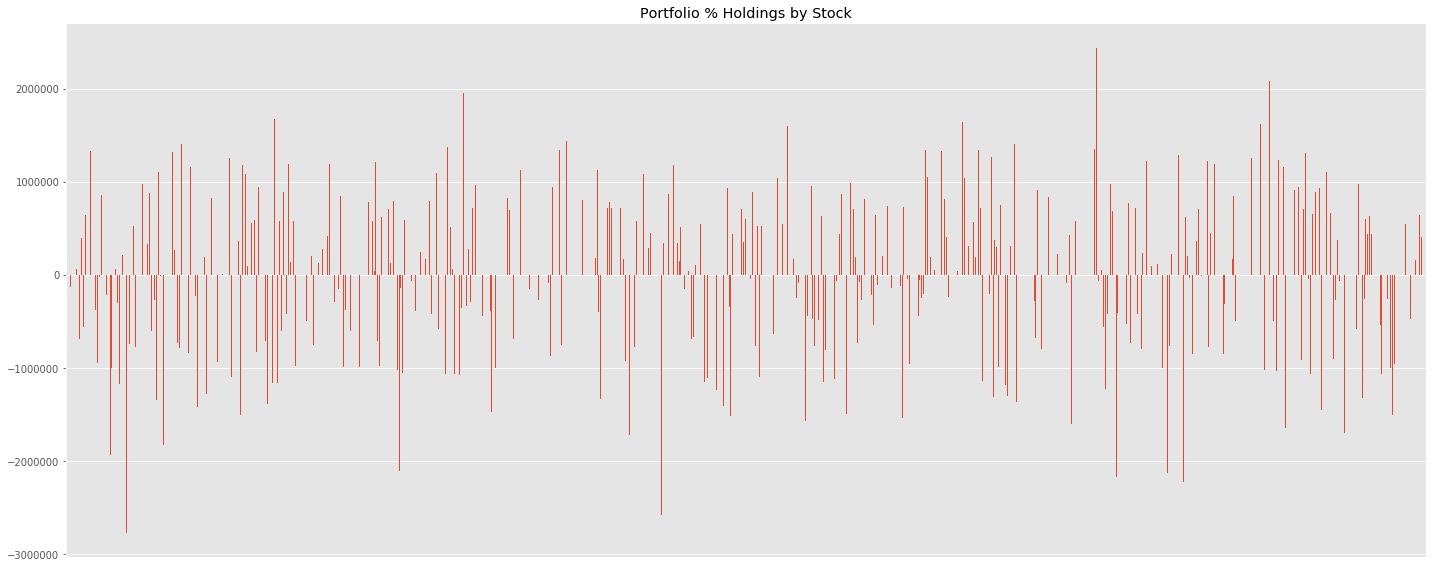

In [47]:
index_ = list(port.keys())[-1]
p = port[index_]
print(p['risk.exposures'].head())

optimal_weights = p['h.opt']
figsize(20, 8)
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.tight_layout()

In [48]:
print('average long holdings: ', optimal_weights.loc[optimal_weights['holdings'] > 0].mean().values[0].round(4))
print('max long holding: ', optimal_weights.loc[optimal_weights['holdings'] > 0].max().values[0].round(4))
print('average short holdings: ', optimal_weights.loc[optimal_weights['holdings'] <= 0].mean().values[0].round(4))
print('max short holding: ', optimal_weights.loc[optimal_weights['holdings'] < 0].min().values[0].round(4))
print('gmv = ', optimal_weights.loc[optimal_weights['holdings'] > 0].sum() + optimal_weights.loc[optimal_weights['holdings'] < 0].abs().sum().values[0])

average long holdings:  382653.0532
max long holding:  2439215.5032
average short holdings:  -405405.3969
max short holding:  -2775684.9135
gmv =  holdings    3.000000e+08
dtype: float64


In [70]:
shifted_rets = returns.shift(-2)
print(rets.loc[:,['AAPL']].head())
print(shifted_rets.loc[:,['AAPL']].head())

ticker          AAPL
Date                
2014-01-02 -0.014064
2014-01-03 -0.021966
2014-01-06  0.005453
2014-01-07 -0.007152
2014-01-08  0.006333
ticker          AAPL
Date                
2012-01-06  0.003580
2012-01-09 -0.001630
2012-01-10 -0.002745
2012-01-11 -0.003749
2012-01-12  0.011648


In [71]:
def wins(x, a=-0.50, b=0.50):
    return np.where(x <= a,a, np.where(x >= b, b, x))

In [72]:
def estimate_factor_returns(exposures, returns):
    lr = LinearRegression()
    lr.fit(exposures, returns)
    return lr.coef_
    

In [73]:
def build_pnl_attribution(port, returns, alpha, date_index):
    
    df = pd.DataFrame(index=date_index)
    
    for date_ in date_index:
        date_str = date_.strftime('%Y%m%d')
        rets = returns.loc[date_, :].apply(wins)
        rets = pd.Series(data=np.nan_to_num(rets), index=rets.index, name=rets.name)

        
        p = port[date_str]
        
        
        df.at[date_, 'daily.pnl'] = np.sum(p['h.opt']['holdings'] * rets)
        
        p_av_values = pd.Series(data=np.nan_to_num(p['alpha.vector'].values), index=p['alpha.vector'].index,
                                   name=p['alpha.vector'].name)
        alpha_returns = estimate_factor_returns(p['alpha.vector'].values.reshape((len(p['alpha.vector']), 1)), wins(rets, -0.25, 0.25))
        df.at[date_, 'attribution.alpha.pnl'] = np.sum(alpha_returns * p['alpha.exposures'])
        
        factor_returns = estimate_factor_returns(p['factor.exposures'], wins(rets, -0.25, 0.25))
        df.at[date_, 'attribution.risk.pnl'] = np.sum(factor_returns * p['risk.exposures'])
        df.at[date_, 't.costs'] = p['t.costs']
        
        
    return df


In [74]:
df = build_pnl_attribution(port, shifted_rets, momentum, test_period)

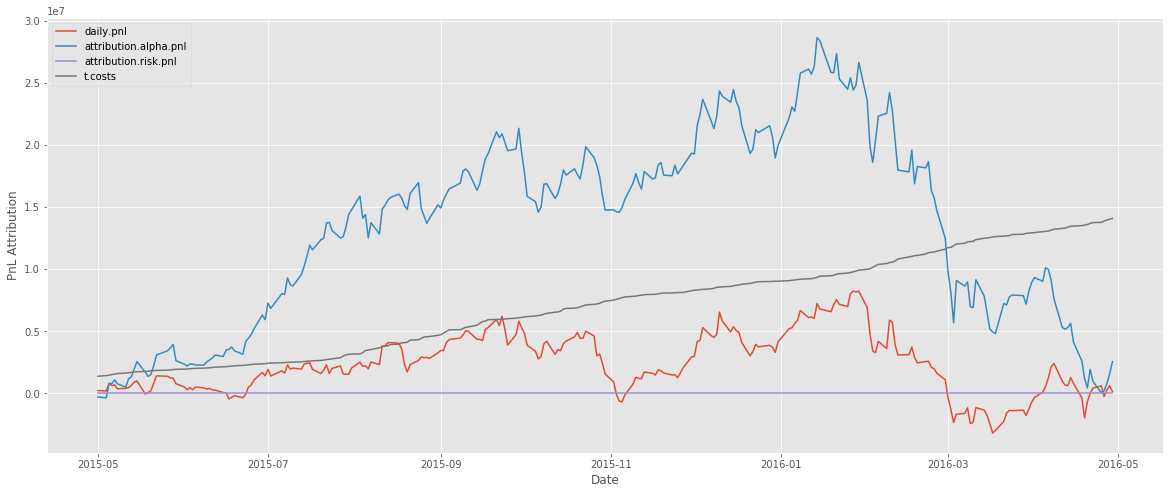

In [75]:
attr = build_pnl_attribution(port, shifted_rets, momentum, test_period)

for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

In [ ]:
def build_portfolio_characteristics(my_dates, port): 
    df = pd.DataFrame(index = my_dates)
    
    for dt in my_dates:
        date = dt.strftime('%Y%m%d')
  
        p = port[date]
        h = p['h.opt']
        h0 = pd.DataFrame(p['h.opt.previous'], index=h.index)
        
        # TODO: Implement
        longs = np.sum(h[h>0]).values
        shorts = np.sum(h[h<0]).values

        df.at[dt,"long"] = longs
        df.at[dt,"short"] = shorts
        df.at[dt,"net"] = longs + shorts
        df.at[dt,"gmv"] = longs + np.abs(shorts)
        
        #df.at[dt,"traded"] = np.sum(np.abs(h - h0)).values
        
    return df

In [ ]:
pchar = build_portfolio_characteristics(test_period, port)

for column in pchar.columns:
    plt.plot(pchar[column], label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Portfolio')
plt.show()